## 기본


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.1 MB/s eta 0:00:00


In [ ]:
# 데이터 처리 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import koreanize_matplotlib  # 한글 폰트 설정

# 모델링: 분류
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# 모델링: 회귀
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 고해상도 출력 설정 (주피터 노트북)
%config InlineBackend.figure_format = 'retina'

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
member = pd.read_csv('/content/drive/MyDrive/O1B2/BDA 최종과제 (10기)/프로젝트 데이터/member.csv')
point = pd.read_csv('/content/drive/MyDrive/O1B2/BDA 최종과제 (10기)/프로젝트 데이터/group_point - point.csv')
study = pd.read_csv('/content/drive/MyDrive/O1B2/BDA 최종과제 (10기)/프로젝트 데이터/group_study - group_study.csv')

In [ ]:
# member = pd.read_csv('/content/drive/MyDrive/BDA최종과제/member.csv')
# point = pd.read_csv('/content/drive/MyDrive/BDA최종과제/group_point - point.csv')
# study = pd.read_csv('/content/drive/MyDrive/BDA최종과제/group_study - group_study.csv')

## 데이터 전처리

### 잘못된 member_id 및 leave_point 정제

In [ ]:
# 앞 4자리 추출 (문자열 변환 + 슬라이싱)
study['id_prefix'] = study['member_id'].astype(str).str[:4]

# 빈도 카운트
prefix_counts = study['id_prefix'].value_counts().sort_index()

print(prefix_counts)

id_prefix
2023      1
2024    659
2025    357
기말 휴      1
Name: count, dtype: int64


In [ ]:
point['generation'] = point['generation'].astype(str)
point['group_number'] = point['group_number'].astype(str)
point['nth_month'] = point['nth_month'].astype(str)

# 제외할 ID 목록
drop_ids = ['기말 휴회기간 이후', '2023060268']
# drop (조건 필터링)
study = study[~study['member_id'].isin(drop_ids)]
replace_map = {

'기말 휴회기간 이': '기말 휴회기간 이후',

'기말 휴회기간 이휴': '기말 휴회기간 이후',

'중간휴회기간 이전': '중간 휴회기간 이전'

}
study['leave_point'] = study['leave_point'].replace(replace_map)

study['generation'] = study['generation'].astype(str)
study['group_number'] = study['group_number'].astype(str)
study['group_master'] = study['group_master'].astype(int).astype(str)
study['group_leave'] = study['group_leave'].astype(int).astype(str)
study['excellent_group'] = study['excellent_group'].astype(int).astype(str)
study['excellent_group_master'] = study['excellent_group_master'].astype(int).astype(str)

member['class1'] = member['class1'].replace('일반 학회원', '일반학회원')
member['member_id'] = member['member_id'].astype(str).astype(str)
member['generation'] = member['generation'].astype(str)
member['birthday'] = member['birthday'].fillna(0).astype(int)#.astype(str)
member['before_id'] = member['before_id'].fillna(0).astype(int).astype(str)
member['class2'] = member['class2'].fillna(0).astype(str)
member['class3'] = member['class3'].fillna(0).astype(int).astype(str)
member['class4'] = member['class4'].fillna(0).astype(int).astype(str)
member['major_data'] = member['major_data'].astype(int).astype(str)
member['marketing_agree'] = member['marketing_agree'].astype(int).astype(str)
member['contents_agree'] = member['contents_agree'].astype(int).astype(str)
member['withdrawal'] = member['withdrawal'].astype(int).astype(str)
member=member.fillna('X').astype(str)

### IT/Non-IT 전공 분류 처리

In [ ]:
# 🖥️ IT 계열 전공 리스트 (포함 키워드: IT, 컴퓨터, 데이터, 인공지능, AI)
it_majors = [
    "IT(컴퓨터 공학 포함)", "컴퓨터학과", "데이터테크학과", "it학부 컴퓨터정보공학과",  "(졸업)언어정보학과/(재학)컴퓨터과학과",
    "디지털소프트웨어공학부", "컴퓨터학부", "AI융합학부", "소프트웨어학과", "컴퓨터공학과","캄퓨터공학부 소프트웨어공학과",
    "컴퓨터융합학부", "데이터정보학과", "컴퓨터과학과", "컴퓨터/AI학부", "컴퓨터과학부","IT경영학과", "빅데이터융합학과",
    "컴퓨터공학부 멀티미디어학과", "소프트웨어융합학과", "소프트웨어학부", "정보통신공학과","데이터과학과","데이터사이언스학과",
    "AI빅데이터학과", "데이터과학부", "데이터경영학과", "AI 자율주행시스템공학과","AI&SW학부","데이터테크놀로지학과",
    "소프트웨어학부 컴퓨터과학전공학과", "소프트웨어공학과", "데이터사이언스경영학과","소프트웨어학부 컴퓨터과학과",
    "ICT융합학부", "AI소프트웨어융합학부 컴퓨터공학과", "IT미디어공학과", "데이터사이언스와 인공지능 학부",
    "데이터사이언스학부", "인공지능공학과", "ai소프트웨어융합학부", "AI융합학부 지능형 IoT학과","빅데이터응용학과",
    "데이터 사이언스 학과", "컴퓨터공학부", "정보통신공학부", "소프트웨어융합대학 컴퓨터공학과","통계 데이터과학과",
    "컴퓨터인공지능공학부", "글로벌융합학부 데이터사이언스융합학과", "IT 융합학부", "컴퓨터소프트웨어공학과",
    "IT학부", "디지털소프트웨어공학과", "멀티미디어공학과", "정보컴퓨터공학부","AI소프트웨어융합학부 컴퓨터공학과",
    "AI소프트웨어융합학부 컴퓨터공학과", "AI학과", "소프트웨어학부 컴퓨터과학과","인공지능공학부",
    "빅데이터응옹통계학과", "빅데이터응용통계학과", "통계데이터과학과", "데이터과학과", "AI융합학부 AI학과","인공지능학과","데이터사이언스융합학과",
    "Sw융합학부 sw융합경제경영학과","빅데이터학과", "정보통계학전공", "Ai빅데이터융합경영학과","AI빅데이터융합경영학과","IT공학전공","응용소프트웨어학과",
    "글로벌융합학부 데이터사이언스융합학과","AI학과","Ai융합학부","데이터사이언스(석사)","수리빅데이터학과","산업데이터공학과","수리데이터사이언스학과", "컴퓨터소프트웨어학부",
    "IT(컴퓨터 공학 포함)", "소프트웨어학과", "Business AI학과", "빅데이터융합 연계전공 학과",'컴퓨터공학과','빅데이터분석학과',
    "데이터융합서비스디자인학과", "데이터사이언스학과", "빅데이터전공", "컴퓨터 전자시스템학부",
    "컴퓨터학과", "데이터사이언스연계전공학과", "빅데이터분석학부", "데이터사이언스 소프트웨어학과",
    "빅데이터융합학과", "빅데이터학과", "컴퓨터공학과", "데이터사이언스소프트웨어학과",'AI융합학부', '소프트웨어융합학과'
    "데이터사이언스융합학과", "융복합소프트웨어학과", "빅데이터응용학과", "소프트웨어학부",
    "AI데이터융합학부", "빅데이터분석학과", "컴퓨터학부", "인공지능학부",
    "AI소프트웨어학부(인공지능전공)", "인공지능융합학과", "빅데이터마이크로전공학과",
    "인공지능컴퓨팅학과", "AI융합학부", "응용데이터사이언스학과", "데이터사이언스전공학부",
    "연계전공 - 데이터사이언스융합학과", "AI융합전공학부", "sw&AI융합전공학과",
    "빅데이터 융합학과", "산업데이터공학과", "AI융합학부 AI학과", "컴퓨터과학과",
    "AI 융합학과", "융복합소프트웨어전공학부", "언어,뇌,컴퓨터 융합 학부",
    "융합소프트웨어학과", "데이터사이언스융합전공학과", "데이터과학과", "소프트웨어벤처 학과",
    "소셜데이터사이언스학과", "빅데이터전공학과", "AI융합전공 학과", "컴퓨터공학부",
    "데이터사이언스소프트웨어", "융복합소프트웨어", "데이터융합서비스디자인전공[융합전공-학과/학부가 아님] 학부",
    "융복합소프트웨어학부", "데이터사이언스융합학부", "AI빅데이터융합경영학과", "AI데이터학부",
    "검퓨터공학부", "데이터 사이언스 소프트웨어 학과", "데이터인포매틱스학과",
    "인공지능반도체공학과", "수리통계데이터사이언스학부 빅데이터학과", "인지인공지능학과",
    "AI 융합학부", "정보통신융합공학과", "융합데이터공학과", "AI빅데이터융합학과",
    "데이터사이언스연계전공 SW학과", "의료인공지능학과", "빅데이터융합전공학과",
    "AI융합학과", "인공지능인문학과", "데이터사이언스학부", "융합소프트웨어학부 데이터사이언스학과",
    "융복합 소프트웨어학과", "핀테크비지니스 학과", "응용데이터사이언스 학부",
    "데이터사이언스학", "Ai학부", "융합소프트웨어 학과", "컴퓨터정보통신공학과",
    "데이터 애널리틱스 학과", "AI 융합 전공 학과", "빅데이터 경영학과"
]

# 📚 비 IT 계열 전공 리스트 (위 조건에 해당하지 않는 나머지)
non_it_majors = [
    "의약학", "교육학", "사회과학", "자연과학", "인문학", "경영학", "경제통상학", "X", "예체능", "법학", "기타",
    "창의기술경영학과", "Faculty of Resources Science and Technology 학과 Plant Resource Science and Management 학부",
    "응용통계학과",   "경영학과", "신소재공학과", "통계학과",
    "광고홍보학과",  "국제금융학과", "수학과", "도시공학과",
    "기계스마트산업공학부 스마트팩토리학과", "기계시스템디자인공학과", "경영학부", "정보통계학과",
    "실내건축디자인학과", "의상학과", "영어영문학과", "심리학부", "경제학과", "도시사회학과",
    "항공기시스템공학과", "무역학과", "조경학과", "산업공학과", "국제통상학과",
    "의생명융합공학부", "국제학부", "수학통계학부 수학과", "화공생명공학과",
    "보건환경융합과학부", "교육공학과", "경영공학과", "휴먼기계바이오공학부", "농업경제학과",
     "교육학과", "산업경영공학과",
     "생명공학부", "보건행정학과",  "정경대학 통계학과",
    "식품영양학과", "응용수학과", "국제사무학과", "원예생명공학", "의공학과", "생명정보융합학과",
    "식품공학과", "스칸디나비아어학과", "경영정보학부", "시스템경영공학과", "러시아유라시아학과",
    "바이오메디컬공학부", "화학공학과", "글로벌미디어학부", "스포츠건강재황학과", "국어국문학과",
     "화학과", "경영인텔리전스학과", "스마트모빌리티학과", "건축공학과",
    "산업경영정보공학과", "아동심리학과", "에너지화학공학과", "사회학과", "스페인어학과", "외식경영학과",
    "국제법무학과", "상경학부 글로벌경영학과", "수학교육학과", "관광개발학과", "정치외교학과", "소비자경제학과",
    "자유전공학부", "광고홍보학부", "노어학과", "법학과", "중국어통번역학과", "융합생명공학과", "동양사학과",
    "영어통번역(EICC)학과", "환경학과", "전자공학과", "화공신소재공학부", "스페인중남미학과", "루마니아학과",
    "바이오메디컬화학공학과", "반도체전자공학부", "몽골어학과", "경제학부", "행정학과", "태국학과",
    "전기정보공학부",  "바이오공학과", "스마트유통물류학과", "바이오시스템의과학부",
    "동물생명공학과", "의류학과", "글로벌커뮤니케이션학부",
    "시스템생명공학과", "기계자동차공학과", "약학과", "미디어소프트웨어학과", "생활과학대학 통합디자인학과",
     "물리학과", "방송디지털미디어학과", "화공생명공학부", "정보통신학부", "서아프리카어학과",
    "스포츠산업레저학과", "사학과", "터키•아제르바이잔어학과", "바이오화학공학과",
    "나노과학공학과", "미디어커뮤니케이션학과",  "경영학부 글로벌금융학과", "미디어학부",
    "공간디자인소비자학과",  "한국사학과", "생명과학부", "중국어중국학과", "세무회계학과",
    "작곡학과", "호텔관광경영학과", "글로벌문화학부", "부동산학과", "환경생태공학부", "문화관광콘텐츠학과",
     "토목건축공학과", "정보사회학과", "영어영문학부",
     "의료공학과", "아시아문화학부 일본어문학과", "국제관계학과", "휴먼기계바이오공학과",
    "글로벌스포츠산업학부", "우주과학과", "전기공학과", "사회체육학과", "국제물류학과", "수의학과", "관광경영학과",
     "글로벌통상학과", "포르투갈어학과", "독어독문학과", "전자통신공학과", "금융학부",
    "인문학부", "산업경영공학부", "융합보안학과",  "기계항공공학부", "디지털미디어학과",
    "언어학과", "금융빅데이터학부", "무역학부", "수리통계데이터사이언스학부 수학과", "일어일문학과",
    "디지털경영학부", "체코슬로바키아어학과", "사회과학대학 경제학과",
    "영어학과", "의예과/의학과", "실내건축학과", "중국학과", "융합기계공학과", "수학통계학과",
    "산업시스템학과", "베트남어학과", "행정학부", "지적학과", "ELLT학과", "멀티미디어공학과",
    "스포츠과학과",  "전기생체공학부 생체공학과", "의공학부", "산업경영학과",
    "미디어커뮤니케이션학부",  "바이오메디컬공학과", "신소재공학부", "정보보안암호수학과",
    "법학부", "전자전기공학과", "미디어학과",  "한국어문학부", "바둑학과",
    "금융수학과", "경영학부 경영학과", "첨단융합학부",  "도시교통공학과", "걍영학부",
    "산업융합학부", "정책학과", "컴퓨터교육학과", "보건행정학", "스마트시티학과",
    "사회환경공학부", "유기재료공학과", "수학통계학부", "전자정보공학부", "경영학전공",
    "아시아문화학부", "화공신소재공학과", "신소재공학부 정보소재공학과", "아랍어학과",
    "지능기전공학과",  "정보통계학부", "글로벌금융경영학부", "생명환경공학과", "융합전자공학부",
    "기계공학부", "에너지시스템공학부", "계량위험관리학과","X", "인문학", "경영학", "자연과학", "의약학", "기타", "경제통상학", "예체능", "사회과학","공학(컴퓨터 공학 제외)",
    "법학", "교육학", "없음", "경영학과", "기계스마트산업공학부 산업공학과", "경제학과",'사회과학', '기타', '자연과학', '경영학',
       '인문학', '경제통상학', '없음','소비자학과', '영미어문학과'
    "산업경영공학과", "소비자학과", "정보통계학과", "통계학과", "경영학부", "경영정보학과",
    "경제학부", "수학통계학부 응용통계학과", "시스템경영공학과", "국제통상학전공", "응용통계학과",
    "국어교육학과", "인문학부", "응용수학", "바이오나노학과", "부동산학과", "금융공학융학전공학부",
    "e-비즈니스학과", "사회학과", "전자전기공학부", "시각영상디자인학과", "미디어커뮤니케이션학과",
    "산업공학과", "식품영양학과", "인문학과 사회과학 학부", "산업공학학과", "바이오메디컬공학과",
    "바이오생명공학과", "신소재공학부", "휴먼지능정보공학과", "국제통상학과", "영어교육학과",
    "커뮤니케이션미디어학부", "지역경제개발협력전공학과", "국제학부", "반도체공학과", "글로벌문화기술학과",
    "자기설계융합전공학과", "사이버보안학과", "도시사회학과", "물류학과", "Bric’s학과",
    "비즈니스애널리틱스 융합전공학부", "서베이앤데이터사이언스", "산업보안학과", "소비자생활문화산업학과",
    "홍보광고학과", "비지니스애널리틱스 융합전공", "응용심리학과", "융합에너지공학과", "정치외교학과",
    "경영학과 (마이크로디그리 : AI 마이크로디그리)", "정밀의료융합전공학과", "정치국제학과",
    "문화관광학과(학사)", "경영인텔리전스학과", "디자인조형학부", "생명과학과", "금융공학과",
    "문헌정보학과", "말레이인도네시아학과", "문화인류학과", "정밀의료전공(연계)학과",
    "사회과학융합학부", "스마트팩토리학과", "관광이벤트전공", "문화콘텐츠학과", "공공거버넌스와리더십학부",
    "행정정보학과", "비즈니스 마케팅 학과", "정보통계보험수리학과", "심리학과", "국제통상연계전공",
    "전자공학부", "생명공학과", "수학과", "화공생명공학과", "생활문화소비자학과", "바이오인포매틱스전공(학과",
    "산업시스템공학"
]

def _norm(s):
    if pd.isna(s):
        return np.nan
    return str(s).lower().replace(" ", "")  # 소문자 + 공백 제거

# it_majors가 이미 존재한다고 가정
it_set_norm = set(_norm(x) for x in it_majors)

# 주요 전공 컬럼 자동 탐색(major1_ 접두)
major_cols = [c for c in member.columns if c.startswith('major1_')]
# 비어있다면 안전하게 기본 후보 사용
if not major_cols:
    major_cols = ['major1_1', 'major1_2', 'major1_3']

# 정규화 뷰 생성(원본은 유지)
norm_view = member[major_cols].applymap(_norm)

# 행 단위로: 어느 전공이라도 it_set_norm에 들어가면 IT
it_mask = norm_view.apply(lambda s: s.isin(it_set_norm), axis=1).any(axis=1)
member['major_group_all'] = np.where(it_mask, 'IT 계열', 'Non-IT 계열')

/tmp/ipython-input-1080138436.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  norm_view = member[major_cols].applymap(_norm)


### leave_point의 결측 처리 및 '확인 불가' 치환

In [ ]:
pd.crosstab(study['group_leave'], study['leave_point'])

leave_point,기말 휴회기간 이후,중간 휴회기간 이전,중간 휴회기간 이후,해당없음,확인 불가
group_leave,,,,,
0,0,0,0,877,0
1,29,33,60,13,4


In [ ]:
# 1) 타입/문자열 정리
study['group_leave'] = pd.to_numeric(study['group_leave'], errors='coerce')  # '1','0001' 등 숫자로
study['leave_point'] = study['leave_point'].astype(str)                      # 카테고리→문자
study['leave_point'] = study['leave_point'].str.strip()                      # 앞뒤 공백 제거
# 내부 공백까지 제거하여 '해당 없음' → '해당없음' 통일
study['leave_point_norm'] = study['leave_point'].str.replace(r'\s+', '', regex=True)

# 2) '해당없음' 표준화 (nan/None 등도 커버)
study['leave_point_norm'] = study['leave_point_norm'].replace({
    'nan': '해당없음', 'None': '해당없음'
})

# 3) 매핑 (탈퇴자이면서 leave_point가 '해당없음'이었던 케이스)
mask = (study['group_leave'] == 1) & (study['leave_point_norm'] == '해당없음')
study.loc[mask, 'leave_point'] = '확인 불가'   # 실제 표시 컬럼에 반영

# 4) 보조 컬럼 정리
study = study.drop(columns=['leave_point_norm'])

# 5) 결과 확인
print("매핑된 행 수:", mask.sum())
print(pd.crosstab(study['group_leave'], study['leave_point']))

매핑된 행 수: 13
leave_point  기말 휴회기간 이후  중간 휴회기간 이전  중간 휴회기간 이후  해당없음  확인 불가
group_leave                                                 
0                     0           0           0   877      0
1                    29          33          60     0     17


### 유효 그룹 판별 및 고아 그룹 제거

In [ ]:
# 그룹 키만 추출 (중복 제거)
keys_study = study[['generation','class_code','group_number']].drop_duplicates()
keys_point = point[['generation','class_code','group_number']].drop_duplicates()

# study에는 있는데 point에는 없는 그룹
orphans_in_study = keys_study.merge(keys_point,
                                    on=['generation','class_code','group_number'],
                                    how='left', indicator=True)
orphans_in_study = orphans_in_study[orphans_in_study['_merge']=='left_only']

# point에는 있는데 study에는 없는 그룹
orphans_in_point = keys_point.merge(keys_study,
                                    on=['generation','class_code','group_number'],
                                    how='left', indicator=True)
orphans_in_point = orphans_in_point[orphans_in_point['_merge']=='left_only']

print("study에는 있는데 point에는 없는 그룹 수:", len(orphans_in_study))

print("point에는 있는데 study에는 없는 그룹 수:", len(orphans_in_point))

study에는 있는데 point에는 없는 그룹 수: 9
point에는 있는데 study에는 없는 그룹 수: 3


분석 단위 일치(정합성)

우리가 분석하려는 것은 “멤버가 속한 조의 활동(점수)과 결과(이탈)”.

study(멤버/조 편성)와 point(조 점수)가 둘 다 존재해야만 활동과 결과를 연결할 수 있습니다.

inner join은 이 공통 영역(교집합) 만 남겨, 잘못된 매칭·NA로 인한 왜곡을 예방합니다.

누락/유령 조의 영향 제거

결과: study-only 9개 = 편성은 되었지만 활동(점수) 기록이 전혀 없는 조

결과: point-only 3개 = 점수는 있으나 멤버 명단이 없는 조(특수반/동기화 누락 가능)

--------

“본 분석은 조 편성(study)과 활동 점수(point)가 모두 확인되는 표본만을 사용하기 위해 inner join을 적용하였다. 이는 활동-결과의 연결이 불가능한 표본을 배제하고, 점수 미기입·멤버 누락으로 인한 체계적 편향을 방지하여, 지표의 해석 가능성과 정책 시사점을 확보하기 위함이다.”

In [ ]:
# 공통 키
KEYS = ['generation','class_code','group_number']

# 유효 그룹(= study∩point)과 고아 그룹 구하기
keys_study = study[KEYS].drop_duplicates()
keys_point = point[KEYS].drop_duplicates()

valid_groups     = keys_study.merge(keys_point, on=KEYS, how='inner')   # ← 둘 다 있는 그룹
orphans_in_study = keys_study.merge(keys_point, on=KEYS, how='left',  indicator=True).query("_merge=='left_only'").drop(columns=['_merge'])
orphans_in_point = keys_point.merge(keys_study, on=KEYS, how='left',  indicator=True).query("_merge=='left_only'").drop(columns=['_merge'])

print(len(valid_groups), len(orphans_in_study), len(orphans_in_point))

# 고아 그룹 소속 member_id 뽑기
bad_ids_from_study = (
    study.merge(orphans_in_study, on=KEYS, how='inner')['member_id']
    .astype(str).str.strip().unique()
)

BAD_IDS = set(bad_ids_from_study)
print(BAD_IDS)

# 제외하고 정리
# study/point/total 모두 “유효 그룹만 + bad_ids 제외”
# 우선 유효 그룹만 남기기 (세미조인)
study_ok = study.merge(valid_groups, on=KEYS, how='inner')
point_ok = point.merge(valid_groups, on=KEYS, how='inner')

# 고아 그룹 소속 멤버 제외
study_ok = study_ok[~study_ok['member_id'].astype(str).str.strip().isin(BAD_IDS)]
if 'member_id' in point_ok.columns:
    point_ok = point_ok[~point_ok['member_id'].astype(str).str.strip().isin(BAD_IDS)]

218 9 3
{'2025100076', '2024090621', '2024090014', '2024090097', '2024090100', '2025100465', '2025100432', '2024090312', '2024090114', '2024090663', '2024090642', '2024090730', '2024090657', '2024090636', '2025100097', '2025100766', '2024090400', '2024090535', '2024090252', '2024090804', '2024090029', '2024090194', '2025100531', '2024090348', '2024090645', '2024090031', '2024090625', '2024090039', '2024090481', '2024090134', '2025100350', '2025100808', '2024090459'}


### member + study (조별활동 참여 안 한 사람 + 조별활동 참여한 사람)

### study_ok <-> member 간 키 정합성 확인

In [ ]:
study_keys  = study_ok[['member_id','generation']].drop_duplicates()
member_keys = member[['member_id','generation']].drop_duplicates()

only_in_studyok = (study_keys
    .merge(member_keys, on=['member_id','generation'], how='left', indicator=True)
    .query("_merge=='left_only'")
)

# study_ok에 있는데 member에는 없는 (member_id, generation) 찾기
print(len(only_in_studyok), only_in_studyok.head())
# ← 이게 2명이면 바로 위 971 vs 973의 원인 확정

2       member_id generation     _merge
701  2024090694         10  left_only
728  2024090266         10  left_only


study_ok에는 있는데 member에는 없는 (member_id, generation)이 2명
=> study_ok를 member에 존재하는 사람만 남기도록 정합화함 => 모집단이 member (전체 회원에 대한 정보가 있는 사람만 분석 진행)

In [ ]:
KEYS = ['member_id','generation']

member_keys  = member[KEYS].drop_duplicates()
study_ok = study_ok.merge(member_keys, on=KEYS, how='inner')  # ← 2명 제외

In [ ]:
total= pd.merge(
    member,
    study_ok,
    on=['member_id','generation'],  # 기준 키 2개
    how='left'   # 공통된 값만 (필요에 따라 left/right/outer 선택 가능)
)

total

,member_id,generation,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all,class_code,group_number,group_master,on_offline,group_leave,leave_point,excellent_group,excellent_group_master,id_prefix
0,2024080001,8,20031224,ivzmnh,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024080002,8,20031224,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024080003,8,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,4,14,0,오프라인,0.0,해당없음,0,0,2024
3,2024080004,8,20020523,ilcfnz,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,7,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024080005,8,19980506,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,7,0,0,0,1,1,0,0,IT 계열,7,1,0,오프라인,0.0,해당없음,0,0,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,2025100914,10,20000119,clgyzm,융합전자공학부,X,X,X,X,대학생,A. 해당없음,X,0,2,0,0,0,1,1,2024081077,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2923,2025100915,10,20040403,ivzmnh,기계공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,0,0,0,1,1,0,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2924,2025100916,10,20030209,iqxold,에너지시스템공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,16,0,0,1,1,0,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2925,2025100917,10,20021205,dpdxyj,컴퓨터학부,X,X,X,X,대학생,A. 해당없음,X,1,4,5,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 참여 여부 (group_number 기준)
total['group_status_all'] = np.where(total['group_number'].notna(), '참여', '미참여')
total

,member_id,generation,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all,class_code,group_number,group_master,on_offline,group_leave,leave_point,excellent_group,excellent_group_master,id_prefix,group_status_all
0,2024080001,8,20031224,ivzmnh,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
1,2024080002,8,20031224,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
2,2024080003,8,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,4,14,0,오프라인,0.0,해당없음,0,0,2024,참여
3,2024080004,8,20020523,ilcfnz,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,7,0,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
4,2024080005,8,19980506,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,7,0,0,0,1,1,0,0,IT 계열,7,1,0,오프라인,0.0,해당없음,0,0,2024,참여
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,2025100914,10,20000119,clgyzm,융합전자공학부,X,X,X,X,대학생,A. 해당없음,X,0,2,0,0,0,1,1,2024081077,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
2923,2025100915,10,20040403,ivzmnh,기계공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,0,0,0,1,1,0,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
2924,2025100916,10,20030209,iqxold,에너지시스템공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,16,0,0,1,1,0,0,Non-IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여
2925,2025100917,10,20021205,dpdxyj,컴퓨터학부,X,X,X,X,대학생,A. 해당없음,X,1,4,5,0,0,1,1,0,0,IT 계열,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,미참여


In [ ]:
total=total.fillna('X').astype(str)
total

,member_id,generation,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all,class_code,group_number,group_master,on_offline,group_leave,leave_point,excellent_group,excellent_group_master,id_prefix,group_status_all
0,2024080001,8,20031224,ivzmnh,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,X,X,X,X,X,X,X,X,X,미참여
1,2024080002,8,20031224,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열,X,X,X,X,X,X,X,X,X,미참여
2,2024080003,8,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,4,14,0,오프라인,0.0,해당없음,0,0,2024,참여
3,2024080004,8,20020523,ilcfnz,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,7,0,0,0,1,1,0,0,IT 계열,X,X,X,X,X,X,X,X,X,미참여
4,2024080005,8,19980506,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,7,0,0,0,1,1,0,0,IT 계열,7,1,0,오프라인,0.0,해당없음,0,0,2024,참여
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,2025100914,10,20000119,clgyzm,융합전자공학부,X,X,X,X,대학생,A. 해당없음,X,0,2,0,0,0,1,1,2024081077,0,Non-IT 계열,X,X,X,X,X,X,X,X,X,미참여
2923,2025100915,10,20040403,ivzmnh,기계공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,0,0,0,1,1,0,0,Non-IT 계열,X,X,X,X,X,X,X,X,X,미참여
2924,2025100916,10,20030209,iqxold,에너지시스템공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,16,0,0,1,1,0,0,Non-IT 계열,X,X,X,X,X,X,X,X,X,미참여
2925,2025100917,10,20021205,dpdxyj,컴퓨터학부,X,X,X,X,대학생,A. 해당없음,X,1,4,5,0,0,1,1,0,0,IT 계열,X,X,X,X,X,X,X,X,X,미참여


### 조별활동 참여한 member_id로 구성된 테이블
- group_yes : member + study
- group_yes_point : member + study + point

In [ ]:
group_yes = pd.merge(
    study_ok,
    member,
    on=['member_id','generation'],  # 기준 키 2개
    how='left'   # 공통된 값만 (필요에 따라 left/right/outer 선택 가능)
)

group_yes

,member_id,generation,class_code,group_number,group_master,on_offline,group_leave,leave_point,excellent_group,excellent_group_master,id_prefix,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all
0,2024080003,8,4,14,0,오프라인,0,해당없음,0,0,2024,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열
1,2024080005,8,7,1,0,오프라인,0,해당없음,0,0,2024,19980506,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,7,0,0,0,1,1,0,0,IT 계열
2,2024080007,8,5,7,0,온라인,0,해당없음,1,0,2024,20011019,iqxold,의약학,인문학,X,X,X,대학생,X,X,0,2,5,0,0,1,1,0,0,Non-IT 계열
3,2024080007,8,2,4,1,오프라인,0,해당없음,0,0,2024,20011019,iqxold,의약학,인문학,X,X,X,대학생,X,X,0,2,5,0,0,1,1,0,0,Non-IT 계열
4,2024080009,8,4,13,1,온라인,0,해당없음,1,1,2024,20001004,difidc,사회과학,경영학,X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,Non-IT 계열
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,2025100148,10,11,3,0,오프라인,0,해당없음,0,0,2025,0,uslogh,IT공학전공,빅데이터분석학전공,X,X,X,X,X,X,1,12,16,0,0,1,1,0,0,IT 계열
967,2025100730,10,11,4,0,오프라인,0,해당없음,0,0,2025,19980422,clgyzm,정보시스템학과,없음,없음,X,X,대학생,A. 해당없음,X,0,8,16,0,0,1,1,0,0,Non-IT 계열
968,2025100664,10,11,4,0,오프라인,0,해당없음,0,0,2025,20000116,bhnhrk,통계학과,없음,없음,bhnhrk,통계학과,대학원생,A. 해당없음,X,1,6,16,0,0,1,1,0,0,Non-IT 계열
969,2025100725,10,11,4,0,오프라인,0,해당없음,0,0,2025,20030706,fzmpzr,데이터사이언스학과,없음,없음,X,X,대학생,A. 해당없음,X,1,4,5,16,0,1,1,0,0,IT 계열


In [ ]:
group_yes_point = pd.merge(
    group_yes,
    point_ok,
    on=['generation','class_code', 'group_number'],
    how='inner'
)

group_yes_point

,member_id,generation,class_code,group_number,group_master,on_offline,group_leave,leave_point,excellent_group,excellent_group_master,id_prefix,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all,nth_month,point
0,2024080003,8,4,14,0,오프라인,0,해당없음,0,0,2024,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,1,0.925
1,2024080003,8,4,14,0,오프라인,0,해당없음,0,0,2024,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,2,0.500
2,2024080003,8,4,14,0,오프라인,0,해당없음,0,0,2024,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,3,0.000
3,2024080003,8,4,14,0,오프라인,0,해당없음,0,0,2024,20030226,fzmpzr,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,4,0,0,0,1,1,0,0,IT 계열,4,0.000
4,2024080005,8,7,1,0,오프라인,0,해당없음,0,0,2024,19980506,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,7,0,0,0,1,1,0,0,IT 계열,1,2.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,2025100664,10,11,4,0,오프라인,0,해당없음,0,0,2025,20000116,bhnhrk,통계학과,없음,없음,bhnhrk,통계학과,대학원생,A. 해당없음,X,1,6,16,0,0,1,1,0,0,Non-IT 계열,2,0.800
3186,2025100725,10,11,4,0,오프라인,0,해당없음,0,0,2025,20030706,fzmpzr,데이터사이언스학과,없음,없음,X,X,대학생,A. 해당없음,X,1,4,5,16,0,1,1,0,0,IT 계열,1,1.400
3187,2025100725,10,11,4,0,오프라인,0,해당없음,0,0,2025,20030706,fzmpzr,데이터사이언스학과,없음,없음,X,X,대학생,A. 해당없음,X,1,4,5,16,0,1,1,0,0,IT 계열,2,0.800
3188,2025100406,10,11,4,1,오프라인,0,해당없음,0,0,2025,20030407,wurixk,컴퓨터공학부,X,X,X,X,대학생,A. 해당없음,X,1,16,0,0,0,1,1,0,0,IT 계열,1,1.400


### 조별활동 미참여한 member_id로 구성된 테이블

In [ ]:
# 고유 키 준비
member_keys  = member[['member_id','generation']].drop_duplicates()
studyok_keys = study_ok[['member_id','generation']].drop_duplicates()

# 미참여자 (anti-join)
group_no_keys = (
    member_keys.merge(studyok_keys, on=['member_id','generation'], how='left', indicator=True)
               .query("_merge=='left_only'")
               .drop(columns=['_merge'])
)

# 실제 멤버 행 복원
group_no = member.merge(group_no_keys, on=['member_id','generation'], how='inner')
group_no

,member_id,generation,birthday,school1,major1_1,major1_2,major1_3,school2,major2,job,job_domain,company,major_data,class1,class2,class3,class4,marketing_agree,contents_agree,before_id,withdrawal,major_group_all
0,2024080001,8,20031224,ivzmnh,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열
1,2024080002,8,20031224,uslogh,IT(컴퓨터 공학 포함),IT(컴퓨터 공학 포함),X,X,X,대학생,X,X,0,4,0,0,0,1,1,0,0,IT 계열
2,2024080004,8,20020523,ilcfnz,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,1,7,0,0,0,1,1,0,0,IT 계열
3,2024080006,8,20030329,emacrt,IT(컴퓨터 공학 포함),X,X,X,X,대학생,X,X,0,4,0,0,0,1,1,2023070008,0,IT 계열
4,2024080008,8,19940725,xmiyas,교육학,X,X,X,X,대학생,X,X,0,4,6,0,0,1,1,0,0,Non-IT 계열
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,2025100914,10,20000119,clgyzm,융합전자공학부,X,X,X,X,대학생,A. 해당없음,X,0,2,0,0,0,1,1,2024081077,0,Non-IT 계열
1952,2025100915,10,20040403,ivzmnh,기계공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,0,0,0,1,1,0,0,Non-IT 계열
1953,2025100916,10,20030209,iqxold,에너지시스템공학부,없음,없음,X,X,대학생,A. 해당없음,X,0,4,16,0,0,1,1,0,0,Non-IT 계열
1954,2025100917,10,20021205,dpdxyj,컴퓨터학부,X,X,X,X,대학생,A. 해당없음,X,1,4,5,0,0,1,1,0,0,IT 계열


## 예비 분석

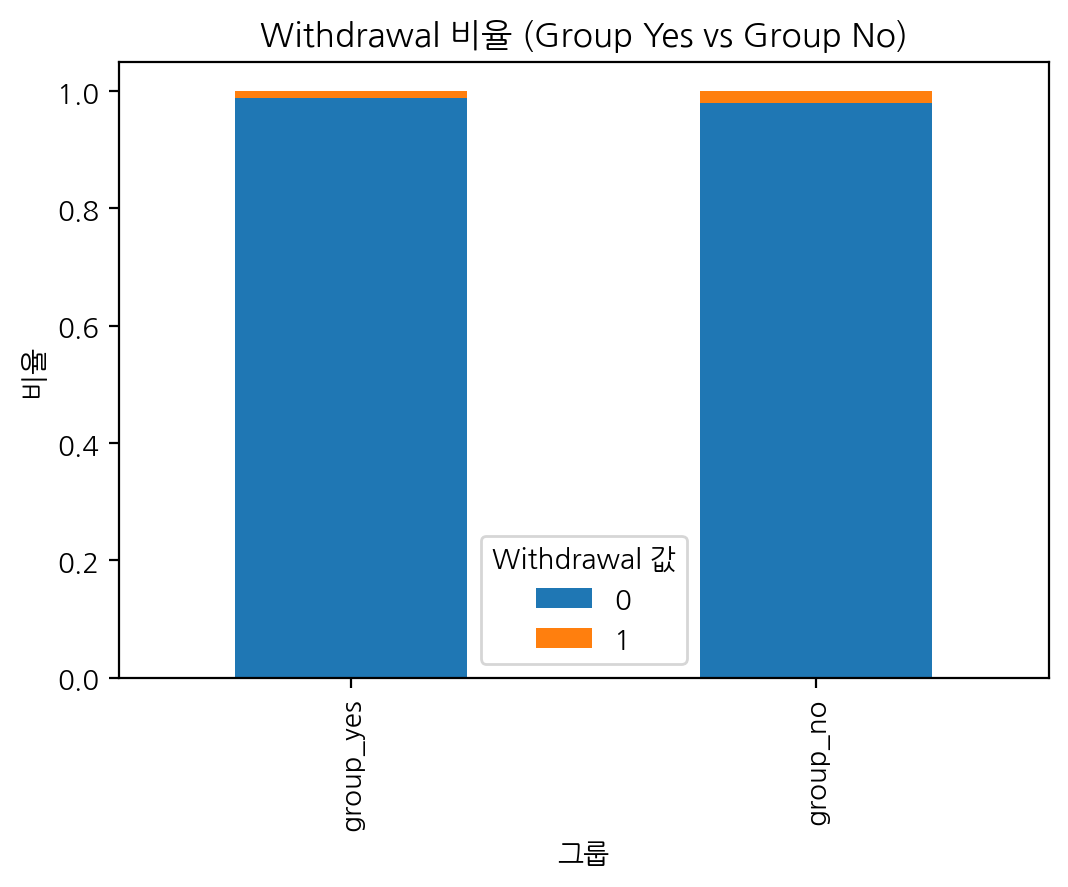

In [ ]:
import matplotlib.pyplot as plt

# group_yes / group_no 별 withdrawal 비율 계산
yes_ratio = group_yes['withdrawal'].value_counts(normalize=True)
no_ratio = group_no['withdrawal'].value_counts(normalize=True)

# 데이터프레임으로 합치기
import pandas as pd
ratio_df = pd.DataFrame({
    'group_yes': yes_ratio,
    'group_no': no_ratio
}).T  # 전치해서 보기 쉽게

# 시각화
ratio_df.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title("Withdrawal 비율 (Group Yes vs Group No)")
plt.ylabel("비율")
plt.xlabel("그룹")
plt.legend(title="Withdrawal 값")
plt.show()


## 개인 특성별 프로파일링

### 전체 현황 개요

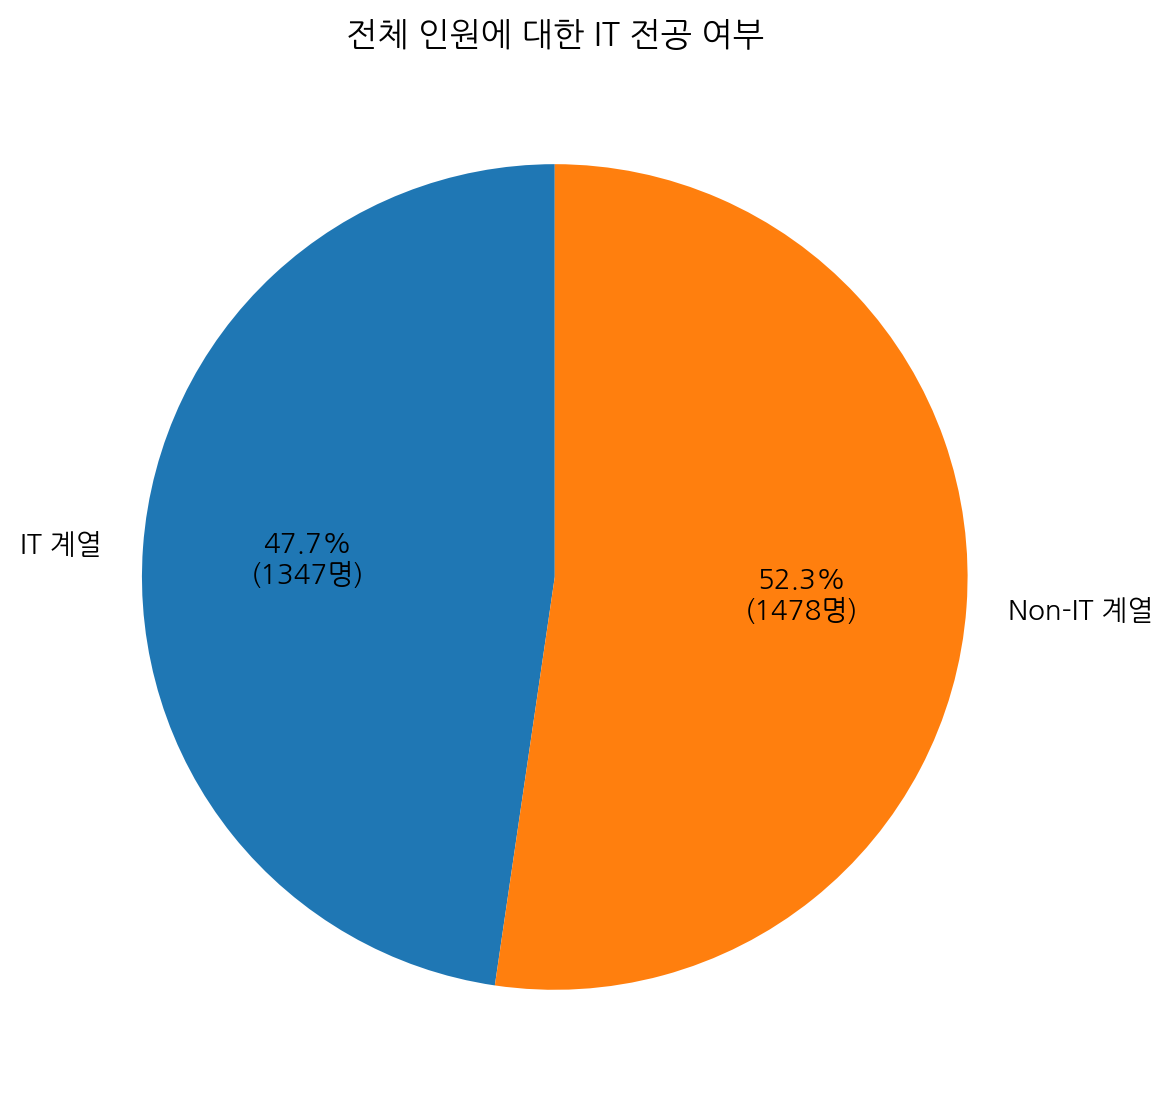

In [ ]:
# 1. major_group_all 컬럼에서 IT/Non-IT 개수 집계
member_counts = member['major_group_all'].value_counts()

# 2. 'IT 계열', 'Non-IT 계열'만 추출 (없을 수도 있으니 fill_value=0)
labels = ['IT 계열', 'Non-IT 계열']
sizes = member_counts.reindex(labels, fill_value=0)

# 퍼센트 + 개수를 동시에 보여주는 함수
def make_autopct(values):
    def my_autopct(pct):
        sums = sum(values)
        count = int(round(pct * sums/ 100.0))
        return f'{pct:.1f}%\n({count}명)'
    return my_autopct

# 3. 파이차트 시각화
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),  # 커스텀 표시
    startangle=90
)
plt.title("전체 인원에 대한 IT 전공 여부")
plt.tight_layout()
plt.show()

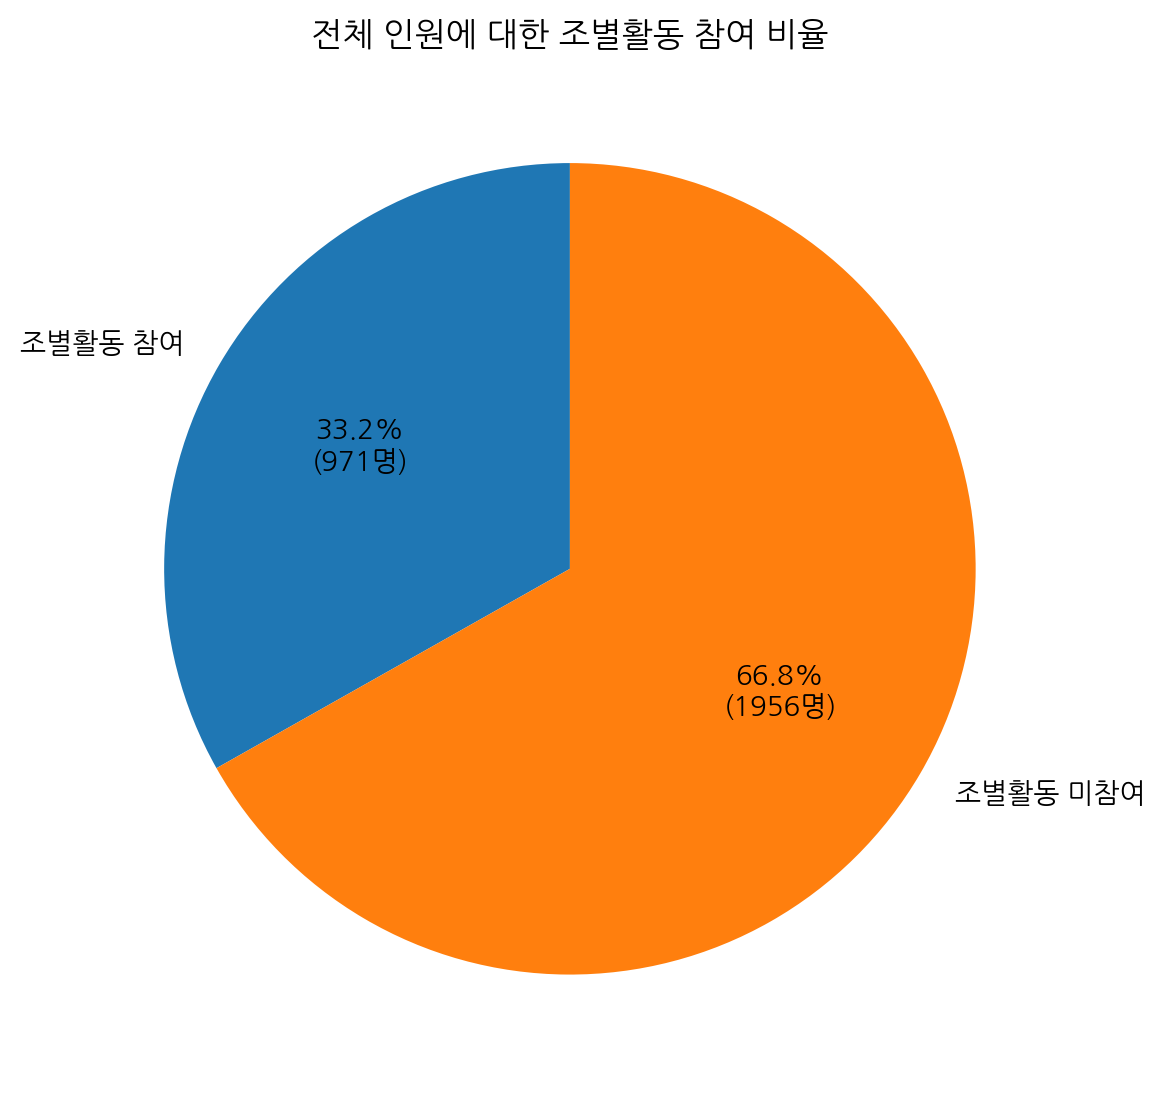

In [ ]:
# 1. 각 테이블의 행 개수
yes_count = len(group_yes)
no_count = len(group_no)

# 2. 전체 합계
counts = yes_count + no_count

# 3. 비율 계산
yes_ratio = yes_count / counts * 100
no_ratio = no_count / counts * 100

# 데이터 준비
labels = ['조별활동 참여', '조별활동 미참여']
sizes = [yes_count, no_count]

# 퍼센트 + 개수를 동시에 보여주는 함수
def make_autopct(values):
    def my_autopct(pct):
        sums = sum(values)
        count = int(round(pct * sums / 100.0))
        return f'{pct:.1f}%\n({count}명)'
    return my_autopct

# 4. 파이차트 시각화
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),  # 커스텀 표시
    startangle=90
)
plt.title("전체 인원에 대한 조별활동 참여 비율")
plt.tight_layout()
plt.show()

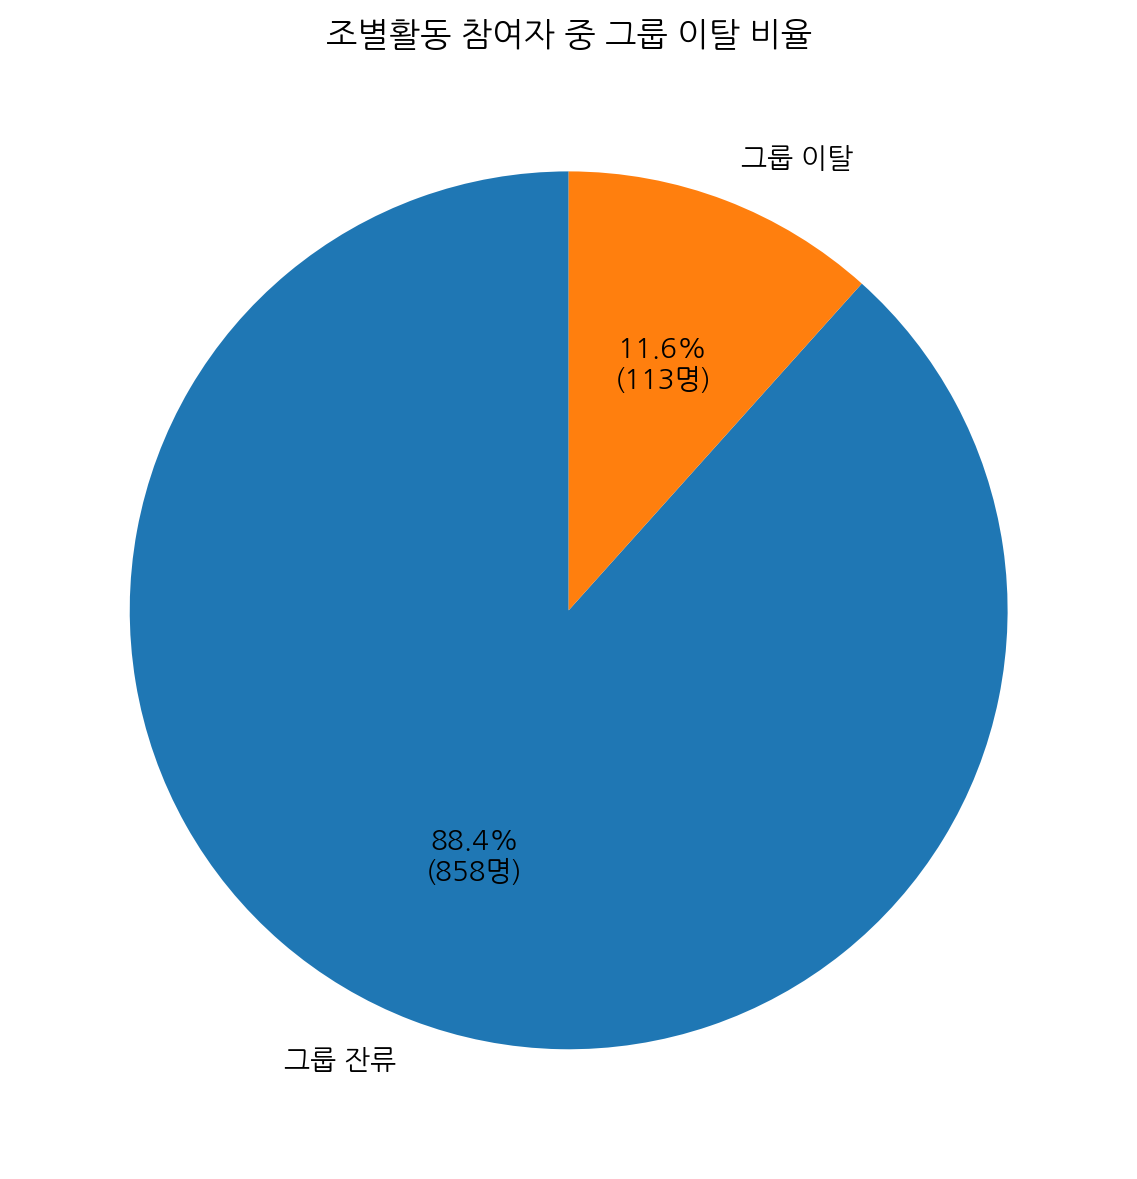

In [ ]:
# 1. group_leave 값 개수 세기
leave_counts = group_yes['group_leave'].value_counts()

# 2. 레이블과 값 준비
labels = ['그룹 잔류', '그룹 이탈']
sizes = leave_counts.values.tolist()

# ✅ 3. 퍼센트 + 개수를 동시에 보여주는 함수
def make_autopct(values):
    def my_autopct(pct):
        sums = sum(values)
        count = int(round(pct * sums / 100.0))
        return f'{pct:.1f}%\n({count}명)'
    return my_autopct

# 4. 파이차트 시각화
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=make_autopct(sizes),  # 커스텀 표시
    startangle=90
)
plt.title("조별활동 참여자 중 그룹 이탈 비율")
plt.tight_layout()
plt.show()

### 전공별 참여 현황

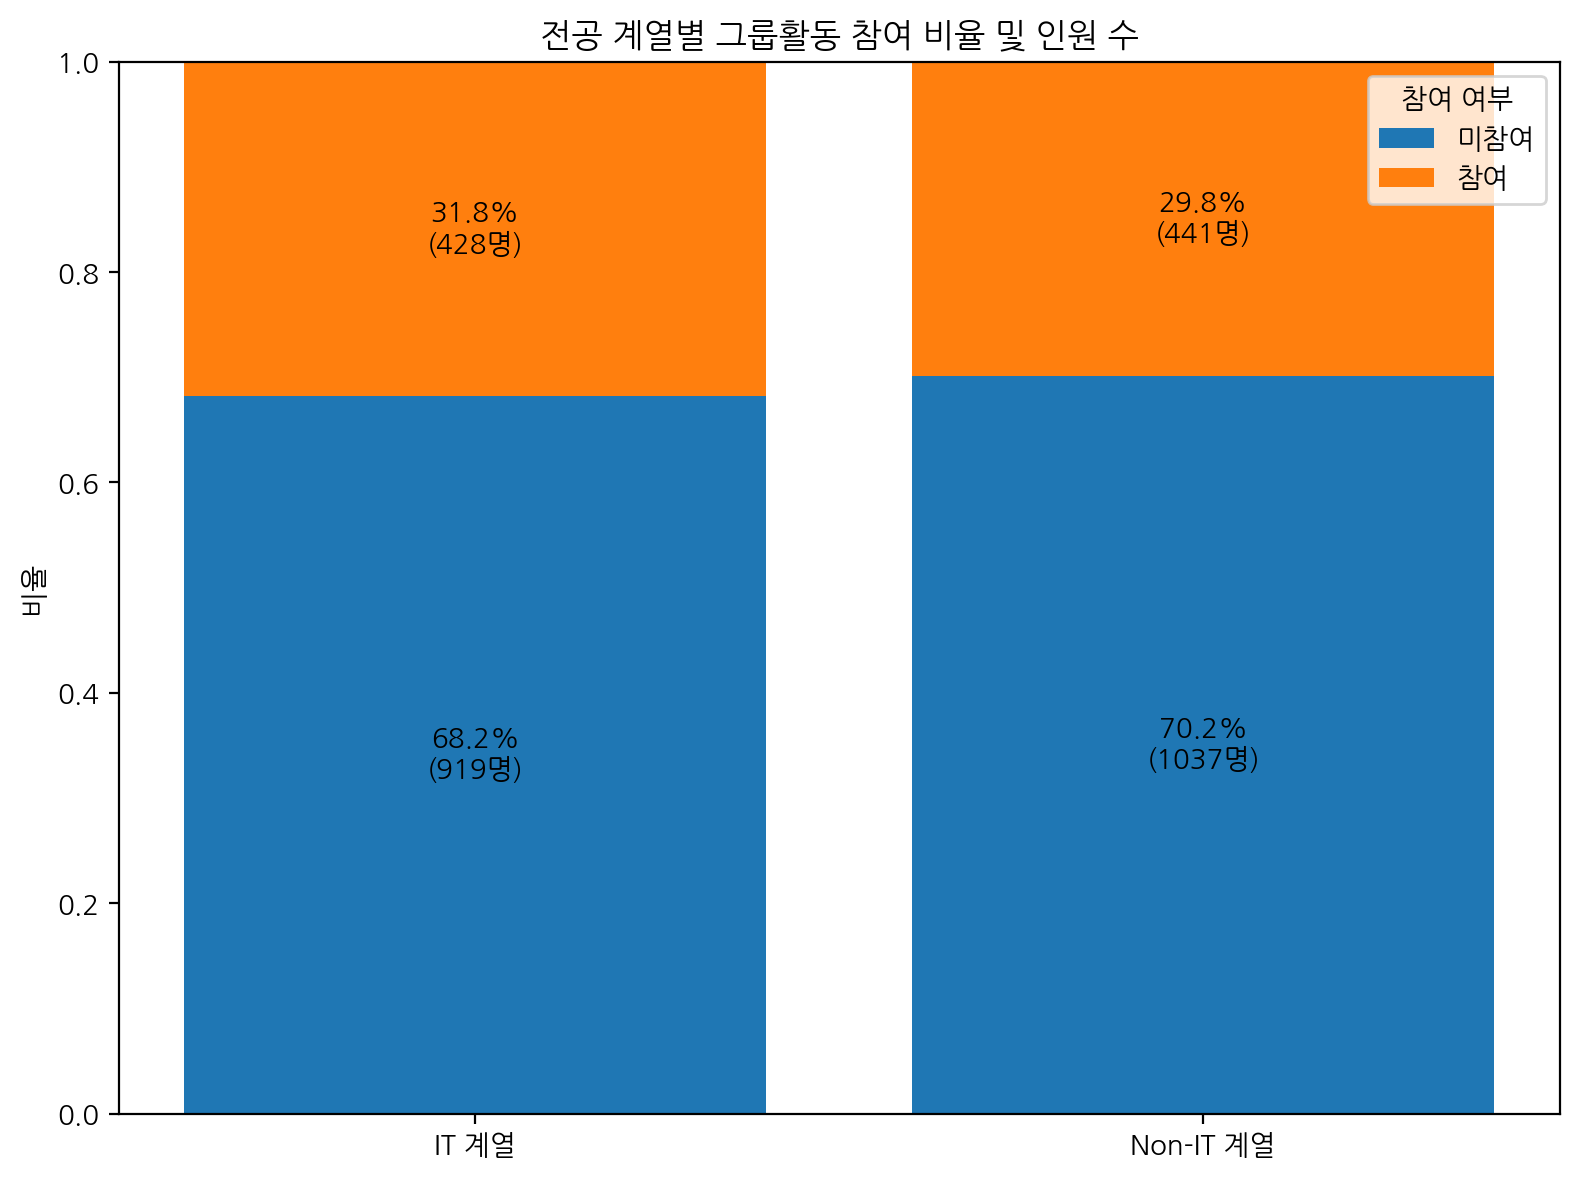

In [ ]:
# 1. 참여여부 라벨 추가
group_yes_labeled = group_yes.copy()
group_no_labeled = group_no.copy()
group_yes_labeled['참여여부'] = '참여'
group_no_labeled['참여여부'] = '미참여'

# 2. 중복 제거: member_id 기준
group_yes_unique = group_yes_labeled.drop_duplicates(subset='member_id')
group_no_unique = group_no_labeled.drop_duplicates(subset='member_id')

# 3. 병합
combined_unique = pd.concat([group_yes_unique, group_no_unique], ignore_index=True)

# 4. 교차표: 전공별 참여여부 인원 수
pivot = combined_unique.pivot_table(
    index='major_group_all',
    columns='참여여부',
    aggfunc='size',
    fill_value=0
)

# 5. 비율로 정규화
pivot_ratio = pivot.div(pivot.sum(axis=1), axis=0)

# 6. 시각화
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['#1f77b4', '#ff7f0e']
bottom = pd.Series([0] * len(pivot_ratio), index=pivot_ratio.index)

for idx, col in enumerate(pivot_ratio.columns):
    bar = ax.bar(
        pivot_ratio.index,
        pivot_ratio[col],
        bottom=bottom,
        label=col,
        color=colors[idx]
    )

    # 막대 위에 텍스트 표시: 비율 + 실제 숫자
    for i, p in enumerate(bar):
        value = pivot_ratio[col].iloc[i]
        count = pivot[col].iloc[i]
        if value > 0:
            ax.text(
                p.get_x() + p.get_width() / 2,
                p.get_y() + p.get_height() / 2,
                f"{value*100:.1f}%\n({count}명)",
                ha='center',
                va='center',
                fontsize=10
            )
    bottom += pivot_ratio[col]

# 그래프 꾸미기
ax.set_ylim(0, 1)
ax.set_ylabel("비율")
ax.set_title("전공 계열별 그룹활동 참여 비율 및 인원 수")
ax.legend(title="참여 여부")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 참여자 활동 특성

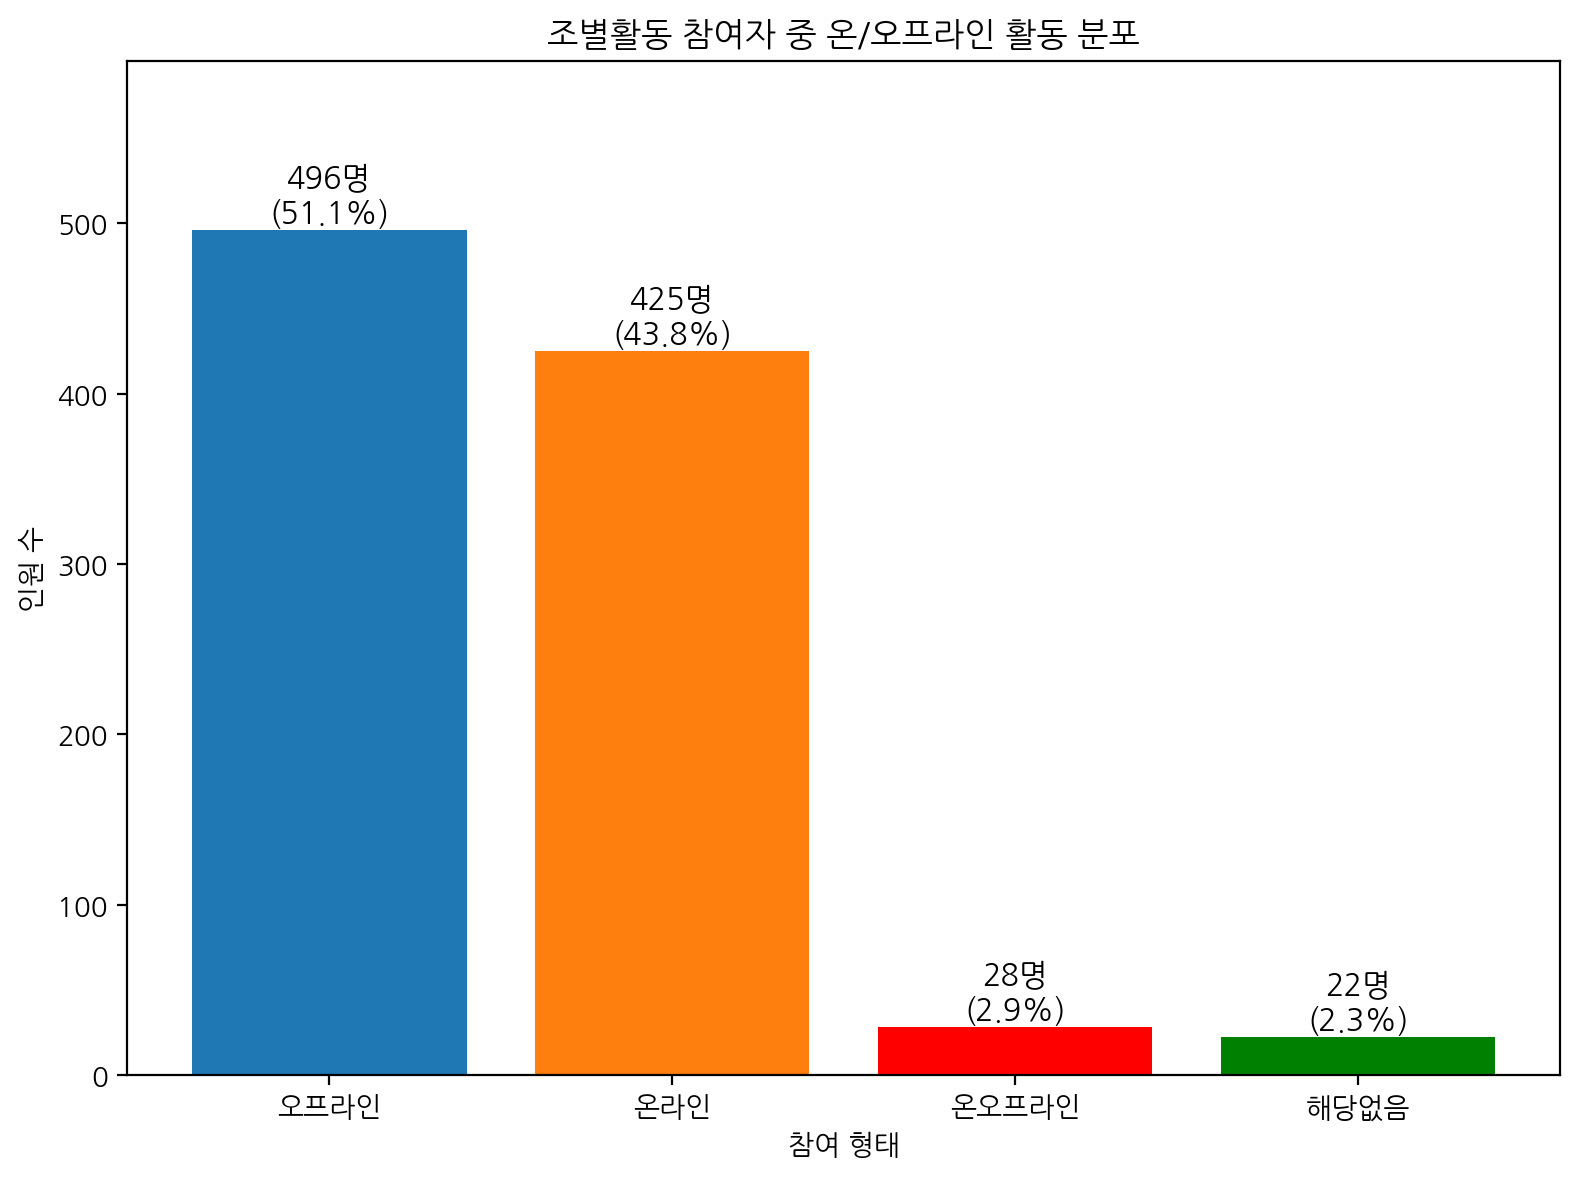

In [ ]:
# 1. 값 개수 세기
on_offline_counts = group_yes['on_offline'].value_counts()

# 2. 레이블과 값
labels = on_offline_counts.index.tolist()
counts = on_offline_counts.values.tolist()
sums = sum(counts)

# 3. 퍼센트 계산
percentages = [f"{count}명\n({count/sums*100:.1f}%)" for count in counts]

# 4. 막대그래프 시각화
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color = ['#1f77b4', '#ff7f0e', 'red', 'green'])

# 5. 막대 위에 개수 + 퍼센트 표시
for bar, label in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # 가운데
        height + 1,                       # 막대 위에
        label,
        ha='center',
        va='bottom',
        fontsize=11
    )

# 6. 그래프 설정
plt.title("조별활동 참여자 중 온/오프라인 활동 분포")
plt.ylabel("인원 수")
plt.xlabel("참여 형태")
plt.ylim(0, max(counts)*1.2)  # 여유 공간 확보
plt.tight_layout()
plt.show()

## 우수조 프로파일링

### 우수조·일반조 점수 분포 현황

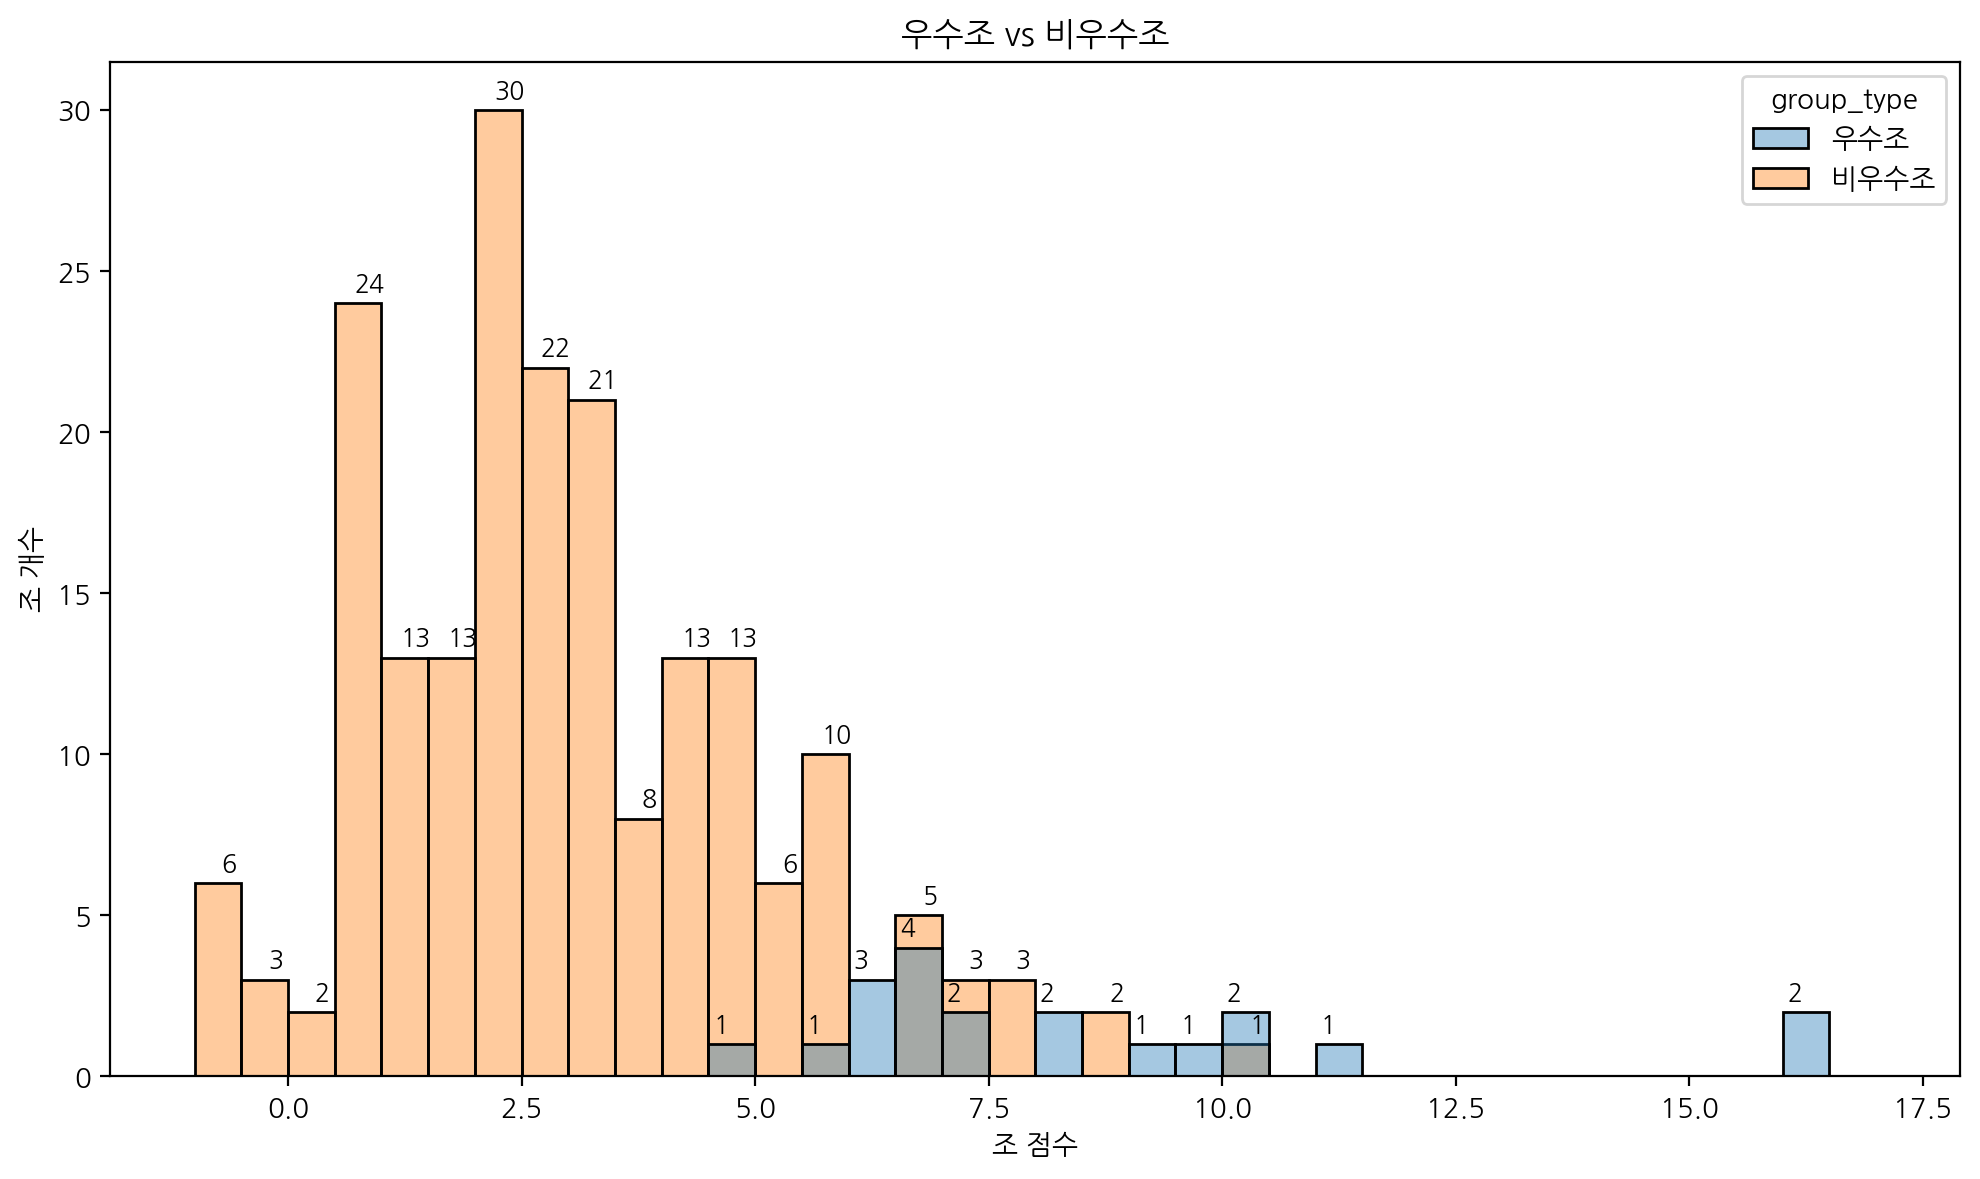

In [ ]:
# ① 조 그룹핑 기준 키 정의
keys = ["generation", "class_code", "group_number"]

# ② 조 단위로 총점(point_sum)과 인원수(group_size=nunique) 집계
agg_group = (
    group_yes_point.groupby(keys, dropna=False)
       .agg(
           point_sum=("point", "sum"),
           group_size=("member_id", "nunique")
       )
       .reset_index()
)

# ③ 우수조 여부 판정: 같은 조 내에 1이 하나라도 있으면 우수조(True)
excellent_flag = (
    group_yes_point.assign(_is_exc=(group_yes_point["excellent_group"].astype(str) == "1"))
       .groupby(keys, dropna=False)["_is_exc"]
       .any()
       .reset_index()
       .rename(columns={"_is_exc": "is_excellent"})
)

# ④ 병합 + 파생컬럼 생성 (group_point, excellent_group, group_type)
df_group_clean = (
    agg_group.merge(excellent_flag, on=keys, how="left")
             .assign(
                 excellent_group=lambda d: np.where(d["is_excellent"], "1", "0"),
                 group_point=lambda d: np.where(
                     d["group_size"] > 0,
                     d["point_sum"] / d["group_size"],
                     np.nan
                 ),
                 group_type=lambda d: np.where(
                     d["is_excellent"], "우수조", "비우수조"
                 )
             )
             .drop(columns=["is_excellent"])
)

# ⑤ 시각화를 위한 히스토그램 bin 간격 및 범위 계산
df_plot = df_group_clean.dropna(subset=["group_point"]).copy()
binwidth = 0.5

gmin = np.floor(df_plot["group_point"].min() / binwidth) * binwidth
gmax = np.ceil(df_plot["group_point"].max() / binwidth) * binwidth

edges = np.arange(gmin, gmax + binwidth + 1e-9, binwidth)         # bin 경계값
bin_centers = (edges[:-1] + edges[1:]) / 2                        # bin 중심값

# ⑥ 겹침형 히스토그램 그리기 (우수조 vs 비우수조)
plt.figure(figsize=(10,6))
ax = sns.histplot(
    data=df_plot,
    x="group_point",
    hue="group_type",
    hue_order=["우수조", "비우수조"],
    bins=edges,
    multiple="layer",
    kde=False,
    alpha=0.4
)

# ⑦ bin 단위로 직접 count 계산 후 막대 위에 숫자 표시
counts_exc = pd.cut(
    df_plot.loc[df_plot["group_type"] == "우수조", "group_point"],
    bins=edges, right=False, include_lowest=True
).value_counts().sort_index()

counts_non = pd.cut(
    df_plot.loc[df_plot["group_type"] == "비우수조", "group_point"],
    bins=edges, right=False, include_lowest=True
).value_counts().sort_index()

offset_exc = -0.12   # 우수조 숫자 좌측으로 약간 이동
offset_non = +0.12   # 비우수조 숫자 우측으로 약간 이동
y_offset = 0.2       # 막대 위 여유 간격

for x, c in zip(bin_centers, counts_exc.values):
    if c > 0:
        ax.text(
            x + offset_exc, c + y_offset,
            str(int(c)),
            ha="center", va="bottom", fontsize=9
        )

for x, c in zip(bin_centers, counts_non.values):
    if c > 0:
        ax.text(
            x + offset_non, c + y_offset,
            str(int(c)),
            ha="center", va="bottom", fontsize=9
        )

# ⑧ 그래프 제목 및 라벨 설정
plt.title("우수조 vs 비우수조")
plt.xlabel("조 점수")
plt.ylabel("조 개수")
plt.tight_layout()
plt.show()

### 개인특성별 우수조·일반조·미참여 비교 분석

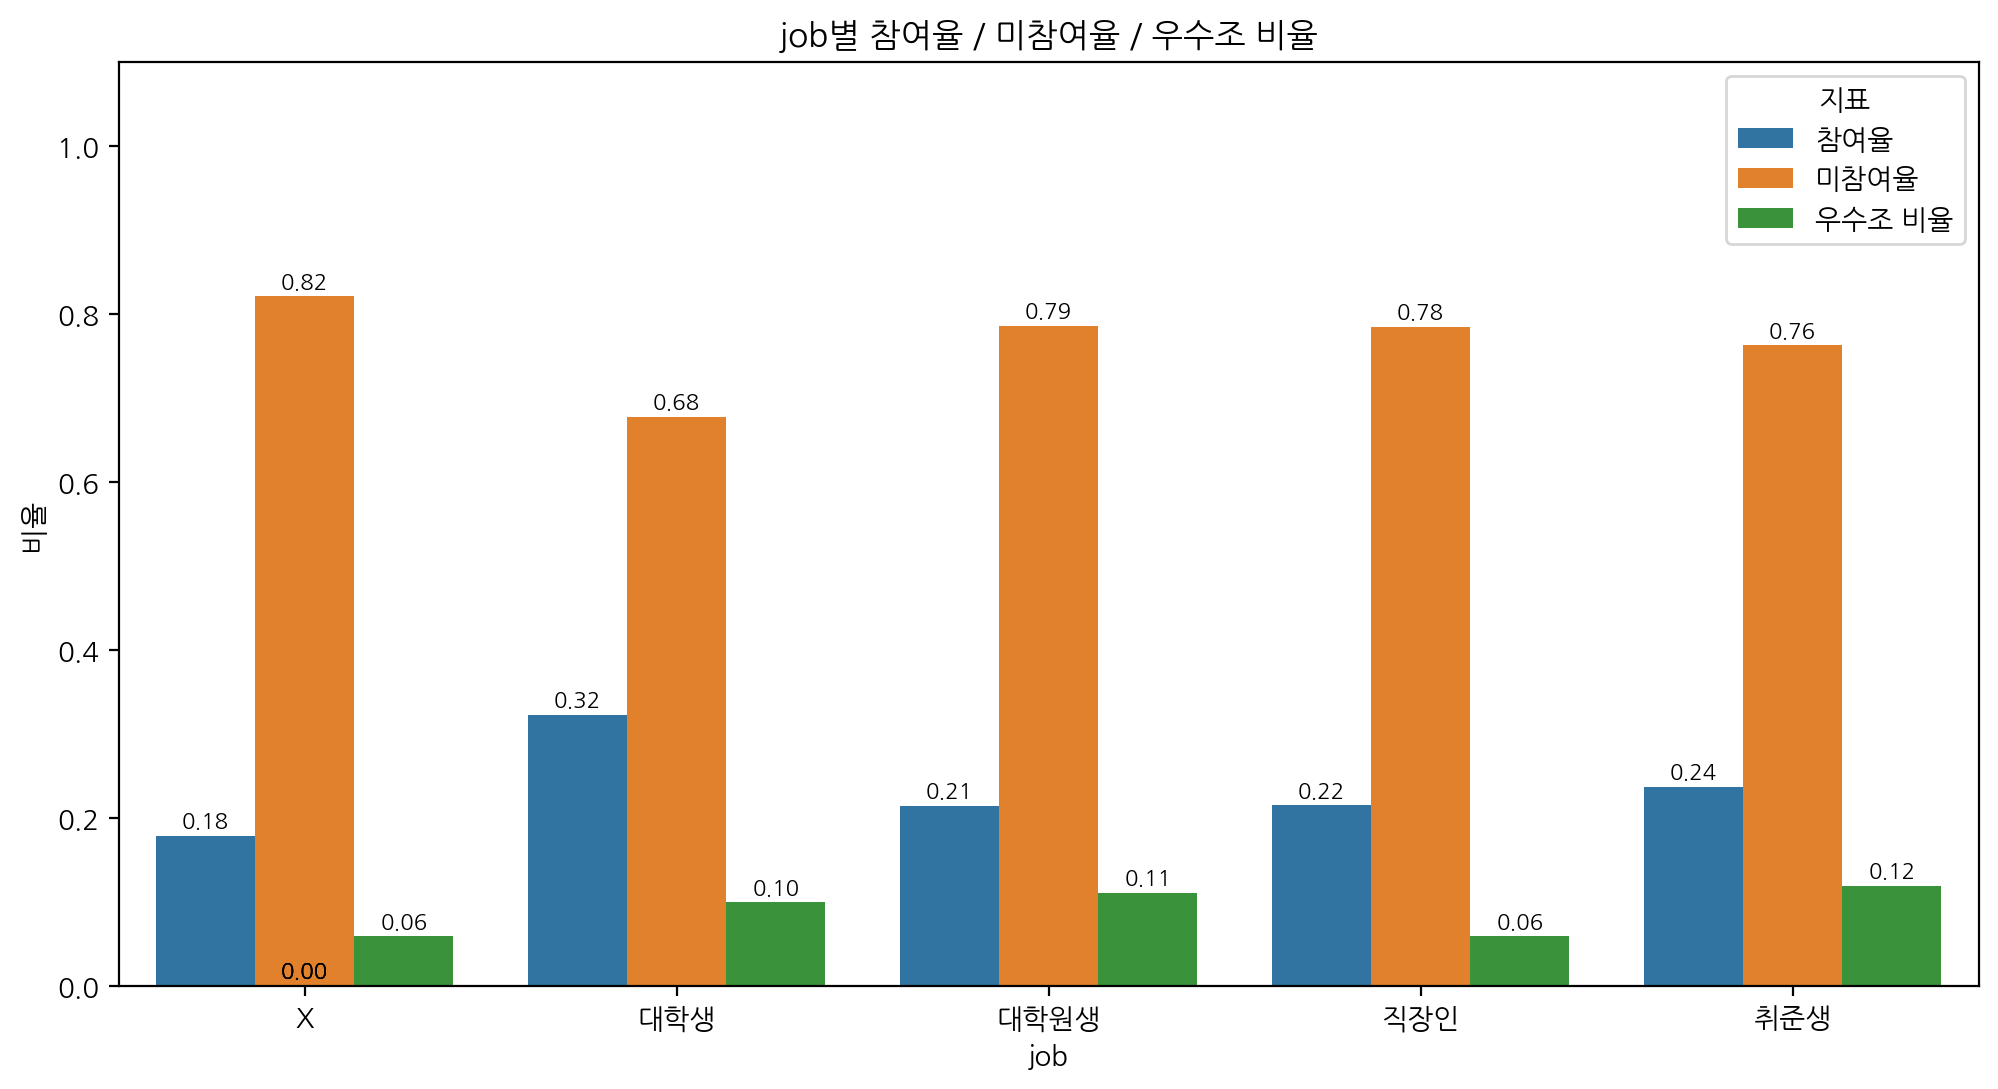

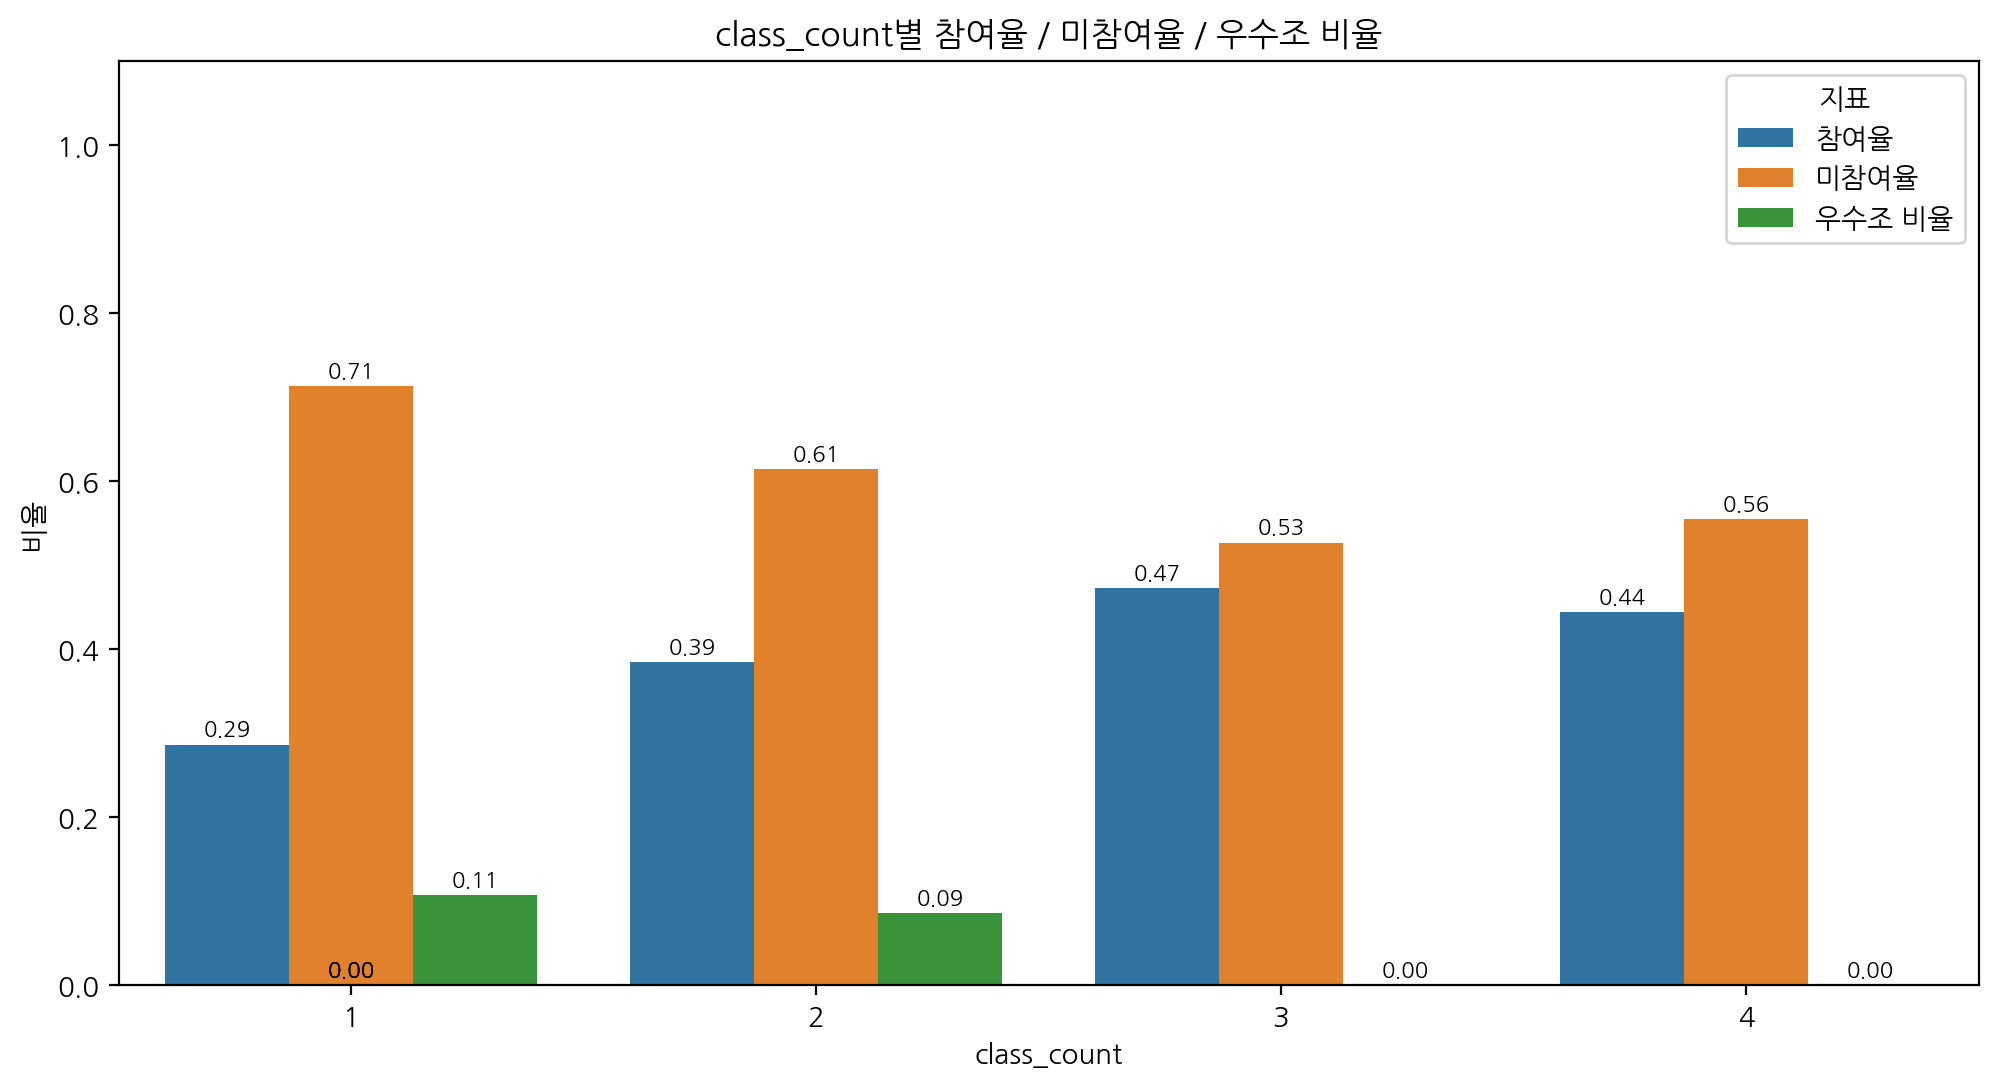

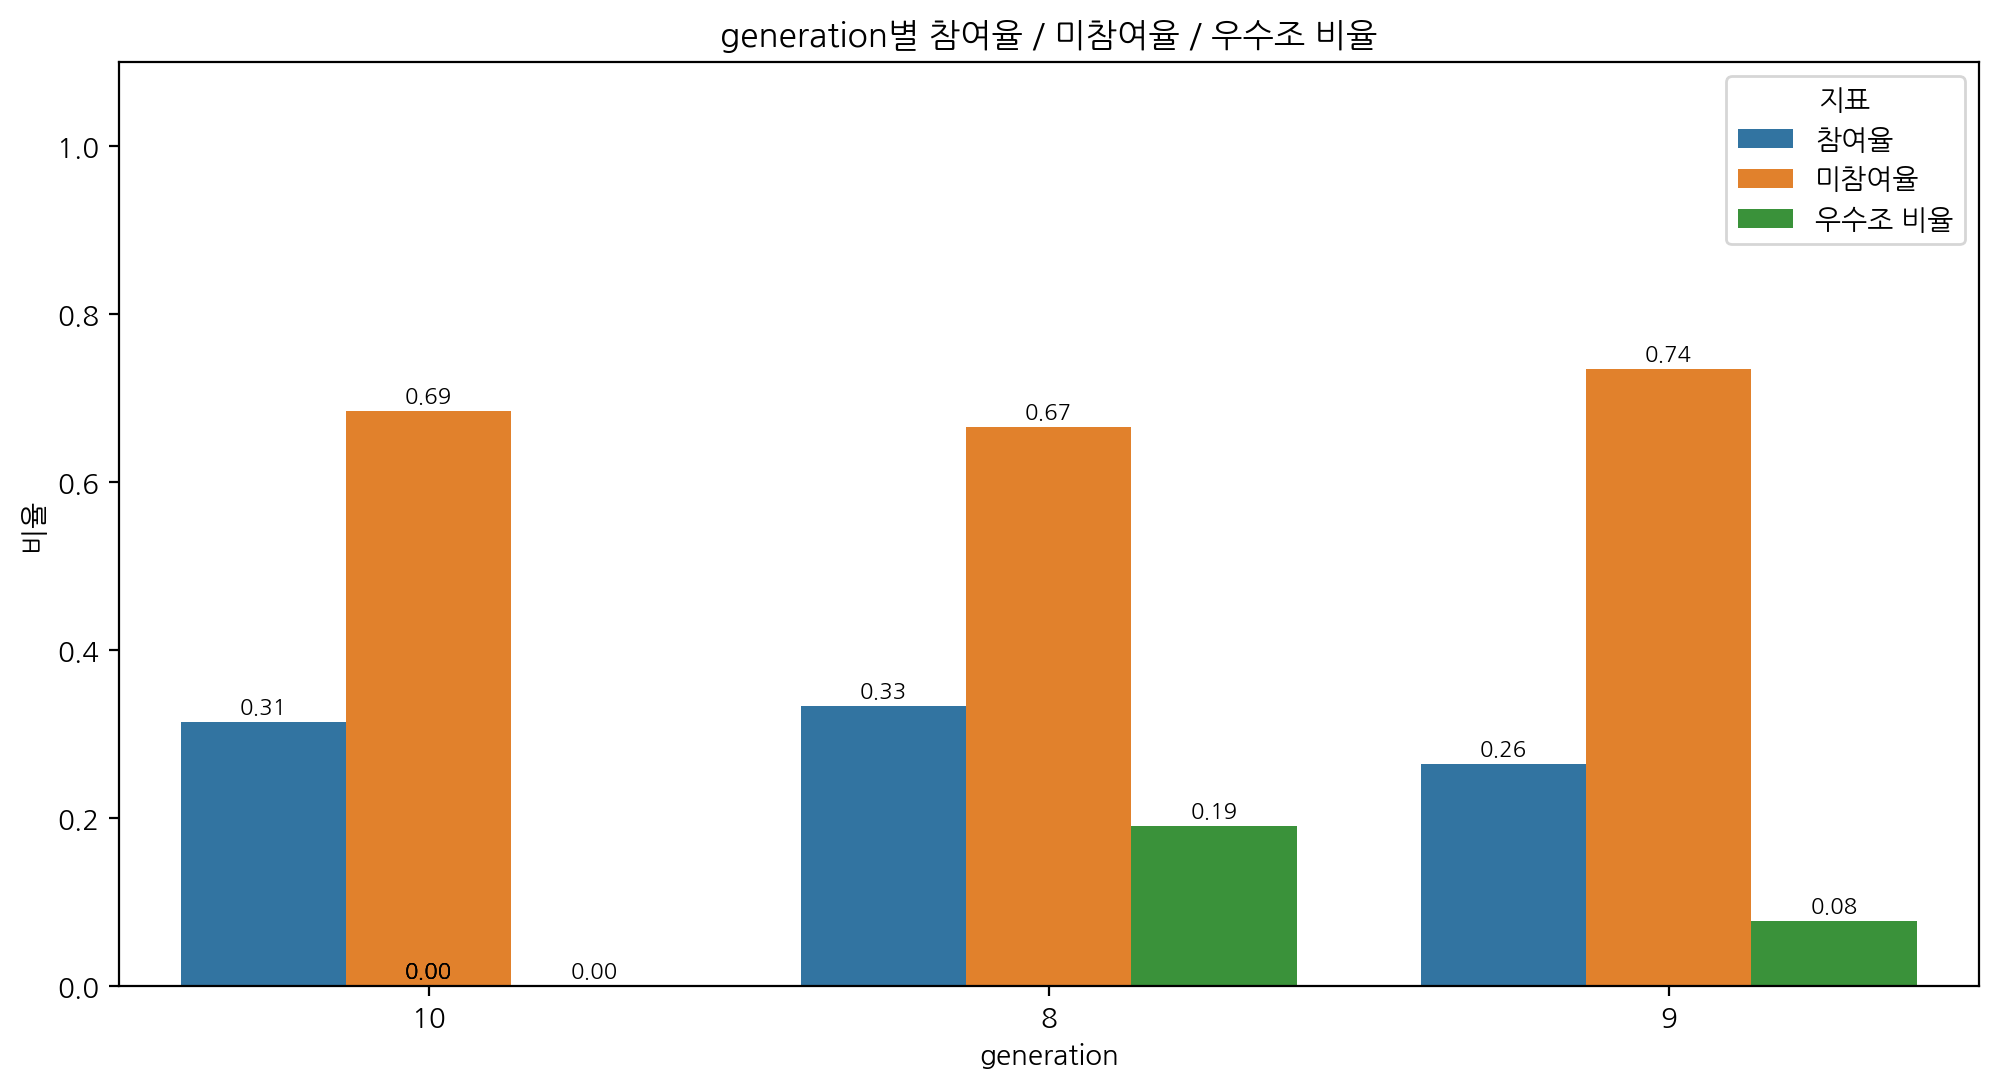

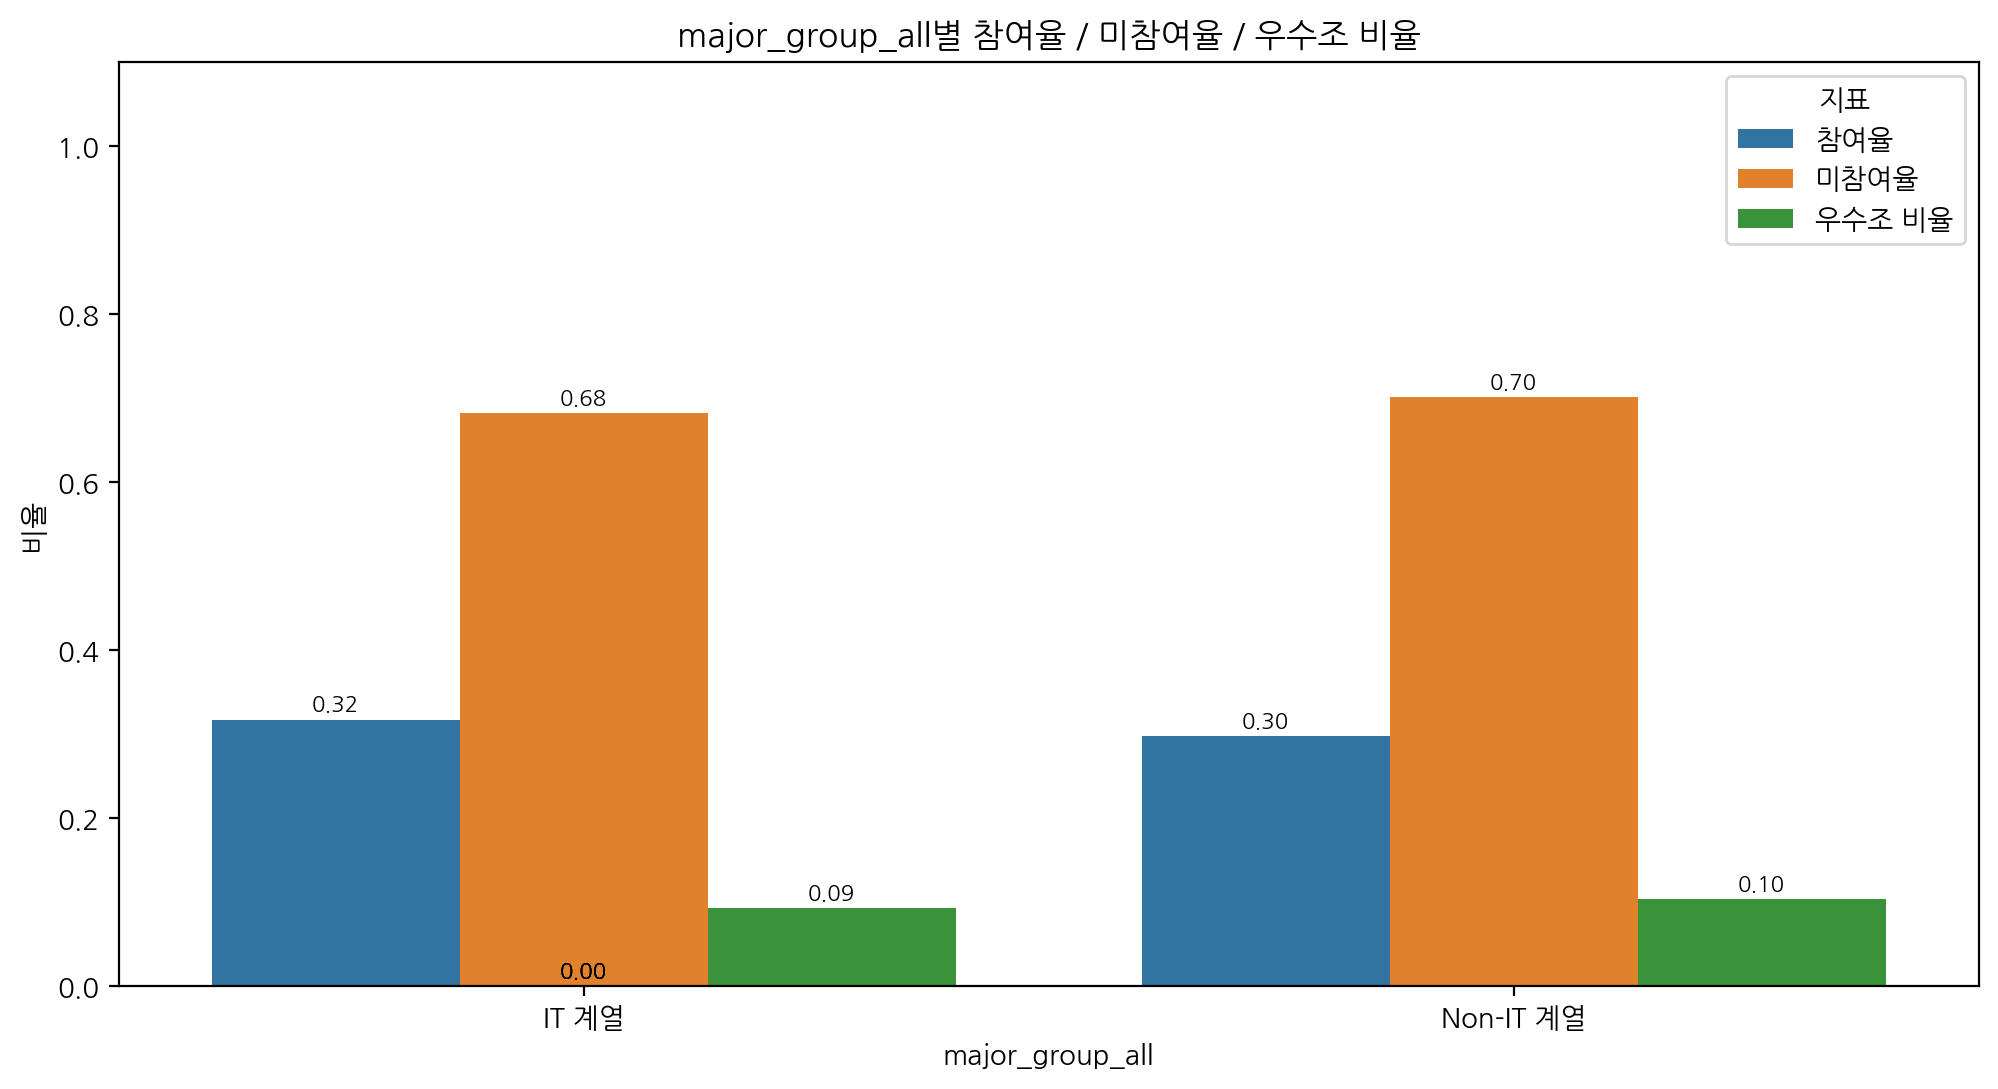

In [ ]:
for df in [group_yes, group_no]:
    # class1 ~ class4에서 '0'가 아닌 항목 개수 세기
    df['class_count'] = df[['class1','class2','class3','class4']].apply(
        lambda row: (row != '0').sum(), axis=1
    )

# --- 우수조 여부 판정 ---
excellent_flag = (
    group_yes.assign(_is_exc=(group_yes["excellent_group"].astype(str) == "1"))
       .groupby(keys, dropna=False)["_is_exc"]
       .any()
       .reset_index()
       .rename(columns={"_is_exc": "is_excellent"})
)

# member_id 기준으로 중복 제거
group_yes_unique = group_yes.drop_duplicates(subset=['member_id'])
group_no_unique = group_no.drop_duplicates(subset=['member_id'])

# group_yes_unique 에 우수조 여부 붙이기
group_yes_unique = group_yes_unique.merge(excellent_flag, on=keys, how="left")

columns = ['job', 'class_count', 'generation', 'major_group_all']

for col in columns:
    # 전체 집단 (참여+미참여)
    total_count = pd.concat([group_yes_unique[[col,'member_id']],
                             group_no_unique[[col,'member_id']]]).groupby(col)['member_id'].nunique()

    # 참여 집단
    yes_count = group_yes_unique.groupby(col)['member_id'].nunique()

    # 미참여 집단
    no_count = group_no_unique.groupby(col)['member_id'].nunique()

    # 우수조 집단 (참여자 중 is_excellent=True)
    excellent_count = group_yes_unique[group_yes_unique['is_excellent']].groupby(col)['member_id'].nunique()

    # 하나의 DF로 합치기
    summary_df = pd.DataFrame({
        'total': total_count,
        '참여': yes_count,
        '미참여': no_count,
        '우수조': excellent_count
    }).fillna(0)

    # 비율 계산
    summary_df['참여율'] = summary_df['참여'] / summary_df['total']
    summary_df['미참여율'] = summary_df['미참여'] / summary_df['total']
    summary_df['우수조 비율'] = summary_df['우수조'] / summary_df['참여']  # 참여자 중 비율

    # 시각화를 위해 long format으로 변환
    plot_df = summary_df[['참여율','미참여율','우수조 비율']].reset_index().melt(
        id_vars=col, var_name='metric', value_name='rate'
    )

    # 시각화
    plt.figure(figsize=(12,6))
    ax = sns.barplot(
        data=plot_df,
        x=col,
        y='rate',
        hue='metric'
    )

    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width()/2,
            y=height + 0.01,
            s=f'{height:.2f}',
            ha='center',
            fontsize=8
        )

    plt.title(f"{col}별 참여율 / 미참여율 / 우수조 비율")
    plt.ylabel("비율")
    plt.ylim(0,1.1)
    plt.legend(title="지표")
    plt.show()


### 우수조·일반조 점수 성장 추세 비교

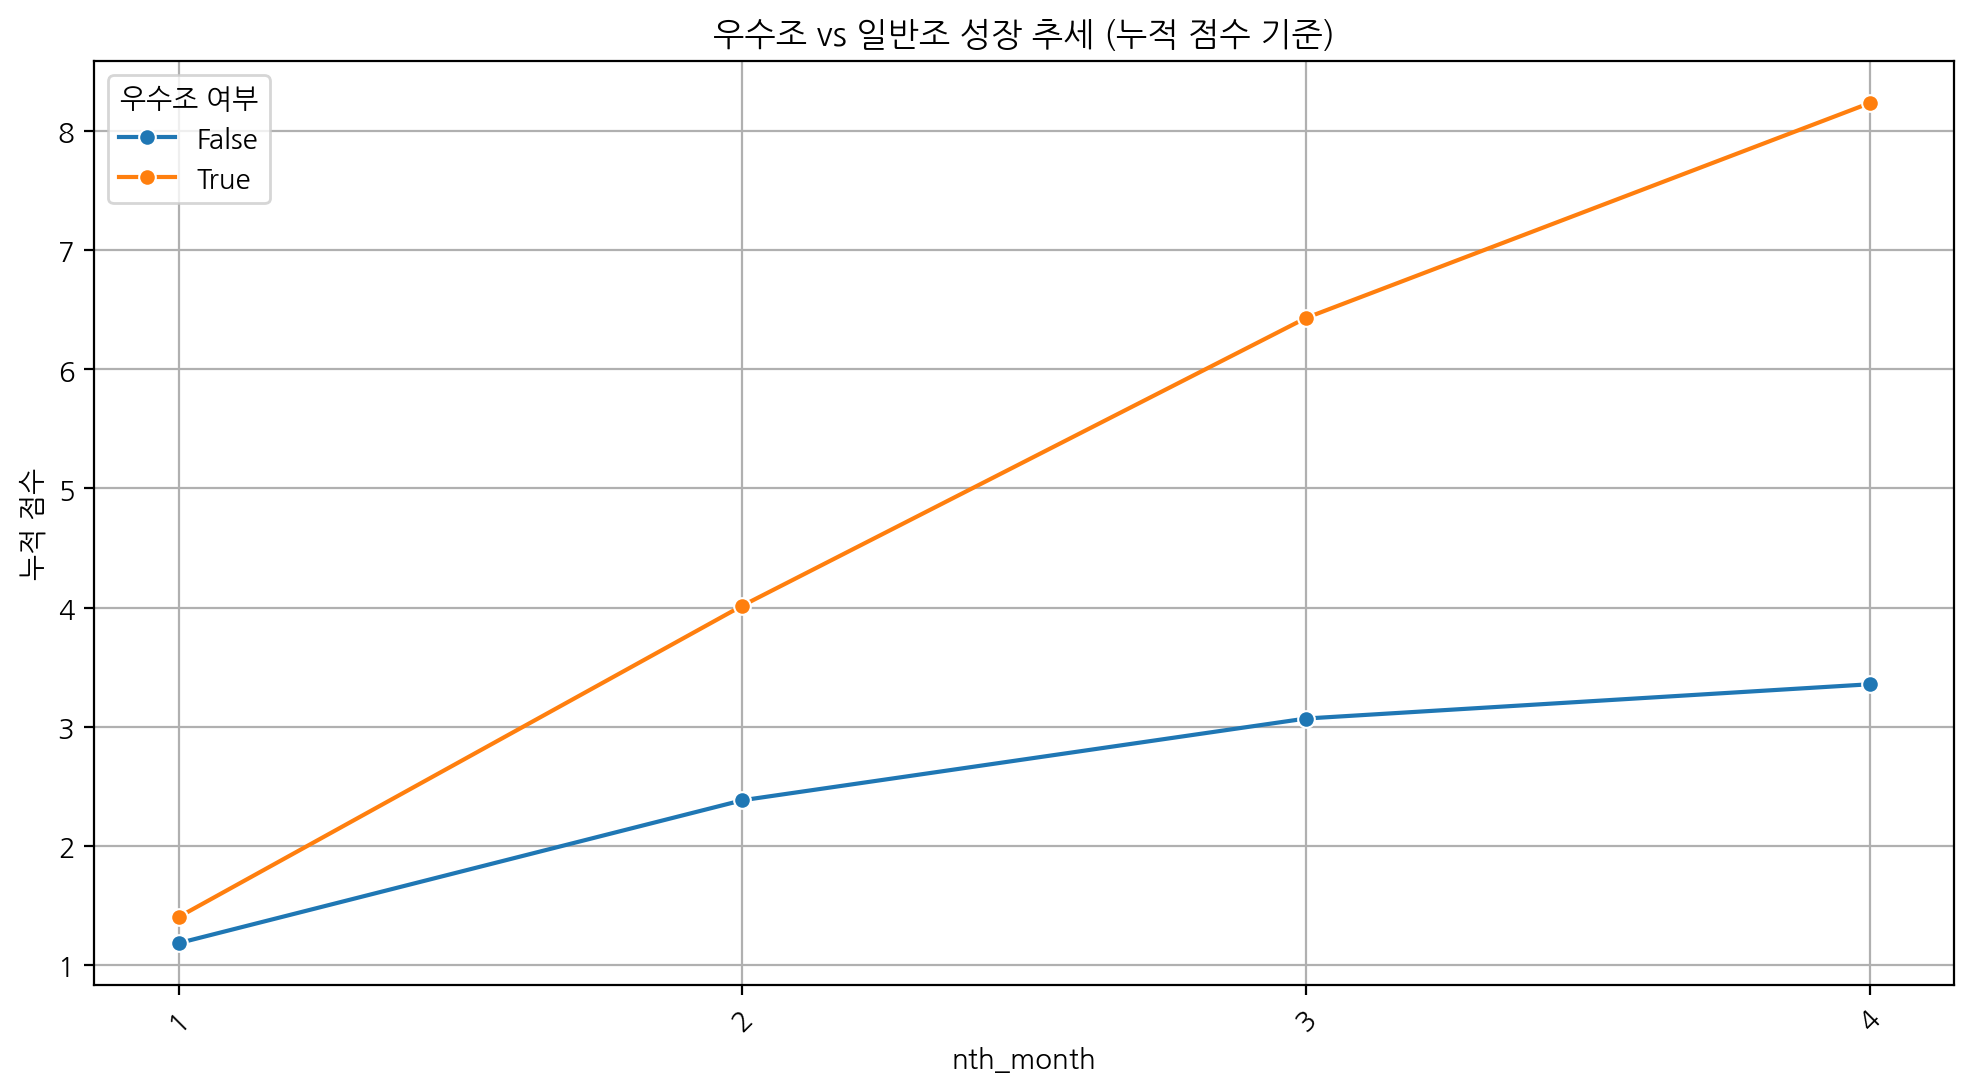

In [ ]:
# -----------------------------
# 1) 조 단위 우수조 여부 판정
# -----------------------------
excellent_flag = (
    group_yes.assign(_is_exc=(group_yes["excellent_group"].astype(str) == "1"))
       .groupby(keys, dropna=False)["_is_exc"]
       .any()
       .reset_index()
       .rename(columns={"_is_exc": "is_excellent"})
)

# group_yes_point 에 우수조 여부 붙이기
group_yes_point = group_yes_point.merge(excellent_flag, on=keys, how="left")

# -----------------------------
# 2) nth_month 기준 점수 합계 계산
# -----------------------------
growth_df = group_yes_point.groupby(['nth_month','is_excellent']).agg(
    total_point=('point','sum'),
    mean_point=('point','mean')
).reset_index()

# -----------------------------
# 3) 누적 점수 계산
# -----------------------------
growth_df['cumulative_point'] = growth_df.groupby('is_excellent')['mean_point'].cumsum()

# -----------------------------
# 4) 성장 추세 시각화
# -----------------------------
plt.figure(figsize=(12,6))
sns.lineplot(
    data=growth_df,
    x='nth_month',
    y='cumulative_point',  # 또는 total_point
    hue='is_excellent',
    marker='o'
)
plt.title('우수조 vs 일반조 성장 추세 (누적 점수 기준)')
plt.xlabel('nth_month')
plt.ylabel('누적 점수')
plt.xticks(rotation=45)
plt.legend(title='우수조 여부')
plt.grid(True)
plt.show()


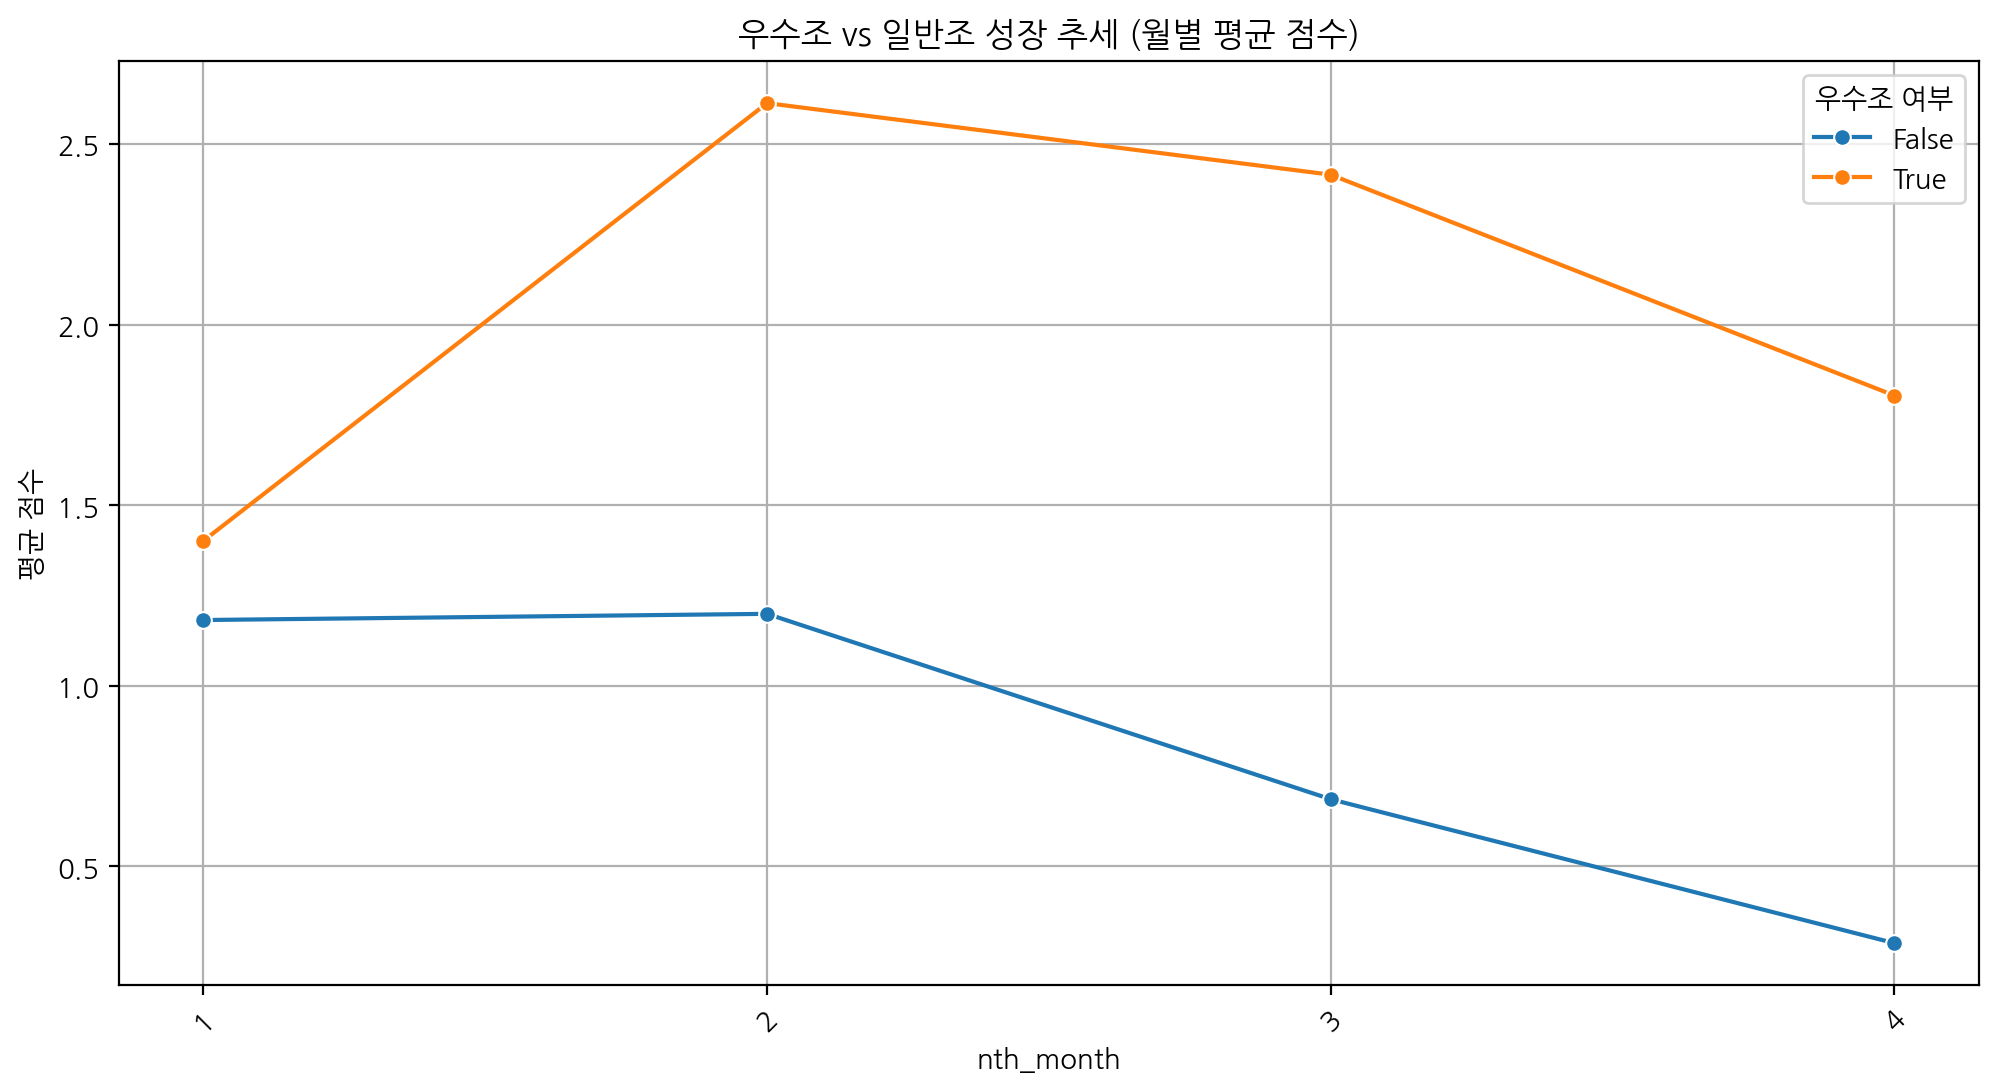

In [ ]:
# -----------------------------
# 1) 조 단위 우수조 여부 판정
# -----------------------------
excellent_flag = (
    group_yes.assign(_is_exc=(group_yes["excellent_group"].astype(str) == "1"))
       .groupby(keys, dropna=False)["_is_exc"]
       .any()
       .reset_index()
       .rename(columns={"_is_exc": "is_excellent"})
)

# group_yes_point에 우수조 여부 붙이기
if "is_excellent" in group_yes_point.columns:
    group_yes_point = group_yes_point.drop(columns=["is_excellent"])

group_yes_point = group_yes_point.merge(excellent_flag, on=keys, how="left")

# -----------------------------
# 2) nth_month 기준 평균 점수 계산
# -----------------------------
growth_df = group_yes_point.groupby(['nth_month','is_excellent']).agg(
    mean_point=('point','mean')
).reset_index()

# -----------------------------
# 3) lineplot으로 성장 추세 시각화
# -----------------------------
plt.figure(figsize=(12,6))
sns.lineplot(
    data=growth_df,
    x='nth_month',
    y='mean_point',
    hue='is_excellent',
    marker='o'
)
plt.title('우수조 vs 일반조 성장 추세 (월별 평균 점수)')
plt.xlabel('nth_month')
plt.ylabel('평균 점수')
plt.xticks(rotation=45)
plt.legend(title='우수조 여부')
plt.grid(True)
plt.show()


### 우수조·일반조 나이 분포 비교 분석

In [ ]:
# -----------------------------
# 1) member_id 기준 중복 제거
# -----------------------------
group_yes_unique = group_yes.drop_duplicates(subset=['member_id'])

# 복사본 생성
group_yes_age_dist_unique = group_yes_unique.copy()
group_yes_age_dist = group_yes.copy()

# -----------------------------
# 2) 조 단위 우수조 여부 판정
# -----------------------------
excellent_flag = (
    group_yes.assign(_is_exc=(group_yes["excellent_group"].astype(str) == "1"))
       .groupby(keys, dropna=False)["_is_exc"]
       .any()
       .reset_index()
       .rename(columns={"_is_exc": "is_excellent"})
)

# -----------------------------
# 3) 두 DF에 우수조 여부 + 전처리
# -----------------------------
for df_name, df in [("unique", group_yes_age_dist_unique), ("dist", group_yes_age_dist)]:
    # 기존 is_excellent 있으면 삭제
    if "is_excellent" in df.columns:
        df = df.drop(columns=["is_excellent"])

    # merge (inplace 불가 → 재할당)
    df = df.merge(excellent_flag, on=keys, how="left")

    # 나이 계산
    df['age'] = datetime.now().year - pd.to_datetime(df['birthday'], errors='coerce').dt.year

    # school 전처리
    df['school2_proc'] = df['school2'].apply(lambda x: 1 if x != 'X' else 0)
    df['school1_proc'] = np.where(
        (df['job'] == '대학생') & (df['school2'] == 'X'),
        1,
        0
    )

    def process_school(row):
        if row['school2_proc'] == 1:   # 학부
            return 'Undergraduate'
        elif row['school1_proc'] == 1: # 대학원
            return 'Graduate'
        else:                          # 둘 다 아니면
            return 'Other'

    df['school_type'] = df.apply(process_school, axis=1)

    # 다시 변수에 저장
    if df_name == "unique":
        group_yes_age_dist_unique = df
    else:
        group_yes_age_dist = df


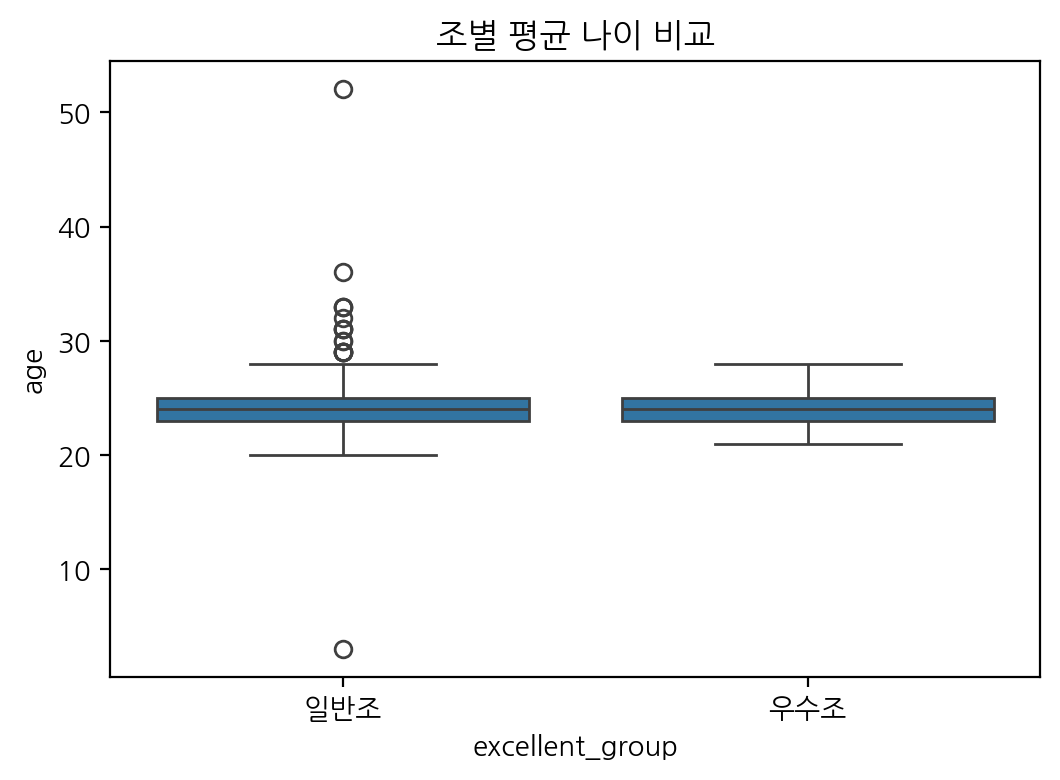

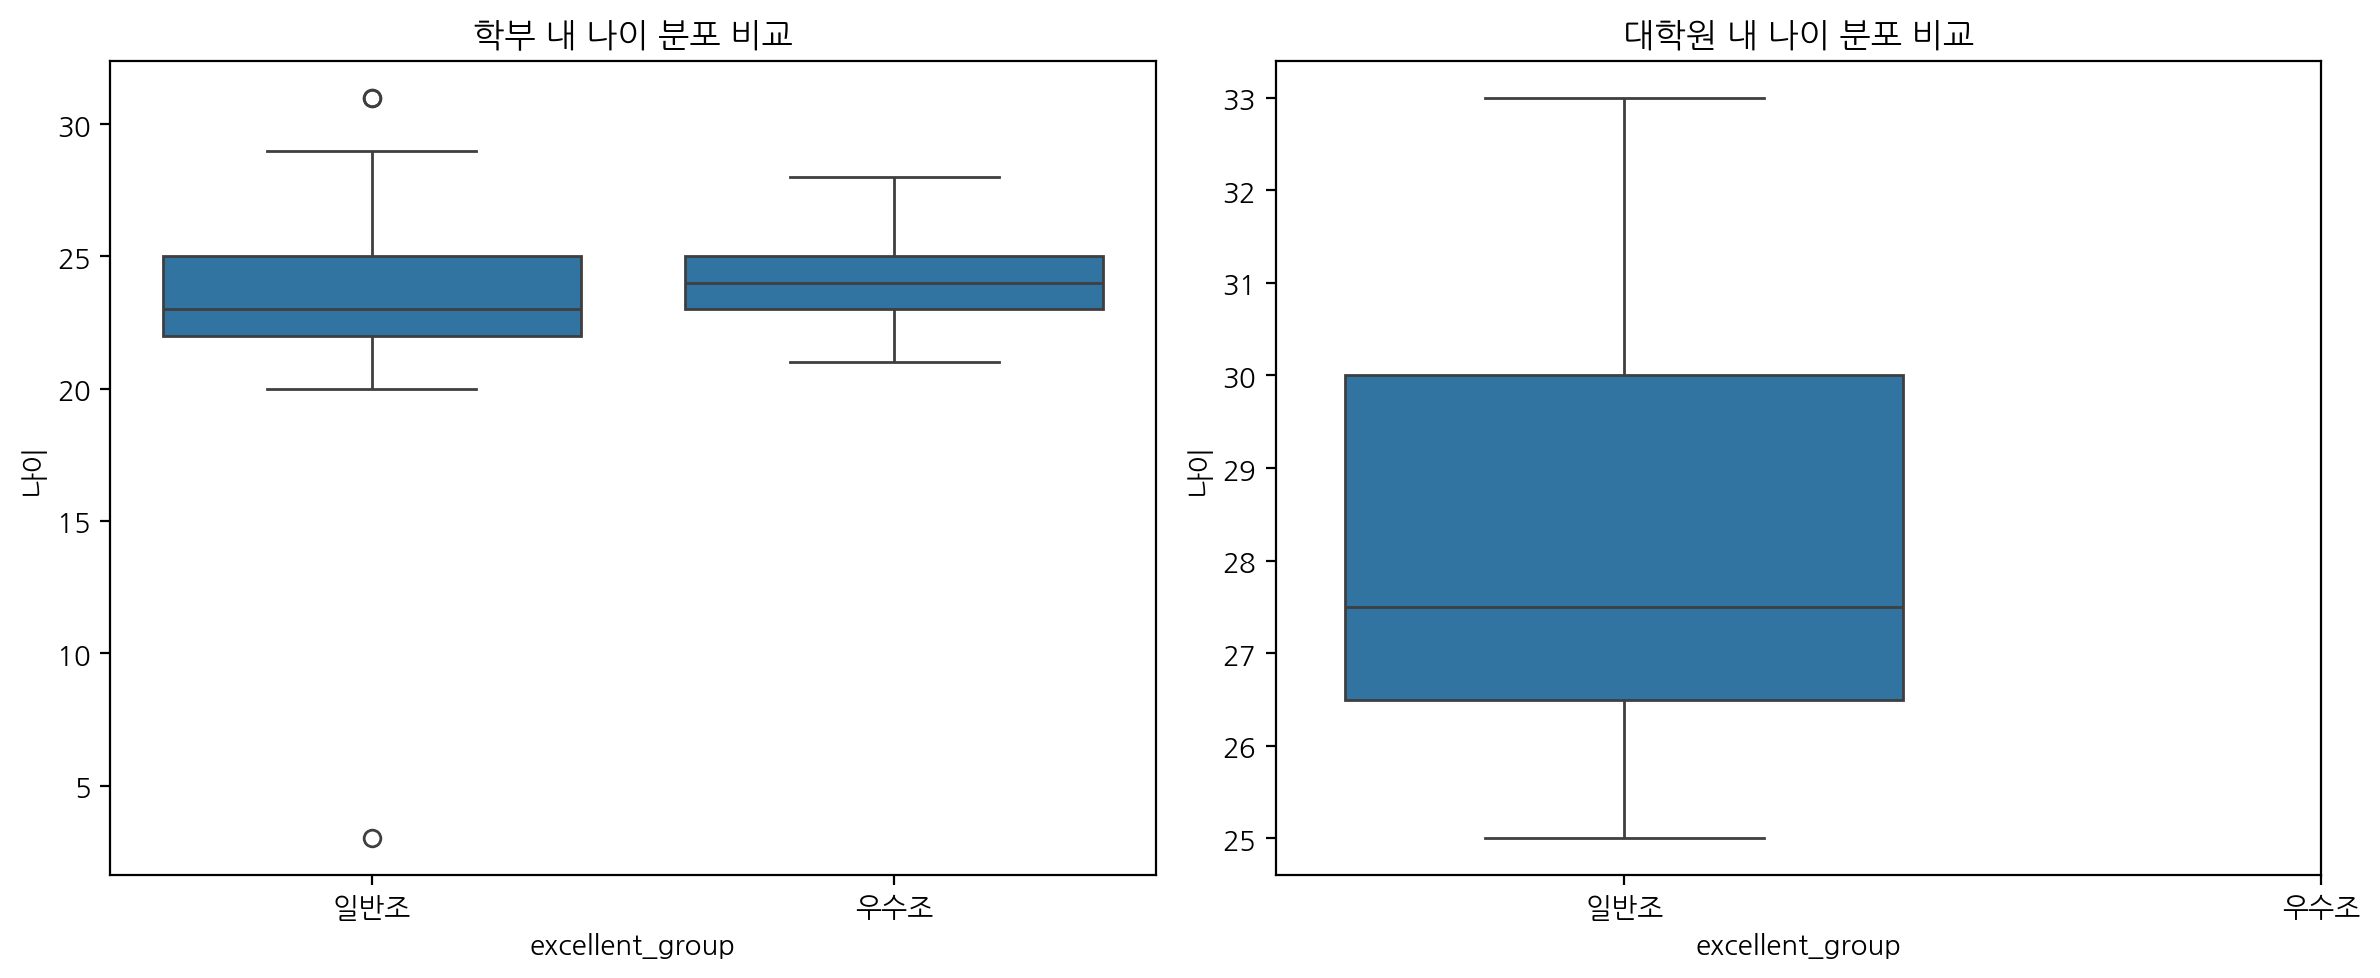

In [ ]:
# 평균 나이 비교
plt.figure(figsize=(6,4))
sns.boxplot(data=group_yes_age_dist, x='excellent_group', y='age')
plt.xticks([0,1], ['일반조', '우수조'])
plt.title('조별 평균 나이 비교')
plt.show()

# 학부/대학원 비율 비교
fig, axes = plt.subplots(1,2, figsize=(12,5))

# 학부
sns.boxplot(
    data=group_yes_age_dist[group_yes_age_dist['school1_proc'] == 1],
    x='excellent_group',
    y='age',
    ax=axes[0]
)
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(['일반조', '우수조'])
axes[0].set_ylabel('나이')
axes[0].set_title('학부 내 나이 분포 비교')

# 대학원
sns.boxplot(
    data=group_yes_age_dist[group_yes_age_dist['school2_proc'] == 1],
    x='excellent_group',
    y='age',
    ax=axes[1]
)
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['일반조', '우수조'])
axes[1].set_ylabel('나이')
axes[1].set_title('대학원 내 나이 분포 비교')

plt.tight_layout()
plt.show()


## 조별활동 이탈자 프로파일링

### 탈퇴 시점

▶ [탈퇴자만] 탈퇴 시점 분포


,leave_point,leavers,share
0,중간 휴회기간 이후,45,0.3982
1,중간 휴회기간 이전,31,0.2743
2,기말 휴회기간 이후,29,0.2566
3,확인 불가,8,0.0708


▶ 온/오프라인별 탈퇴율 (행 기준)


,n,leave_cnt,leave_rate
on_offline,,,
해당없음,22,22,100.0
온오프라인,28,4,14.3
온라인,425,52,12.2
오프라인,496,35,7.1


▶ 조장 여부별 탈퇴율 (행 기준)


,n,leave_cnt,leave_rate
group_master,,,
0,739,93,12.6
1,232,20,8.6


▶ 전공별 탈퇴율 (개인 기준, major_group_all)


,n,leavers,leave_rate
major_group_all,,,
IT 계열,428,56,13.1
Non-IT 계열,441,52,11.8


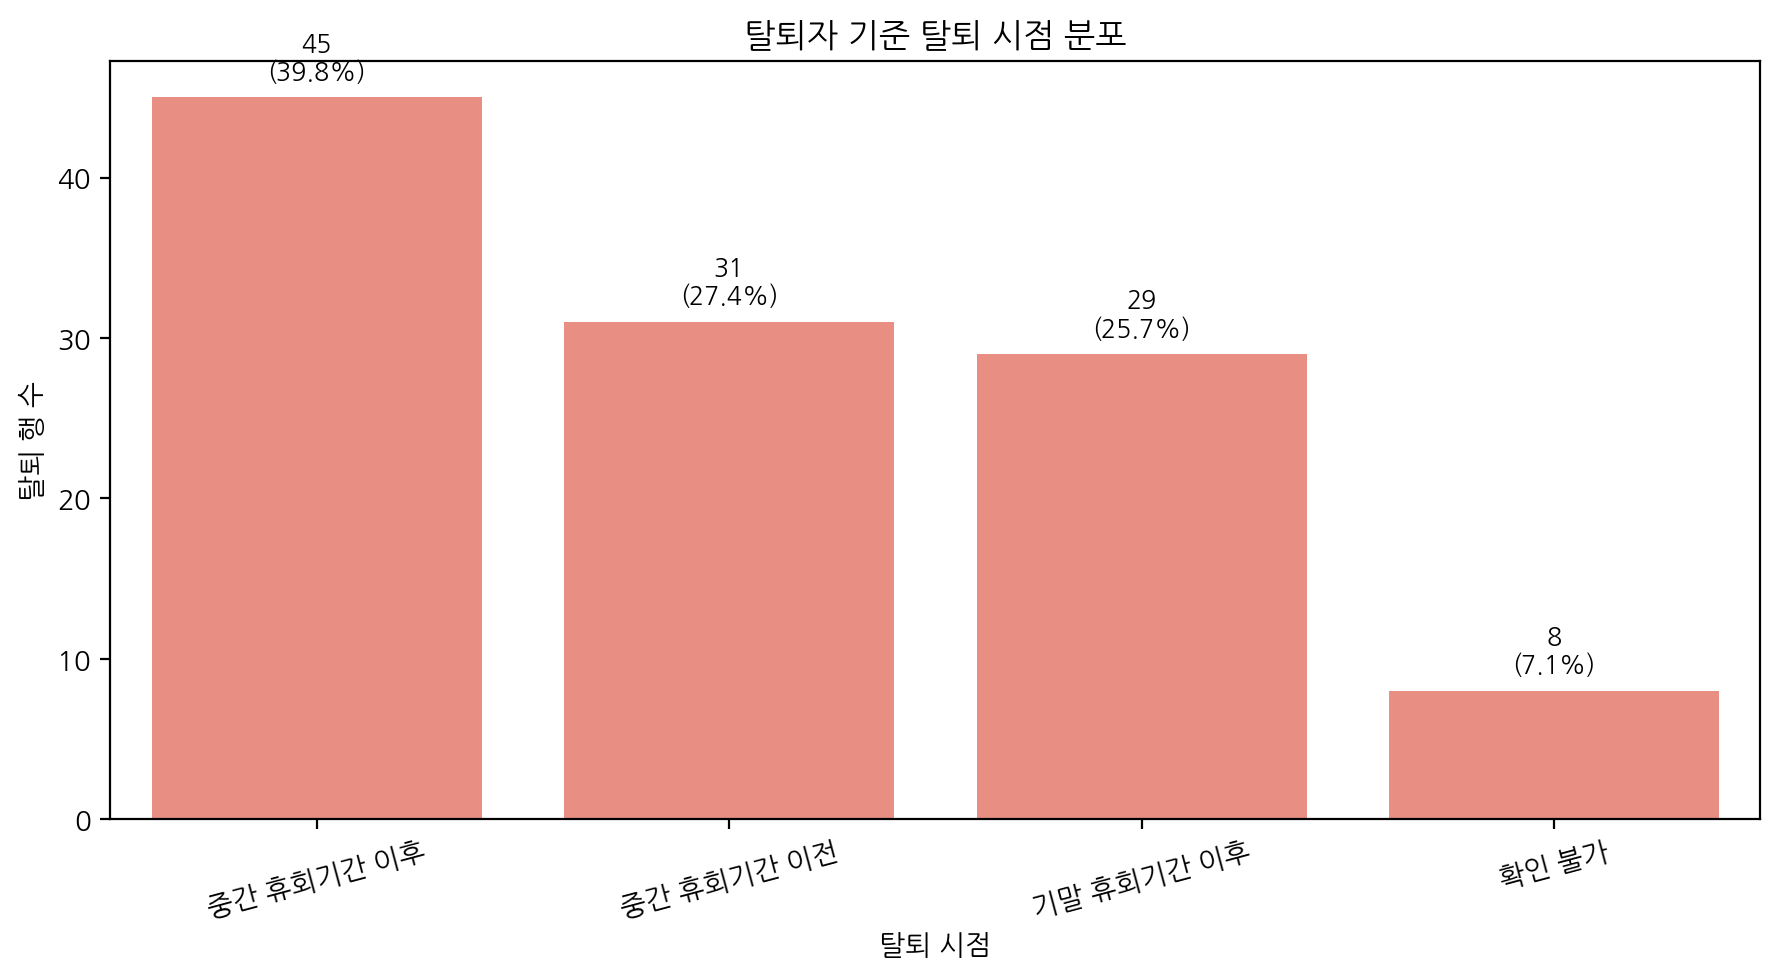

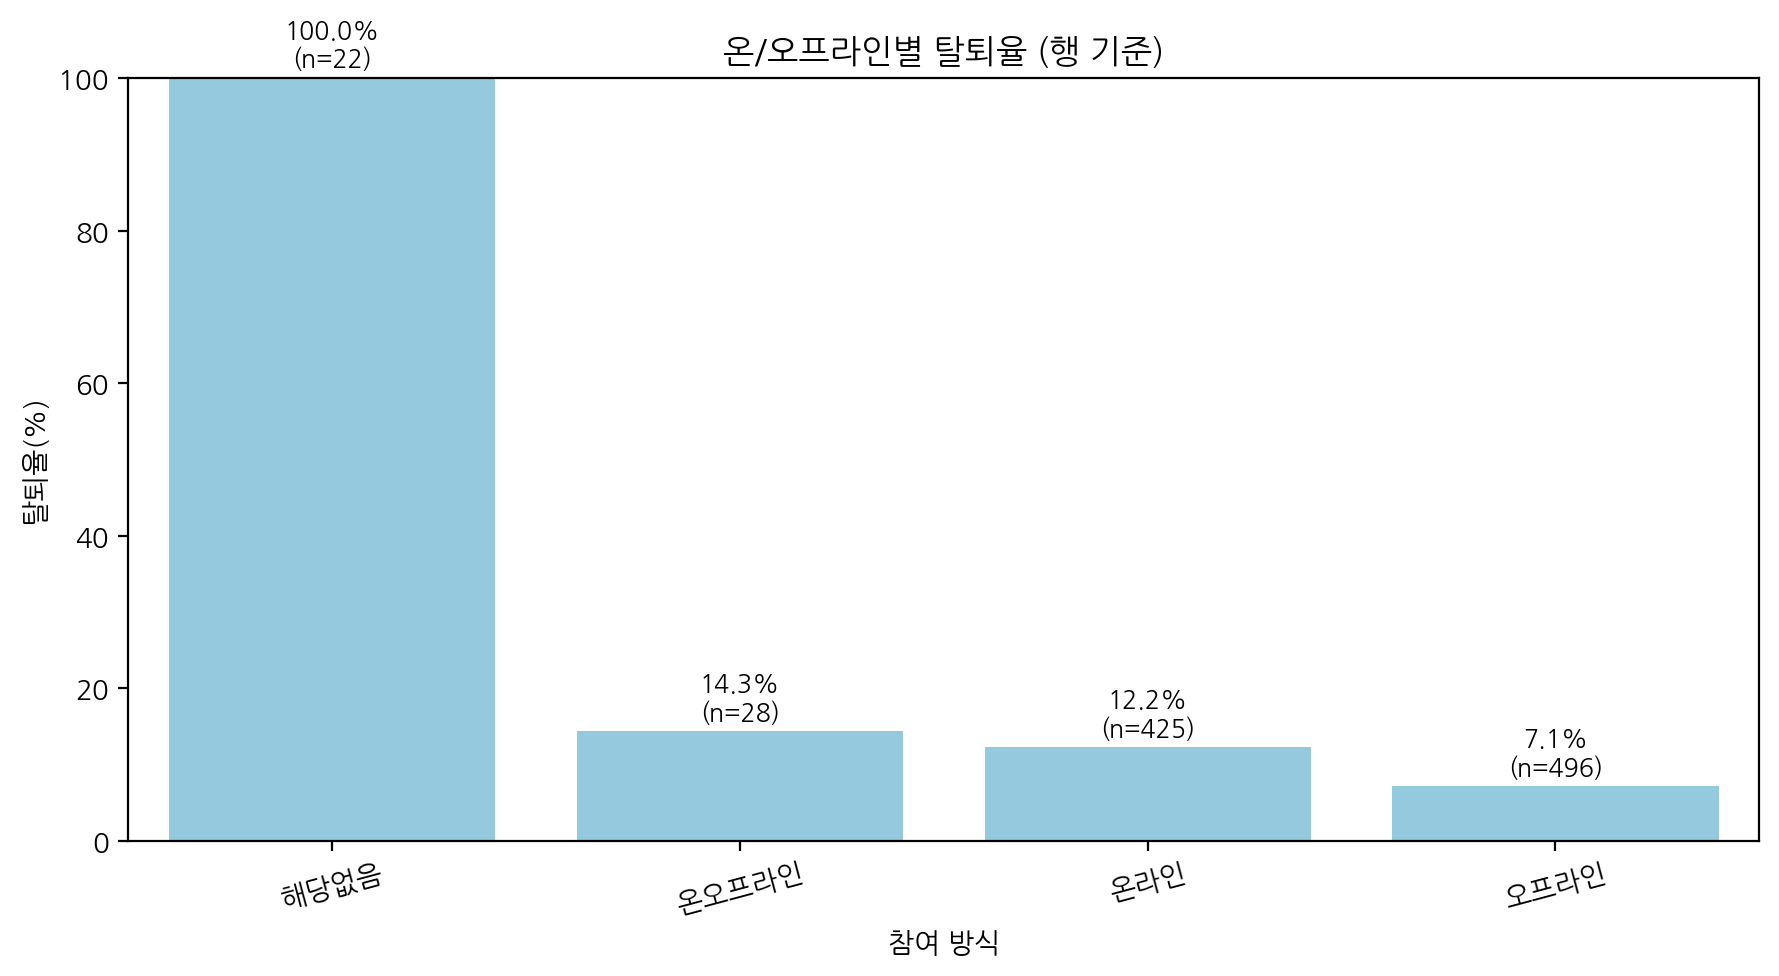

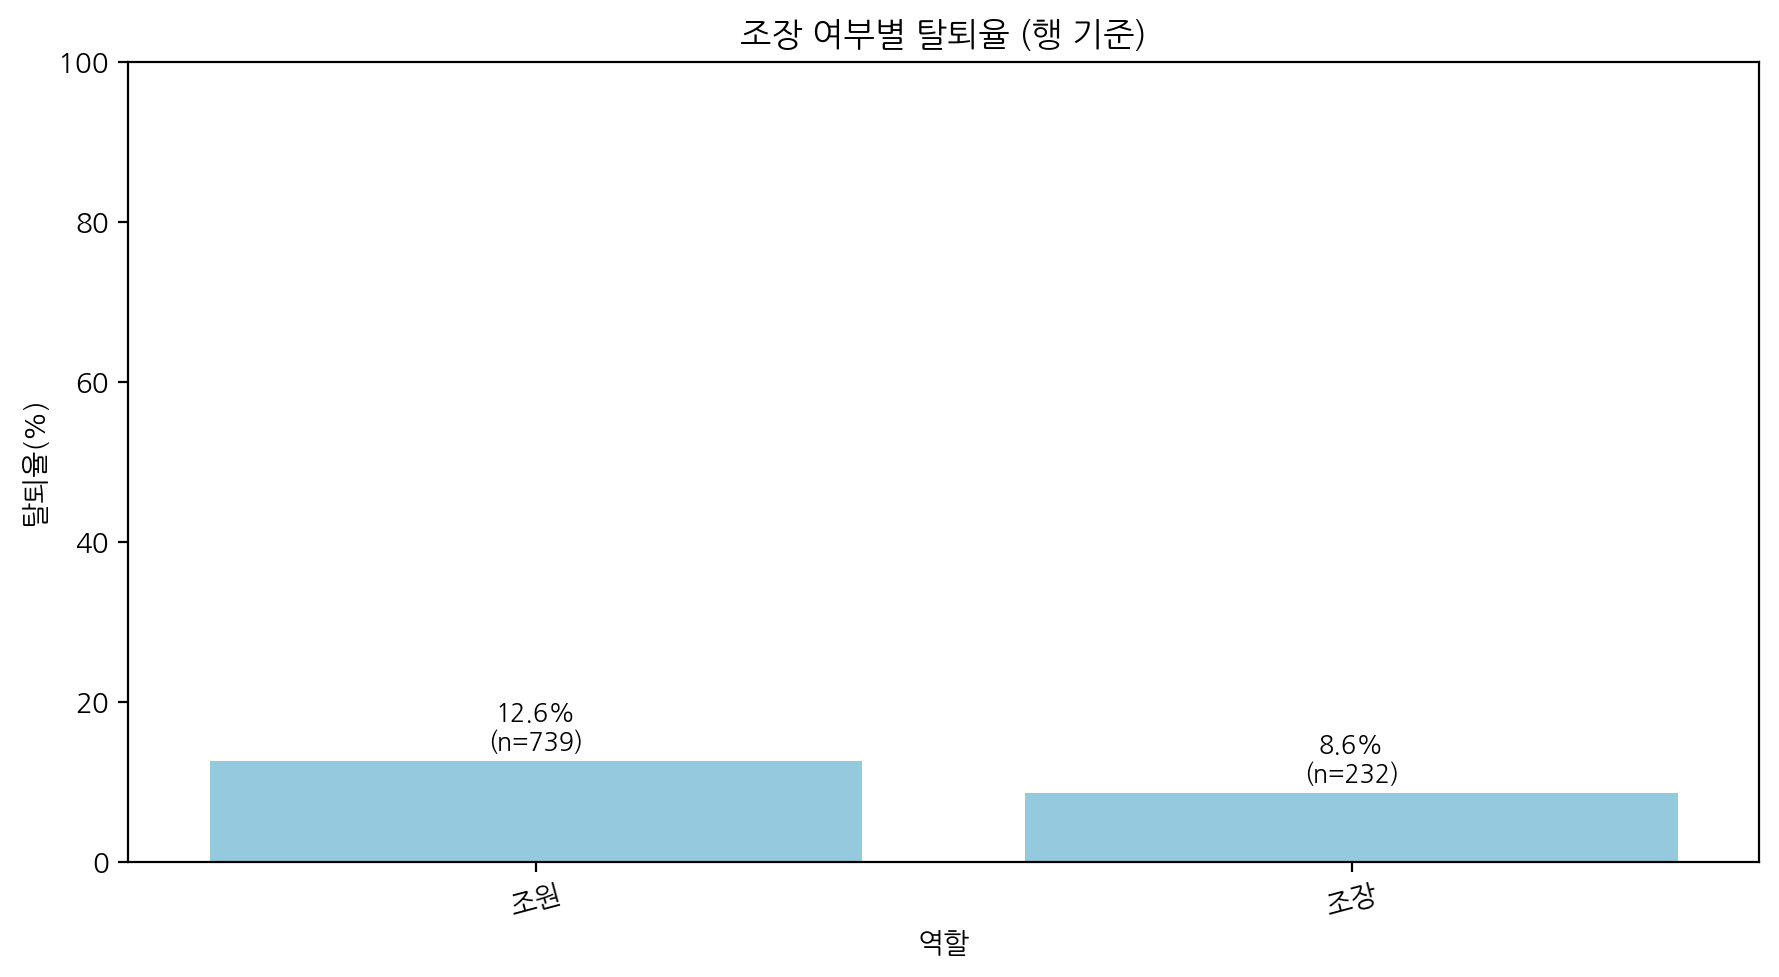

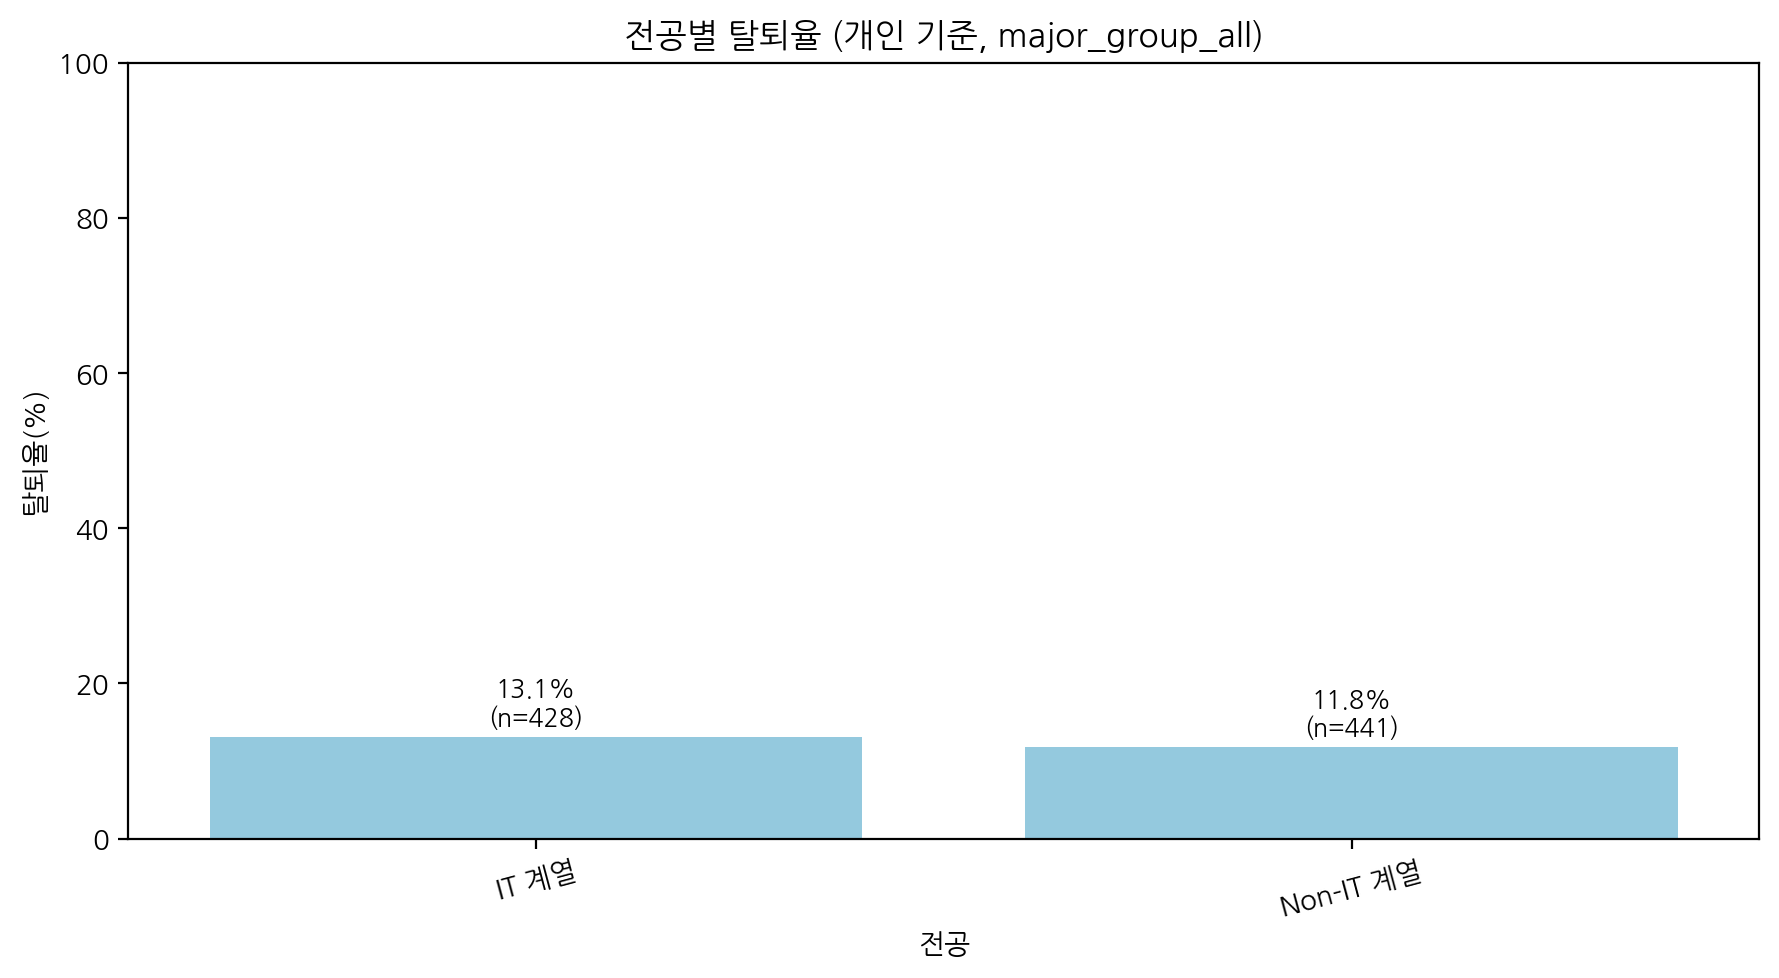

In [ ]:
# =========================
# 0) 데이터 준비
# =========================
df = group_yes.copy()

# 타입/공백 정리
df['group_leave']  = pd.to_numeric(df['group_leave'], errors='coerce').fillna(0).astype(int)
df['group_master'] = pd.to_numeric(df.get('group_master', 0), errors='coerce').fillna(0).astype(int)
for c in ['leave_point','on_offline','generation','major_group_all','major1_1']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

PERSON_KEYS = ['member_id','generation']  # 개인 기준 키

# =========================
# A. 탈퇴 시점 분포 (탈퇴자만, 시각화용)
# =========================
leavers = df[df['group_leave'] == 1].copy()

leave_timing = (
    leavers['leave_point']
      .value_counts(dropna=False)
      .rename_axis('leave_point')
      .reset_index(name='leavers')
)
total_leavers_rows = int(leavers.shape[0])  # (행 기준) 탈퇴 레코드 수
leave_timing['share'] = (leave_timing['leavers'] / total_leavers_rows).round(4)

print("▶ [탈퇴자만] 탈퇴 시점 분포")
display(leave_timing)

# =========================
# B. 온/오프라인 탈퇴율 (행 기준, 유니크 X)
# =========================
def leave_rate_by_rows(df, col, min_cnt=1):
    g = (df.groupby(col)
           .agg(n=('member_id','count'),
                leave_cnt=('group_leave','sum'),
                leave_rate=('group_leave','mean')))
    if g.empty:
        return g
    g = g[g['n'] >= min_cnt]
    g['leave_rate'] = (g['leave_rate'] * 100).round(1)
    return g.sort_values('leave_rate', ascending=False)

res_onoff = leave_rate_by_rows(df, 'on_offline', min_cnt=1)
print("▶ 온/오프라인별 탈퇴율 (행 기준)")
display(res_onoff)

# =========================
# C. 조장 여부별 탈퇴율 (행 기준, 유니크 X)
#     ※ 해당 행의 역할(group_master) 기준
# =========================
res_master = leave_rate_by_rows(df, 'group_master', min_cnt=1)
print("▶ 조장 여부별 탈퇴율 (행 기준)")
display(res_master)

# =========================
# D. 전공별 탈퇴율 (개인 기준, 유니크 O)
#     - 전공은 개인당 1개(첫 관측치)
#     - 탈퇴는 한 번이라도 1이면 탈퇴자로 카운트
# =========================
def leave_rate_major_by_person(df, major_col='major_group_all', min_cnt=1):
    # 개인별 탈퇴 플래그
    leaver = (df.groupby(PERSON_KEYS)['group_leave']
                .max()
                .rename('leaver')
                .reset_index())
    # 개인별 전공 대표값(첫 관측치)
    first_major = (df.sort_values(PERSON_KEYS)
                     .drop_duplicates(subset=PERSON_KEYS, keep='first')[PERSON_KEYS + [major_col]])
    person = first_major.merge(leaver, on=PERSON_KEYS, how='left')

    g = (person.groupby(major_col)
               .agg(n=('member_id','nunique'),
                    leavers=('leaver','sum')))
    if g.empty:
        return g
    g = g[g['n'] >= min_cnt]
    g['leave_rate'] = (g['leavers'] / g['n'] * 100).round(1)
    return g.sort_values('leave_rate', ascending=False)

MAJOR_COL = 'major_group_all'  # 필요시 'major1_1'로 변경 가능
res_major = leave_rate_major_by_person(df, major_col=MAJOR_COL, min_cnt=1)
print(f"▶ 전공별 탈퇴율 (개인 기준, {MAJOR_COL})")
display(res_major)

# =========================
# 시각화 함수 (안정 버전)
# =========================
def plot_rate_table(df_result, title, xlabel="그룹", ylabel="탈퇴율(%)",
                    ylim=(0,100), index_rename=None):
    if df_result is None or df_result.empty:
        print(f"[{title}] 표시할 데이터가 없습니다.")
        return

    d = df_result.copy()
    # 인덱스 라벨 치환
    if index_rename:
        d = d.rename(index=index_rename)

    # index → 문자열 컬럼
    if isinstance(d.index, pd.MultiIndex):
        labels = d.index.to_flat_index().map(lambda x: " | ".join(map(str, x)))
    else:
        labels = d.index.map(str)

    d = d.reset_index(drop=True)
    d.insert(0, 'group_label', labels)

    plt.figure(figsize=(9,5))
    ax = sns.barplot(data=d, x='group_label', y='leave_rate', color='skyblue')

    # 막대 위 라벨 (% + n)
    for p, (_, row) in zip(ax.patches, d.iterrows()):
        ax.text(p.get_x()+p.get_width()/2,
                p.get_height()+0.8,
                f"{row['leave_rate']:.1f}%\n(n={int(row['n'])})",
                ha='center', va='bottom', fontsize=9)

    ax.set_title(title)
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(*ylim)
    ax.tick_params(axis='x', rotation=15)
    plt.tight_layout(); plt.show()

# =========================
# 시각화
# =========================

# (1) 탈퇴 시점 분포 — 탈퇴자만 (개수/비율 막대)
plt.figure(figsize=(9,5))
ax = sns.barplot(data=leave_timing, x='leave_point', y='leavers', color='salmon')
for p, (_, row) in zip(ax.patches, leave_timing.iterrows()):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.8,
            f"{int(row['leavers'])}\n({row['share']*100:.1f}%)",
            ha='center', va='bottom', fontsize=9)
ax.set_title("탈퇴자 기준 탈퇴 시점 분포")
ax.set_xlabel("탈퇴 시점"); ax.set_ylabel("탈퇴 행 수")
ax.tick_params(axis='x', rotation=15)
plt.tight_layout(); plt.show()

# (2) 온/오프라인 탈퇴율 — 전체 대비 (행 기준)
plot_rate_table(res_onoff, "온/오프라인별 탈퇴율 (행 기준)", xlabel="참여 방식")

# (3) 조장 여부별 탈퇴율 — 전체 대비 (행 기준)
plot_rate_table(res_master, "조장 여부별 탈퇴율 (행 기준)", xlabel="역할",
                index_rename={0:'조원', 1:'조장'})

# (4) 전공별 탈퇴율 — 개인 기준 (유니크 O)
plot_rate_table(res_major, f"전공별 탈퇴율 (개인 기준, {MAJOR_COL})", xlabel="전공")

## 통계분석 (group_leave 대상)

### 상관관계 분석

In [ ]:
# before_id가 0이 아니면 1, 0이면 0
group_yes_age_dist = group_yes_age_dist.copy()
group_yes_age_dist["before_exist"] = np.where(group_yes_age_dist["before_id"] != 0, 1, 0)

columns = [
    "generation", "school1", "major_group_all", "major1_1", "major1_2",
    "job", "job_domain", "company", "major_data", "class_count",
    "class1", "class2", "class3", "class4", "before_exist",
    "class_code", "group_master", "on_offline", "excellent_group",
    "excellent_group_master", "age", "school1_proc", "school2_proc"
]

X = group_yes_age_dist[columns].copy()
y = group_yes_age_dist["group_leave"].copy()

# 결측치 처리 (inplace 대신 재할당)
X = X.fillna(0)

# group_leave를 0/1로 변환 ('X','0' → 0, '1' → 1)
group_yes_age_dist = group_yes_age_dist.copy()
group_yes_age_dist["group_leave_numeric"] = (
    group_yes_age_dist["group_leave"].replace({"X": 0, "0": 0, "1": 1})
)

y = group_yes_age_dist["group_leave_numeric"]

# 수치형 컬럼만 추출
numeric_cols = group_yes_age_dist[columns].select_dtypes(include=["int", "float"]).columns.tolist()

# 상관계수 계산
corr_matrix = group_yes_age_dist[numeric_cols + ["group_leave_numeric"]].corr()
corr_with_target = corr_matrix["group_leave_numeric"].sort_values(ascending=False)

print(corr_with_target)


group_leave_numeric    1.000000
age                    0.031990
school1_proc           0.013799
school2_proc           0.002452
class_count           -0.081986
before_exist                NaN
Name: group_leave_numeric, dtype: float64


In [ ]:
# categorical_cols 추출
categorical_cols = group_yes_age_dist[columns].select_dtypes(include=['object','category']).columns.tolist()

# 각 범주형 컬럼별로 group_leave_numeric 평균 계산
for col in categorical_cols:
    print(f"--- {col} ---")
    mean_values = group_yes_age_dist.groupby(col)['group_leave_numeric'].mean()
    top10 = mean_values.sort_values(ascending=False).head(10)
    print(top10)


--- generation ---
generation
8     0.186170
9     0.104839
10    0.048991
Name: group_leave_numeric, dtype: float64
--- school1 ---
school1
gydqzc    1.000000
smgbdn    1.000000
pporuk    1.000000
vlslbc    1.000000
ldwufn    0.666667
crfjrp    0.666667
lyqjoz    0.538462
kdetya    0.500000
oovvah    0.500000
vczszx    0.500000
Name: group_leave_numeric, dtype: float64
--- major_group_all ---
major_group_all
IT 계열        0.127389
Non-IT 계열    0.106000
Name: group_leave_numeric, dtype: float64
--- major1_1 ---
major1_1
건설환경공학부       1.000000
컴퓨터소프트웨어학부    1.000000
한문학과          1.000000
방송디지털미디어학과    1.000000
국제사무학과        0.500000
소프트웨어학과       0.500000
전자공학과         0.500000
경제통상학         0.266667
AI융합학부        0.250000
정보통신공학과       0.250000
Name: group_leave_numeric, dtype: float64
--- major1_2 ---
major1_2
반도체공학과           1.000000
인문학              0.333333
통계학과             0.285714
사회학과             0.250000
사회과학             0.230769
경제통상학            0.187500
IT(컴퓨터 공학 포함)    0.15

### 카이제곱 연관성 분석

In [ ]:
chi_squre_df = group_yes_age_dist.copy()

for col in columns:
    contingency = pd.crosstab(chi_squre_df[col], chi_squre_df['group_leave'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"{col} → p-value: {p:.4f}")



generation → p-value: 0.0000
school1 → p-value: 0.0004
major_group_all → p-value: 0.3479
major1_1 → p-value: 0.9999
major1_2 → p-value: 0.9963
job → p-value: 0.0400
job_domain → p-value: 0.0000
company → p-value: 0.0115
major_data → p-value: 0.9996
class_count → p-value: 0.0740
class1 → p-value: 0.0375
class2 → p-value: 0.0673
class3 → p-value: 0.5901
class4 → p-value: 0.9391
before_exist → p-value: 1.0000
class_code → p-value: 0.0780
group_master → p-value: 0.1272
on_offline → p-value: 0.0000
excellent_group → p-value: 0.0013
excellent_group_master → p-value: 0.0507
age → p-value: 0.1200
school1_proc → p-value: 0.7925
school2_proc → p-value: 1.0000


- 연관성 있는 컬럼만 아래에서 경향성 확인

In [ ]:
categorical_vars = ['job','company','class1','excellent_group']

for i in categorical_vars :
  contingency = pd.crosstab(chi_squre_df[i], chi_squre_df['group_leave'])
  chi2, p, dof, expected = chi2_contingency(contingency)

  residuals = (contingency - expected) / np.sqrt(expected)
  print(residuals)


group_leave         0         1
job                            
X            0.274501 -0.756394
대학생         -0.046361  0.127748
대학원생         0.410602 -1.131425
직장인         -0.873601  2.407230
취준생          0.397075 -1.094151
group_leave           0         1
company                          
K-그루터기         0.123801 -0.341138
NH저축은행         0.123801 -0.341138
X              0.106897 -0.294559
jetta         -0.940013  2.590231
p&h tech       0.123801 -0.341138
개발자            0.123801 -0.341138
공무원            0.123801 -0.341138
금융 경제 조사 및 통계  0.175081 -0.482441
기술 영업         -0.940013  2.590231
데이터 분석 보조      0.123801 -0.341138
데이터 엔지니어       0.123801 -0.341138
데이터전략 컨설턴트     0.123801 -0.341138
디지털기획자        -0.577149  1.590349
마케터           -0.577149  1.590349
버거킹 알바         0.123801 -0.341138
사업PM           0.123801 -0.341138
연구보조원         -1.329380  3.663139
연구원            0.123801 -0.341138
유통 비즈니스        0.123801 -0.341138
칸타 코리아         0.123801 -0.341138
품질경영           0.123801 -0.3

### 랜덤포레스트 피처 중요도 분석

In [ ]:
# -----------------------------
# 1) 범주형 컬럼 선택
# -----------------------------
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# 수치형 컬럼
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# -----------------------------
# 2) One-Hot Encoding
# -----------------------------
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# -----------------------------
# 3) Train/Test 분리
# -----------------------------
X_tr, X_te, y_tr, y_te = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# -----------------------------
# 4) 회귀 모델 학습
# -----------------------------
model = RandomForestClassifier()
model.fit(X_tr, y_tr)

# -----------------------------
# 5) 예측
# -----------------------------
y_pred = model.predict(X_te)

# -----------------------------
# 6) 평가
# -----------------------------
mse = mean_squared_error(y_te, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_te, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

MSE: 0.07179487179487179
RMSE: 0.26794565082283345
R²: 0.18361244019138767


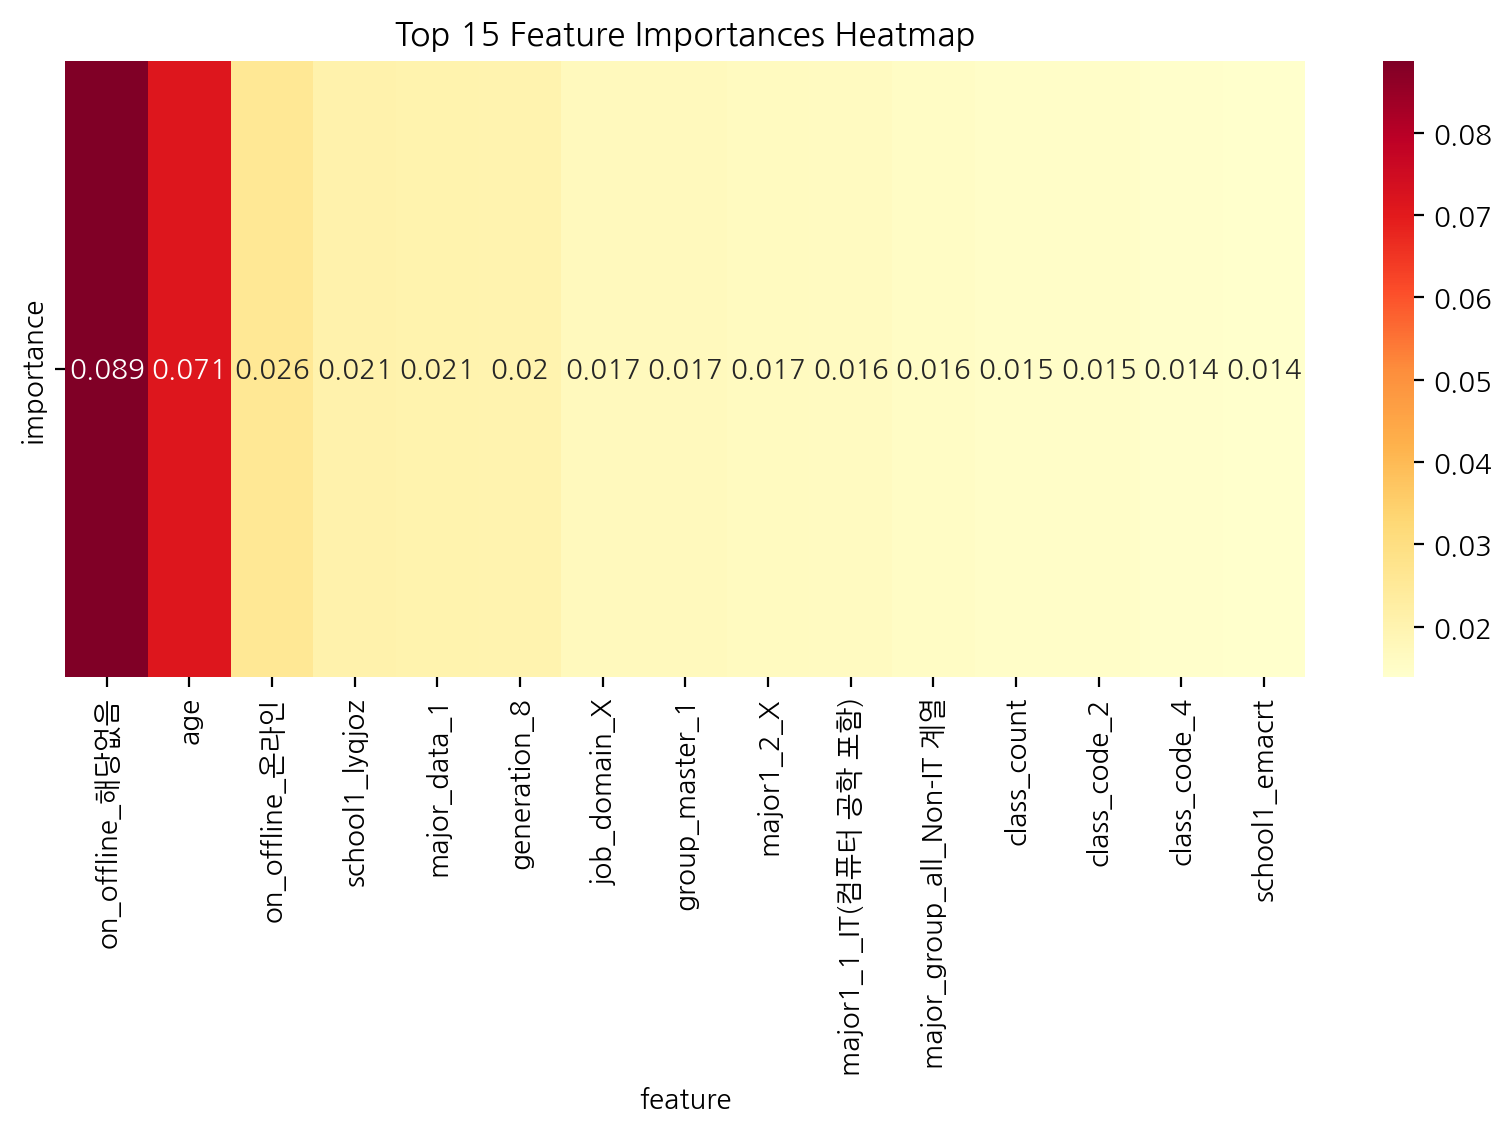

In [ ]:
# 피처 중요도 DataFrame
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 상위 N개 피처 선택
top_n = 15
top_features = feature_importance.head(top_n)

# 히트맵용 데이터 준비
heatmap_data = top_features.set_index('feature').T

plt.figure(figsize=(10, 4))  # 세로로 길게
sns.heatmap(
    heatmap_data,
    annot=True,        # 값 표시
    cmap='YlOrRd',     # 색상
    cbar=True
)
plt.title("Top 15 Feature Importances Heatmap")
plt.show()


## 다중 회귀분석 (leave_point 대상)

In [ ]:
# -----------------------------
# 타겟 인코딩
# -----------------------------
y_enc = LabelEncoder().fit_transform(group_yes['leave_point'])

# -----------------------------
# 피처 전처리
# -----------------------------
# 숫자형 변수 처리 (NaN을 0으로)
X_num = X.select_dtypes(include=['int', 'float']).fillna(0)

# 범주형 변수 처리 (라벨 인코딩)
X_cat = X.select_dtypes(include=['object']).apply(
    lambda col: LabelEncoder().fit_transform(col.fillna('NA'))
)

# 숫자형 + 범주형 합치기
X_model = pd.concat([X_num, X_cat], axis=1)

# 컬럼 이름을 모두 문자열로 변환 (LogisticRegression 요구)
X_model.columns = X_model.columns.astype(str)
X_model.fillna(0,inplace=True)
# -----------------------------
# 모델 학습
# -----------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    penalty="l2"
)
clf.fit(X_model, y_enc)

# -----------------------------
# 오즈비 계산
# -----------------------------
odds_ratios = np.exp(clf.coef_)

# 결과 확인
print(odds_ratios)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[1.11376704 0.76067211 0.97825472 1.5029992  0.75309335 2.79181221
  0.99539644 0.92169632 0.99571124 0.9906249  1.0209407  1.16054246
  1.04645451 0.7460094  1.17008802 1.04466583 0.87333322 1.00242317
  0.94370061 1.07093507 0.64508119 0.59246702 0.62618434]
 [0.88621573 0.85443238 0.96191872 1.41655312 0.94978907 0.55829833
  1.00688262 1.50692644 1.00100119 1.00792806 1.05840312 1.0353094
  0.80509403 0.74827921 1.01516737 1.00994682 0.75859074 1.00148984
  0.96300233 1.0023401  5.25398817 0.86491012 0.85056436]
 [1.08919785 0.92740188 0.97717947 1.1190915  0.86171747 3.92725254
  0.99767345 1.1083065  0.99815087 1.00813833 1.2496746  1.22066485
  0.92838348 1.39645701 1.0065375  1.01656966 1.17026187 0.99703284
  0.97962168 0.69162288 0.7048758  0.51582891 0.65775221]
 [1.52791897 2.4729796  0.96436471 0.70399076 0.78687547 0.63854421
  0.99535167 0.94437406 1.0007874  1.0034318  1.09515726 0.96867025
  0.97271946 1.03819855 0.93397963 0.94611618 1.48243573 1.01436237
  1.0007244

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
feature_names = X_model.columns
for i, class_label in enumerate(np.unique(y_enc)):
    print(f"Class {class_label}:")
    for fname, or_val in zip(feature_names, odds_ratios[i]):
        if or_val > 1.5 or or_val < 0.67:  # 중요 값만 표시
            print(f"  {fname}: {or_val:.2f}")


Class 0:
  school1_proc: 1.50
  generation: 2.79
  on_offline: 0.65
  excellent_group: 0.59
  excellent_group_master: 0.63
Class 1:
  generation: 0.56
  major_group_all: 1.51
  on_offline: 5.25
Class 2:
  generation: 3.93
  excellent_group: 0.52
  excellent_group_master: 0.66
Class 3:
  class_count: 1.53
  before_exist: 2.47
  generation: 0.64
  on_offline: 0.34
  excellent_group: 3.78
  excellent_group_master: 2.87
Class 4:
  class_count: 0.61
  school1_proc: 0.60
  school2_proc: 2.06
  generation: 0.26


In [ ]:
# LabelEncoder 객체를 사용했다면
le = LabelEncoder()
y_enc = le.fit_transform(group_yes['leave_point'])

# 숫자 ↔ 원본 클래스 매핑
class_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(class_mapping)

{np.int64(0): '기말 휴회기간 이후', np.int64(1): '중간 휴회기간 이전', np.int64(2): '중간 휴회기간 이후', np.int64(3): '해당없음', np.int64(4): '확인 불가'}


In [ ]:
# -----------------------------
# 타겟 인코딩
# -----------------------------
y_enc = LabelEncoder().fit_transform(group_yes['leave_point'])

# -----------------------------
# X_encoded 사용
# 이미 범주형은 One-Hot Encoding 되어 있다고 가정
# -----------------------------
X_encoded.fillna(0, inplace=True)  # 혹시 NaN 있으면 처리

# -----------------------------
# 모델 학습
# -----------------------------
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    penalty="l2"
)
clf.fit(X_encoded, y_enc)

# -----------------------------
# 오즈비 계산
# -----------------------------
odds_ratios = np.exp(clf.coef_)

# 결과 확인
print(odds_ratios)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[ 1.18802228  1.06640572  0.97022385 ...  0.60690866  0.55392896
   0.62335227]
 [ 0.82628817  1.00428932  0.97294478 ... 35.39538688  0.84332384
   0.90354701]
 [ 1.05851616  1.01001629  0.97636629 ...  0.46099526  0.4486131
   0.69880134]
 [ 1.40905829  0.95113575  0.98446026 ...  0.11061715  4.96880464
   2.6053684 ]
 [ 0.68299485  0.9719587   1.10212004 ...  0.91287452  0.96034588
   0.97519807]]


In [ ]:
feature_names = X_encoded.columns
for i, class_label in enumerate(np.unique(y_enc)):
    print(f"Class {class_label}:")
    for fname, or_val in zip(feature_names, odds_ratios[i]):
        if or_val > 1.5 or or_val < 0.67:  # 중요 값만 표시
            print(f"  {fname}: {or_val:.2f}")


Class 0:
  generation_8: 1.70
  generation_9: 2.49
  school1_atqymc: 2.32
  school1_byovqx: 1.81
  school1_fzmpzr: 1.81
  school1_gqwbze: 2.51
  school1_hsiluu: 0.61
  school1_iocifc: 1.90
  school1_ivkavz: 1.71
  school1_jzpwew: 0.64
  school1_ldwufn: 1.67
  school1_oovvah: 1.95
  school1_ujhtir: 2.72
  school1_uslogh: 0.64
  school1_vmemts: 0.67
  school1_yphcip: 0.61
  major1_1_IT(컴퓨터 공학 포함): 2.20
  major1_1_경영학: 1.89
  major1_1_교육학: 1.62
  major1_1_사회과학: 0.55
  major1_1_예체능: 1.85
  major1_2_IT(컴퓨터 공학 포함): 2.02
  major1_2_경영학: 0.62
  major1_2_경제통상학: 2.19
  major1_2_없음: 0.63
  major1_2_인문학: 1.56
  job_domain_R. 보건업 및 사회복지 서비스업: 1.80
  company_연구보조원: 1.80
  class1_8: 1.77
  class2_11: 1.77
  class2_5: 1.54
  class2_9: 1.58
  class_code_7: 1.86
  class_code_8: 1.56
  on_offline_온라인: 1.69
  on_offline_해당없음: 0.61
  excellent_group_1: 0.55
  excellent_group_master_1: 0.62
Class 1:
  generation_9: 0.32
  school1_ilcfnz: 1.53
  school1_jzpwew: 1.52
  school1_mhwrvr: 1.76
  school1_pjiuuv: 1

In [ ]:
# 보고 싶은 피처 이름 패턴
# on_offline 관련 모든 컬럼 + major1_1로 시작하는 컬럼
target_features = [col for col in X_encoded.columns
                   if col.startswith("on_offline") or col.startswith("major1_1") or col.startswith('job_domain') or col.startswith('company') or col.startswith('job') or col.startswith('major_group_all')]

for i, class_label in enumerate(np.unique(y_enc)):
    print(f"Class {class_label}:")
    for fname, or_val in zip(X_encoded.columns, odds_ratios[i]):
        if fname in target_features:   # 특정 피처만 필터링
            if or_val > 1.5 or or_val < 0.67:  # 중요 값만 표시
                print(f"  {fname}: {or_val:.2f}")


Class 0:
  major1_1_IT(컴퓨터 공학 포함): 2.20
  major1_1_경영학: 1.89
  major1_1_교육학: 1.62
  major1_1_사회과학: 0.55
  major1_1_예체능: 1.85
  job_domain_R. 보건업 및 사회복지 서비스업: 1.80
  company_연구보조원: 1.80
  on_offline_온라인: 1.69
  on_offline_해당없음: 0.61
Class 1:
  major1_1_X: 1.69
  major1_1_건설환경공학부: 1.91
  major1_1_경영학과: 1.62
  major1_1_영어영문학과: 1.65
  major1_1_전자공학과: 2.05
  major1_1_정보통계학과: 1.54
  major1_1_컴퓨터소프트웨어학부: 2.05
  major1_1_한문학과: 2.03
  on_offline_온라인: 0.41
  on_offline_해당없음: 35.40
Class 2:
  major1_1_경제통상학: 1.95
  major1_1_사회과학: 1.62
  major1_1_예체능: 0.67
  major1_1_의약학: 1.97
  on_offline_온라인: 2.01
  on_offline_해당없음: 0.46
Class 3:
  major1_1_AI융합학부: 0.61
  major1_1_건설환경공학부: 0.54
  major1_1_경제통상학: 0.60
  major1_1_국제사무학과: 0.67
  major1_1_소프트웨어학과: 0.45
  major1_1_전자공학과: 0.52
  major1_1_정보통계학과: 0.65
  major1_1_정보통신공학과: 0.52
  major1_1_컴퓨터소프트웨어학부: 0.50
  major1_1_한문학과: 0.50
  job_직장인: 0.66
  job_domain_R. 보건업 및 사회복지 서비스업: 0.66
  company_연구보조원: 0.66
  on_offline_온오프라인: 0.53
  on_offline_해당없음: 0.11
Clas

## 다양성 지수

### 조별활동 지속 요인 다양성 분석

=== Logistic Regression 성능 ===
Accuracy : 0.650
F1-score : 0.777
ROC-AUC  : 0.564

[분류 리포트]
               precision    recall  f1-score   support

           0      0.130     0.357     0.190        28
           1      0.892     0.688     0.777       215

    accuracy                          0.650       243
   macro avg      0.511     0.523     0.484       243
weighted avg      0.804     0.650     0.709       243



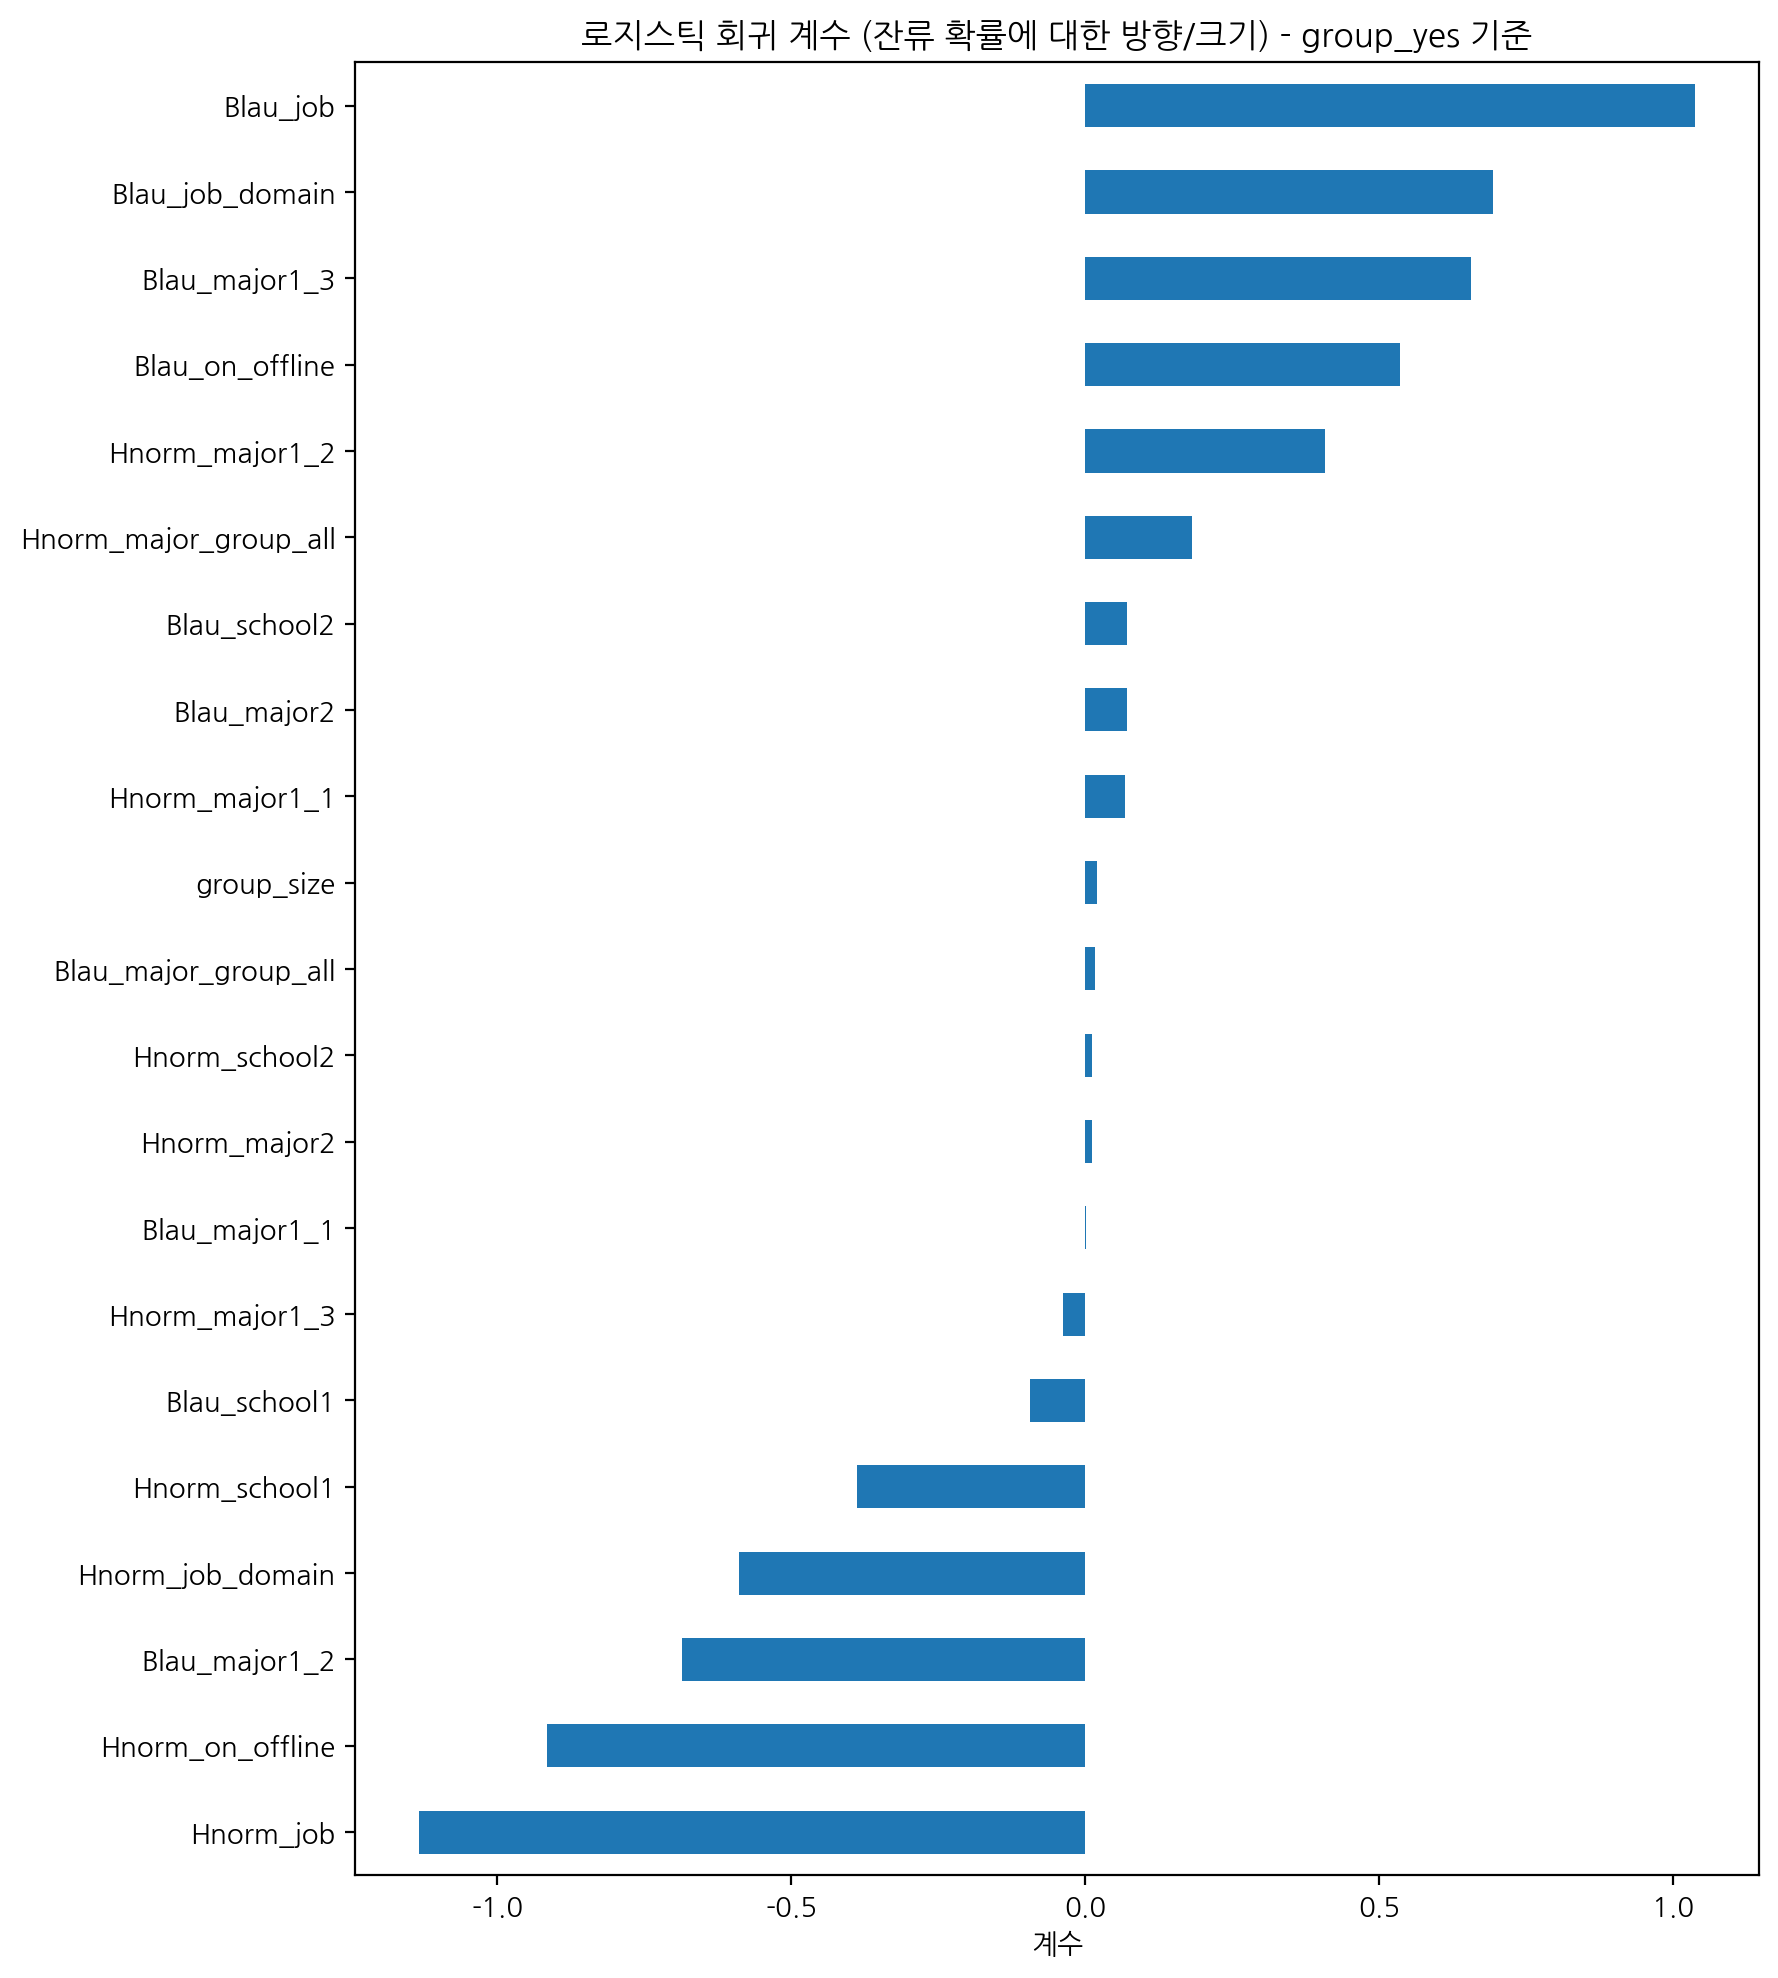


=== RandomForest 성능 ===
Accuracy : 0.835
F1-score : 0.905
ROC-AUC  : 0.664


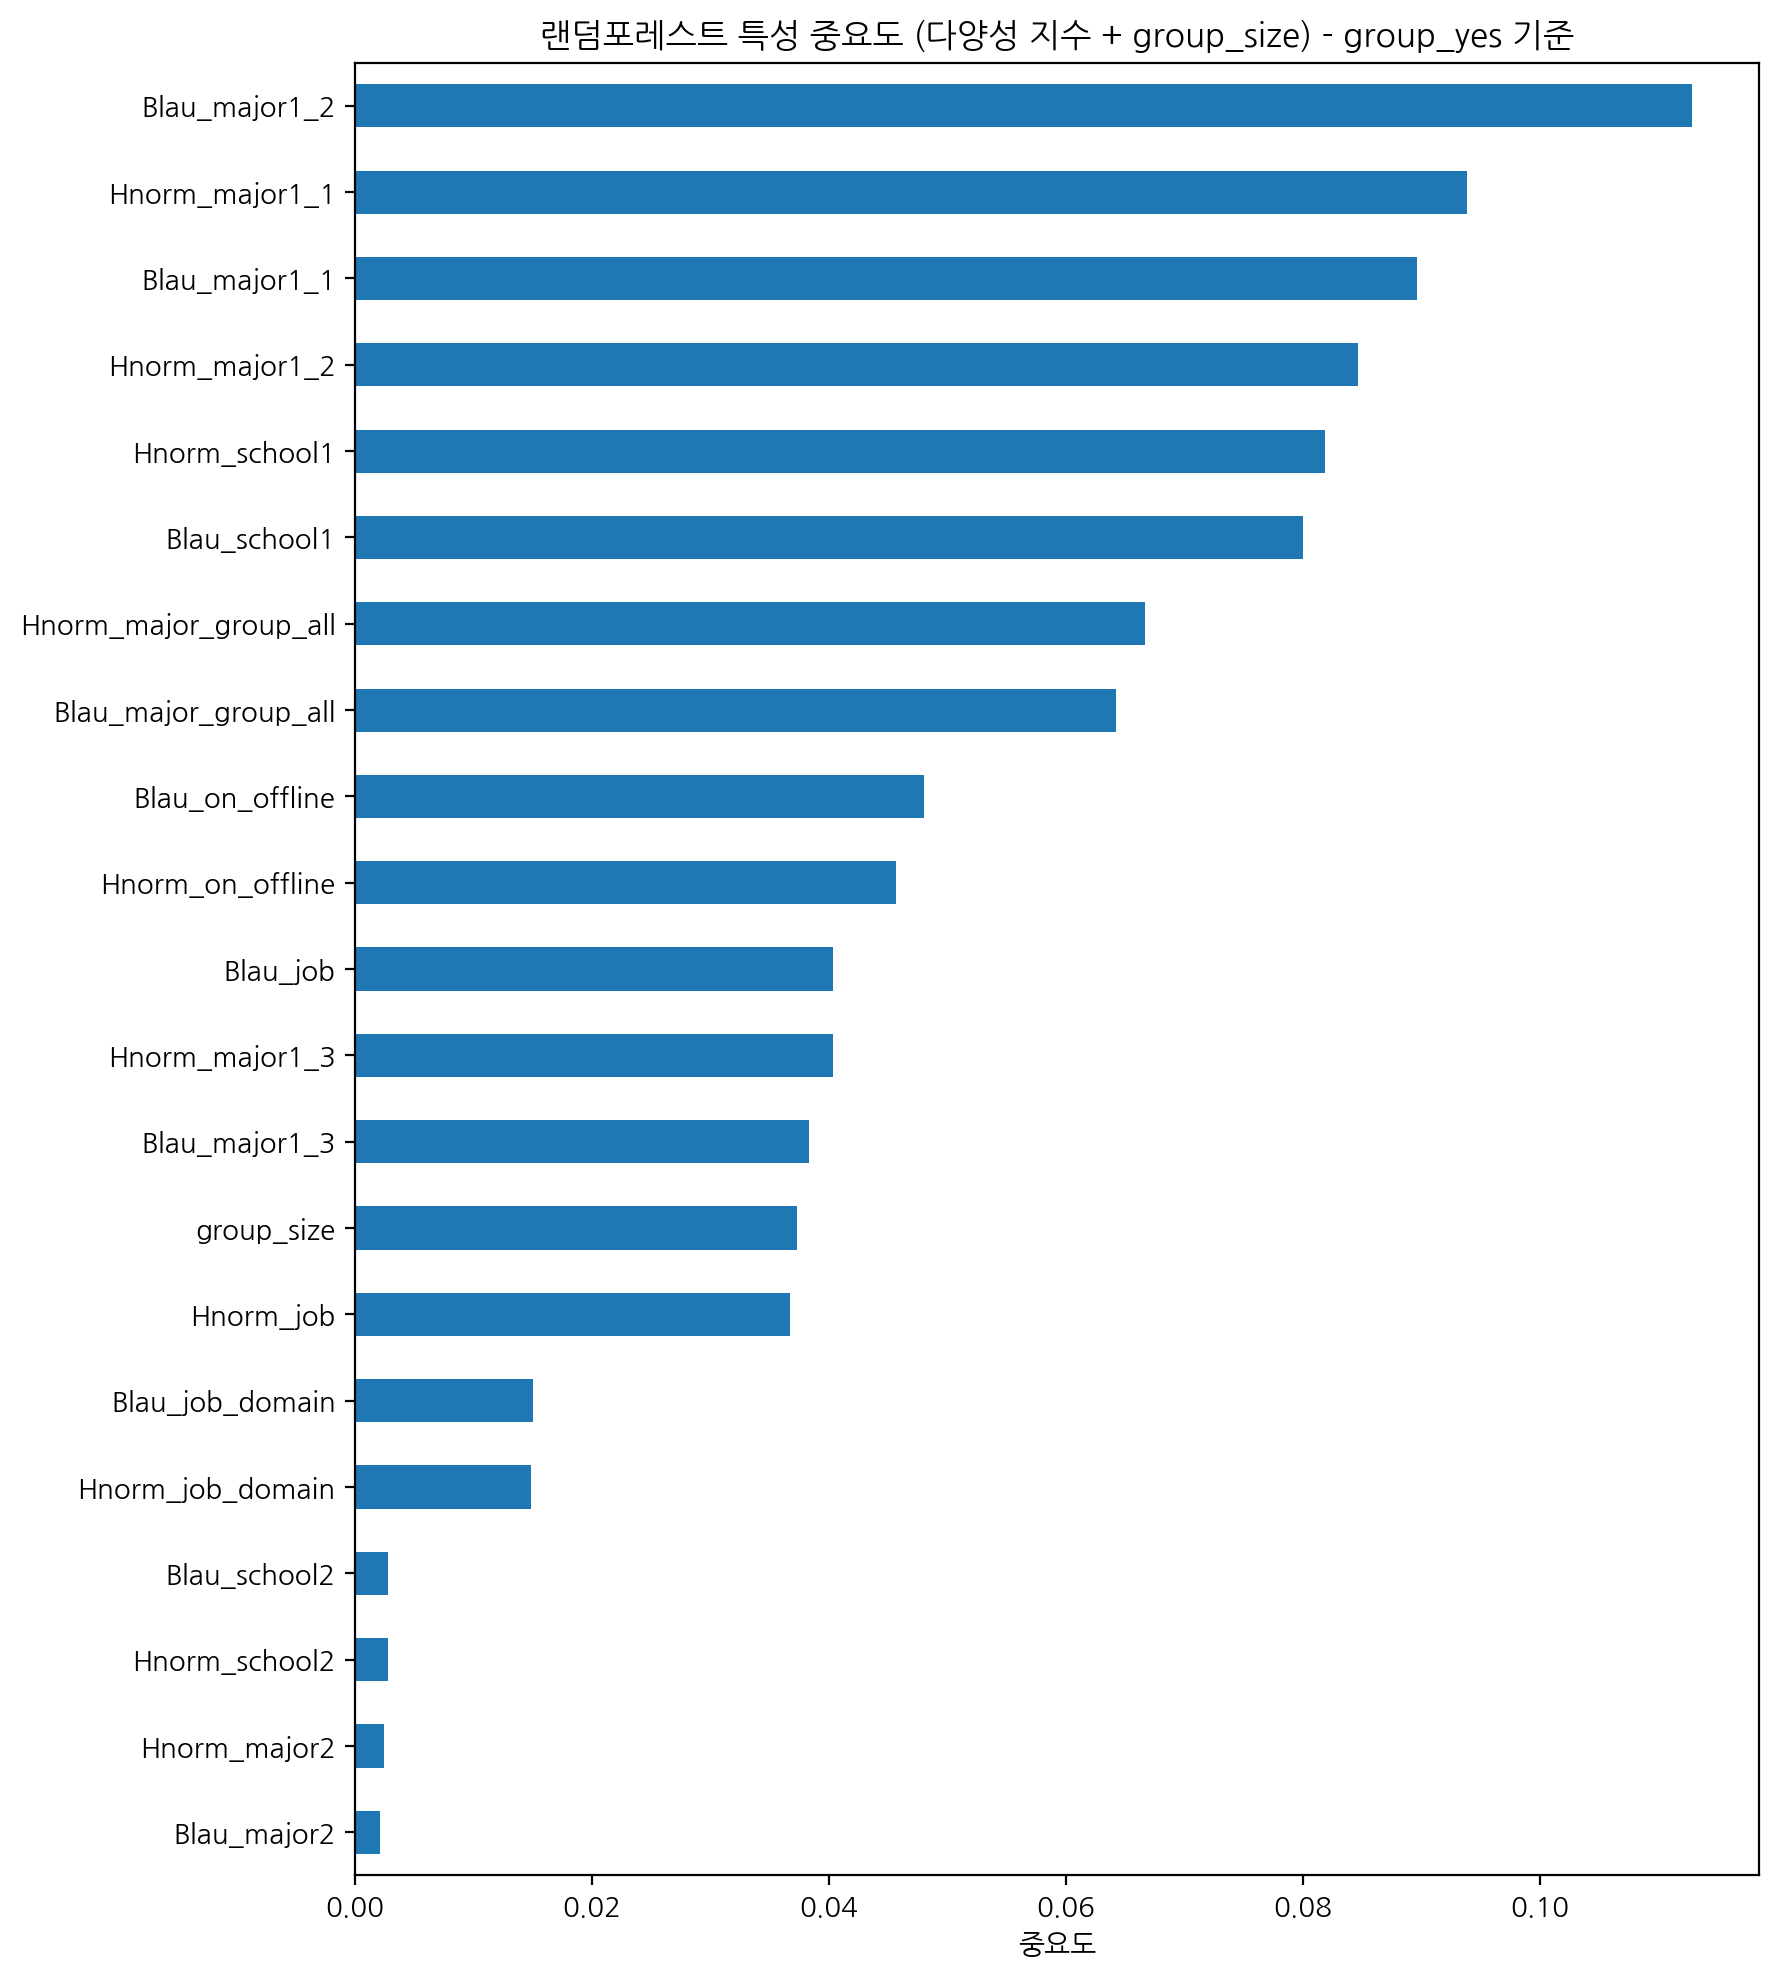


=== 그룹 레벨: 잔류율과 (다양성 지수 + group_size) 상관계수 (group_yes 기준) ===
stay                     1.000000
Blau_major1_3            0.189939
Hnorm_major1_3           0.188006
Blau_major1_1            0.119157
Hnorm_major1_1           0.111031
Blau_school2             0.060339
Blau_major2              0.060339
Hnorm_major2             0.059727
Hnorm_school2            0.059727
Blau_job_domain          0.036814
Hnorm_job_domain         0.034387
Hnorm_major1_2           0.025114
Blau_school1             0.016833
Hnorm_school1            0.002661
Blau_job                 0.001800
Hnorm_job               -0.009234
Hnorm_major_group_all   -0.010397
Blau_major_group_all    -0.012958
Blau_major1_2           -0.014717
group_size              -0.057591
Blau_on_offline         -0.259214
Hnorm_on_offline        -0.263226
Name: stay, dtype: float64


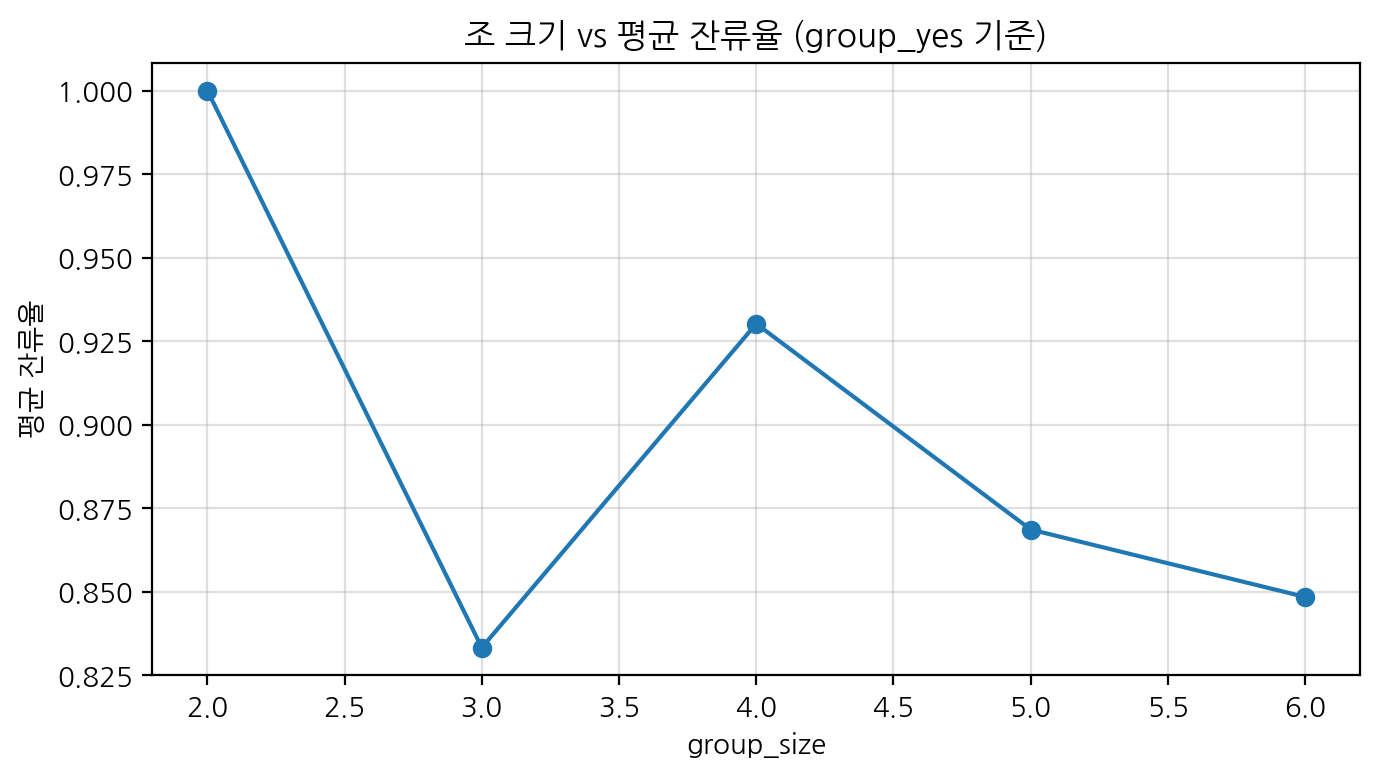

In [ ]:
# 1) 기본 세팅
group_cols = ["generation", "class_code", "group_number"]
cat_cols = [
    'school1', 'school2',
    'major1_1', 'major1_2', 'major1_3', 'major2',
    'job', 'job_domain',
    'major_group_all',
    'on_offline'
]

# 2) 다양성 지수 함수
def shannon_index(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    if len(s) == 0:
        return np.nan
    p = s.value_counts(normalize=True)
    return float(-(p * np.log(p)).sum())

def shannon_normalized(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    K = s.nunique()
    if K <= 1:
        return 0.0
    H = shannon_index(s)
    return float(H / np.log(K))

def blau_index(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    if len(s) == 0:
        return np.nan
    p = s.value_counts(normalize=True)
    return float(1.0 - np.sum(p**2))

# 3) 다양성 지수 계산
def compute_diversity_by_group(df: pd.DataFrame, group_cols, cat_cols):
    out_frames = []
    for col in cat_cols:
        div = (
            df.groupby(group_cols)[col]
              .agg(
                  **{
                      f"Hnorm_{col}": shannon_normalized,
                      f"Blau_{col}": blau_index
                  }
              )
              .reset_index()
        )
        out_frames.append(div)
    from functools import reduce
    div_all = reduce(lambda l, r: pd.merge(l, r, on=group_cols, how="outer"), out_frames)
    return div_all

div_group = compute_diversity_by_group(group_yes, group_cols, cat_cols)

# 4) 그룹 크기 계산
group_sizes = (
    group_yes.groupby(group_cols)
             .size()
             .reset_index(name="group_size")
)

# 5) 다양성 지수와 그룹 크기 병합
group_yes_wdiv = (
    group_yes.merge(div_group, on=group_cols, how="left")
             .merge(group_sizes, on=group_cols, how="left")
)
group_yes_wdiv["stay"] = (group_yes_wdiv["group_leave"] == 0).astype(int)

# 6) 피처 구성
div_cols = [c for c in group_yes_wdiv.columns if c.startswith("Hnorm_") or c.startswith("Blau_")]
feature_cols = div_cols + ['group_size']
X = group_yes_wdiv[feature_cols].copy().fillna(0.0)
y = group_yes_wdiv["stay"].copy()

# 7) 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 8) 로지스틱 회귀
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

logit = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logit.fit(X_train_s, y_train)

y_pred = logit.predict(X_test_s)
y_prob = logit.predict_proba(X_test_s)[:, 1]

print("=== Logistic Regression 성능 ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.3f}")
print("\n[분류 리포트]\n", classification_report(y_test, y_pred, digits=3))

coef_series = pd.Series(logit.coef_[0], index=feature_cols).sort_values()
plt.figure(figsize=(9, 10))
coef_series.plot(kind="barh")
plt.title("로지스틱 회귀 계수 (잔류 확률에 대한 방향/크기) - group_yes 기준")
plt.xlabel("계수")
plt.tight_layout()
plt.show()

# 9) 랜덤포레스트 분류
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== RandomForest 성능 ===")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred_rf):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_rf):.3f}")

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(9, 10))
importances.plot(kind="barh")
plt.title("랜덤포레스트 특성 중요도 (다양성 지수 + group_size) - group_yes 기준")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()

# 10) 그룹 레벨 분석
stay_rate = (
    group_yes_wdiv.groupby(group_cols)["stay"]
                  .mean()
                  .reset_index()
)

grp_anal = (
    stay_rate
    .merge(div_group, on=group_cols, how="left")
    .merge(group_sizes, on=group_cols, how="left")
)

corr_cols = [c for c in grp_anal.columns if c.startswith("Hnorm_") or c.startswith("Blau_")] + ['group_size']
corr = pd.concat([grp_anal["stay"], grp_anal[corr_cols]], axis=1).corr(numeric_only=True)["stay"].sort_values(ascending=False)
print("\n=== 그룹 레벨: 잔류율과 (다양성 지수 + group_size) 상관계수 (group_yes 기준) ===")
print(corr)

trend = grp_anal.groupby('group_size')['stay'].mean().reset_index()
plt.figure(figsize=(7,4))
plt.plot(trend['group_size'], trend['stay'], marker='o')
plt.title("조 크기 vs 평균 잔류율 (group_yes 기준)")
plt.xlabel("group_size")
plt.ylabel("평균 잔류율")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

### 조별 성과 향상 요인 다양성 분석

=== 선형 회귀 성능 ===
R²        : 0.015
MAE       : 0.78
RMSE      : 1.08


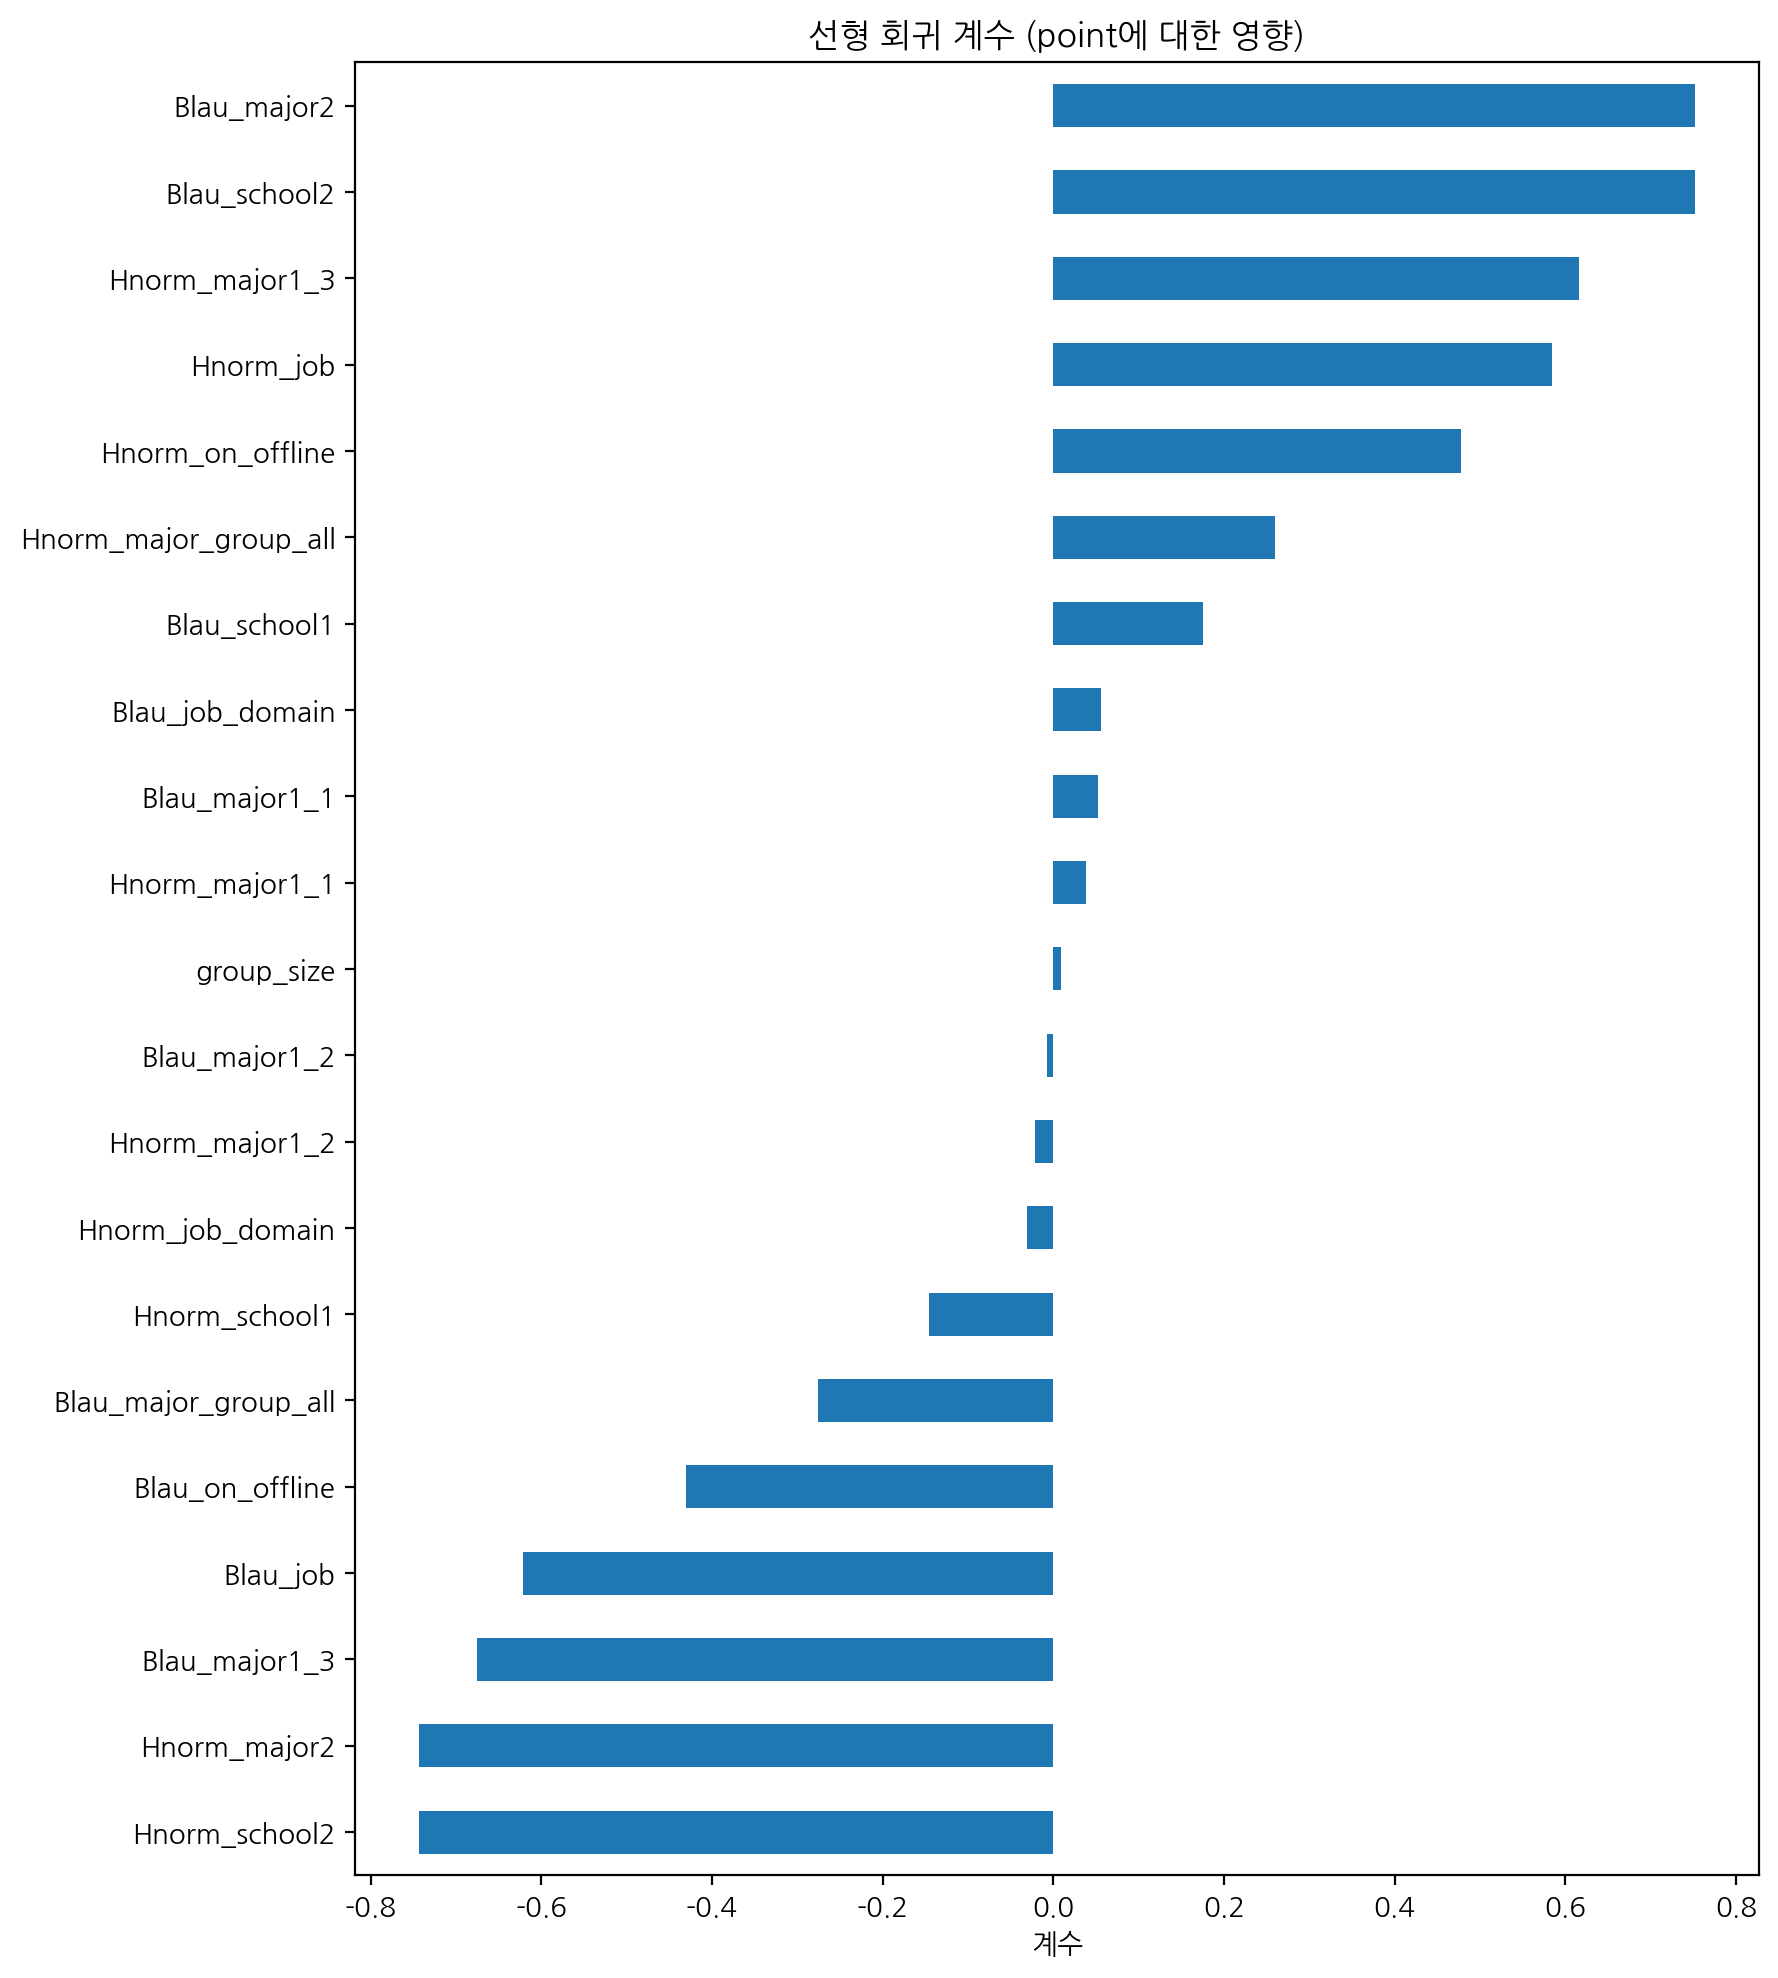


=== 랜덤포레스트 회귀 성능 ===
R²        : 0.368
MAE       : 0.64
RMSE      : 0.87


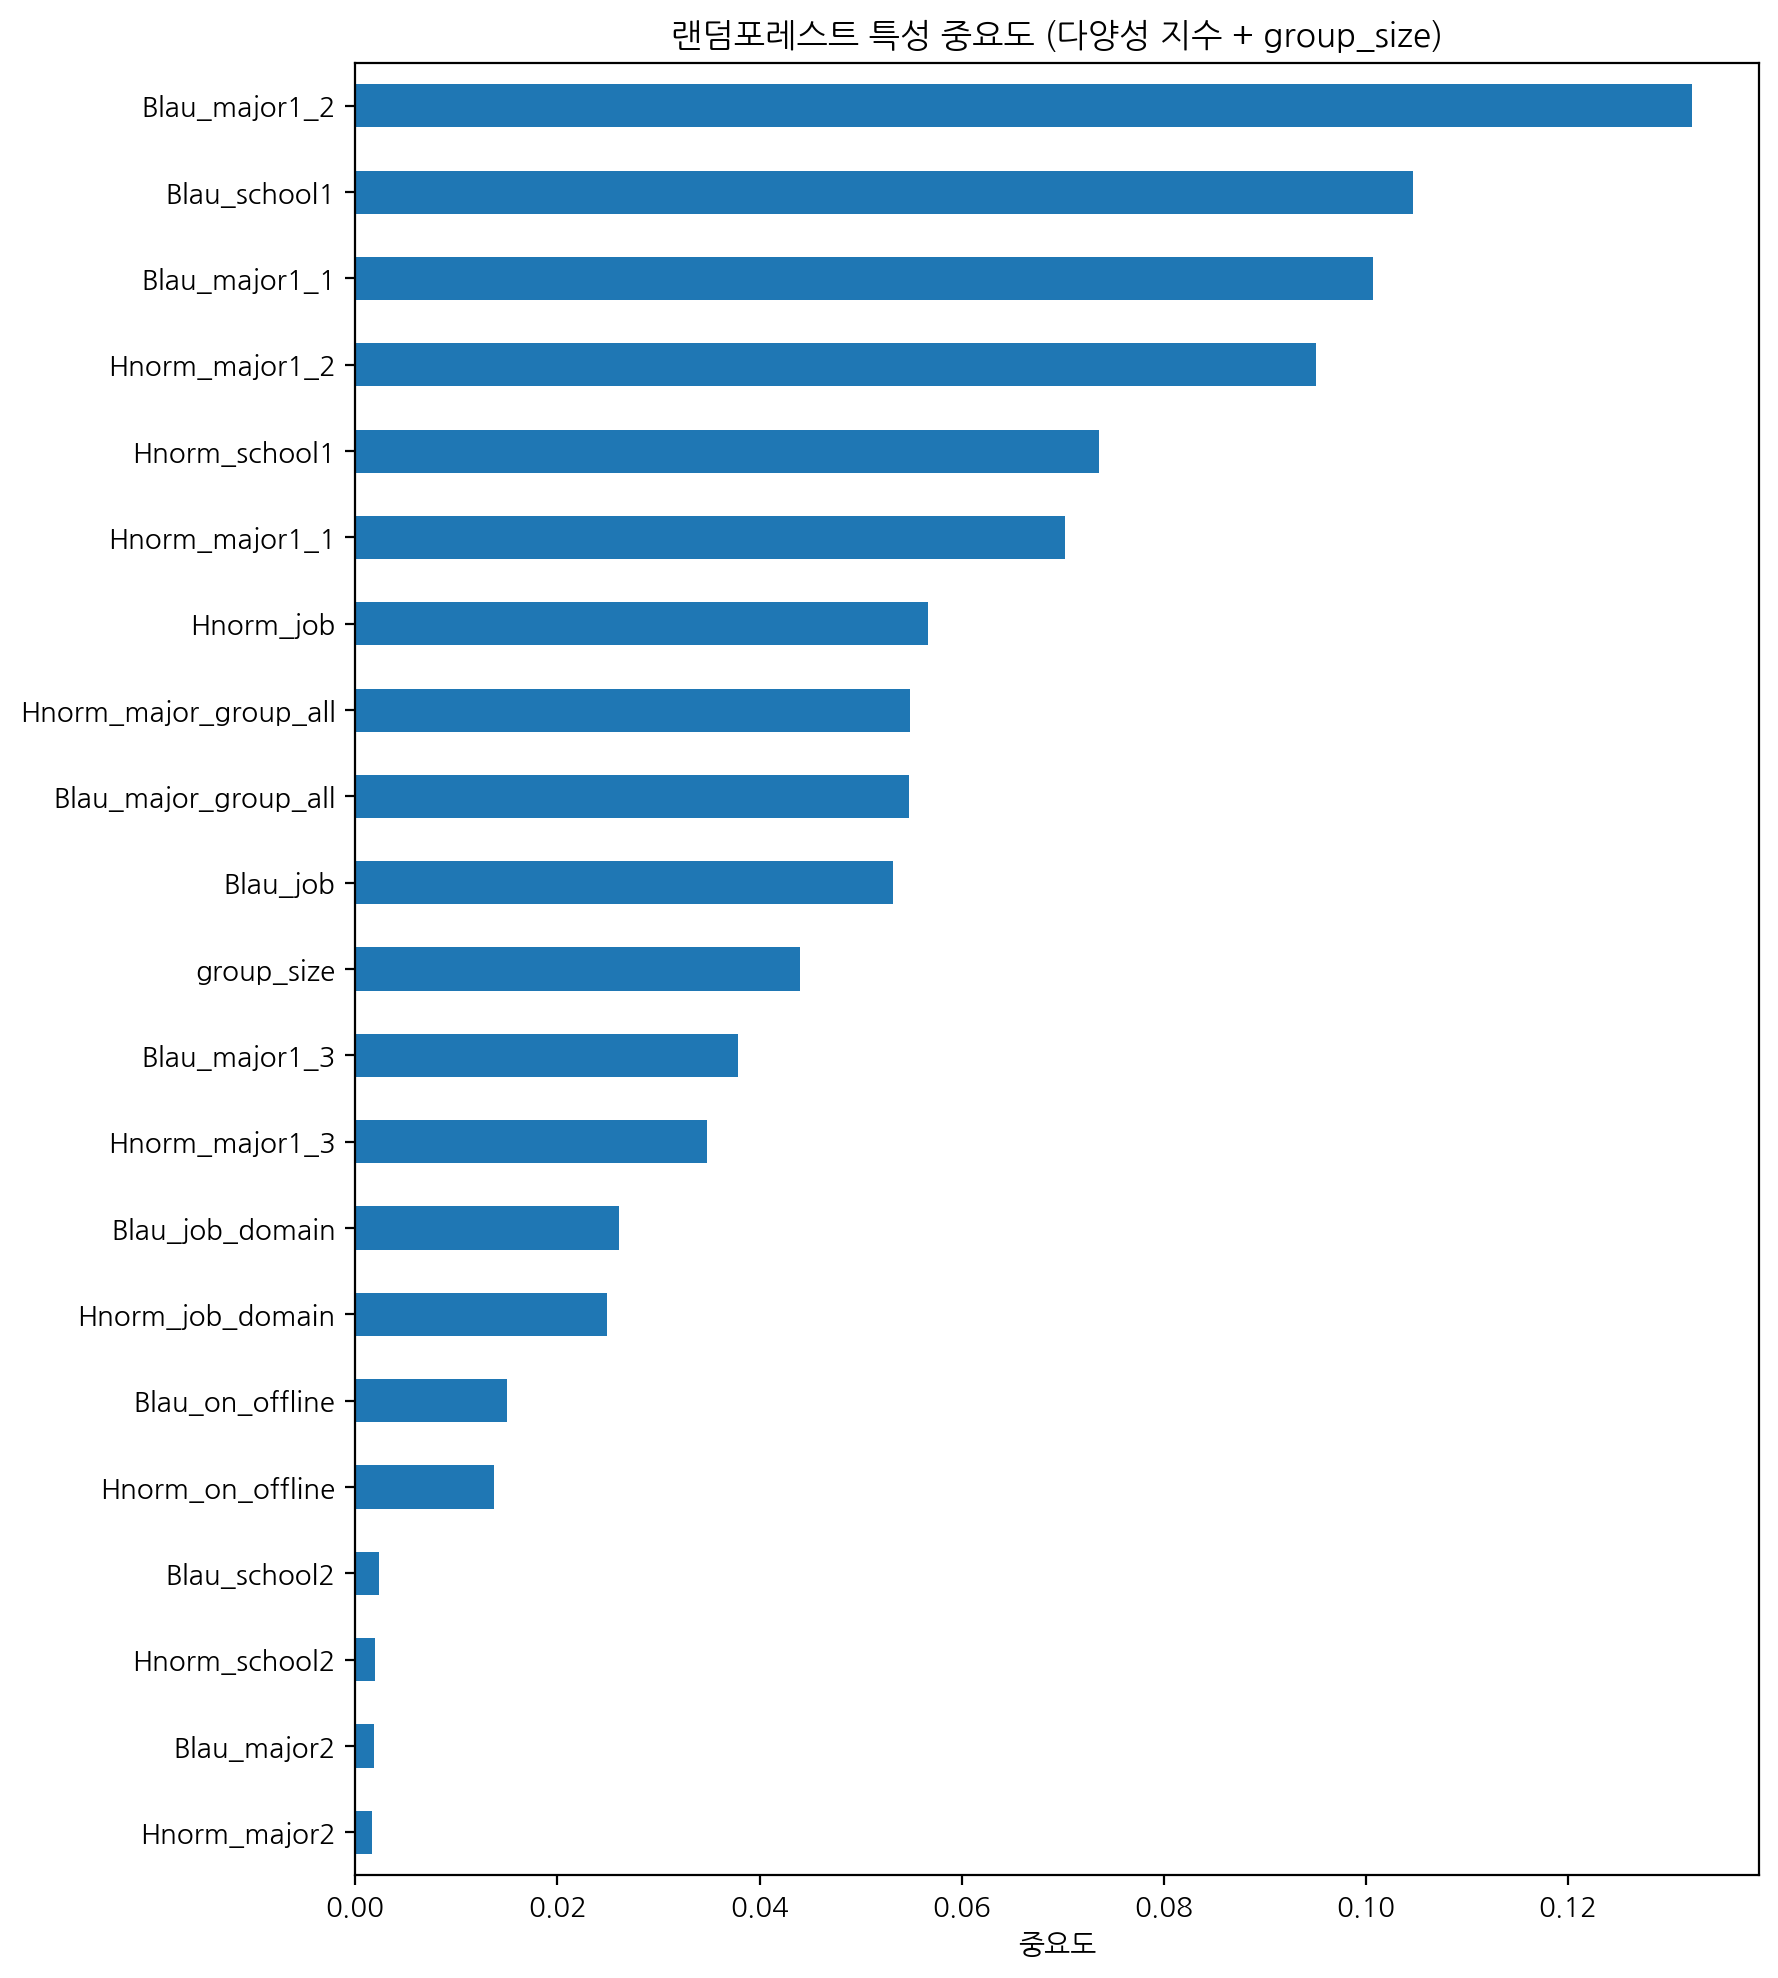


=== 그룹 레벨: point 평균과 (다양성 지수 + group_size) 상관계수 ===
point_mean               1.000000
Blau_major1_1            0.136375
group_size               0.123042
Hnorm_major1_1           0.104237
Hnorm_major_group_all    0.067070
Blau_major_group_all     0.063989
Blau_school1             0.063501
Hnorm_on_offline         0.041998
Hnorm_job                0.041041
Blau_on_offline          0.040355
Blau_job                 0.029520
Blau_major2              0.029369
Blau_school2             0.029369
Hnorm_school2            0.029175
Hnorm_major2             0.029175
Hnorm_job_domain         0.024706
Blau_job_domain          0.019391
Hnorm_school1            0.012560
Blau_major1_2           -0.001045
Hnorm_major1_2          -0.015929
Hnorm_major1_3          -0.084330
Blau_major1_3           -0.090231
Name: point_mean, dtype: float64


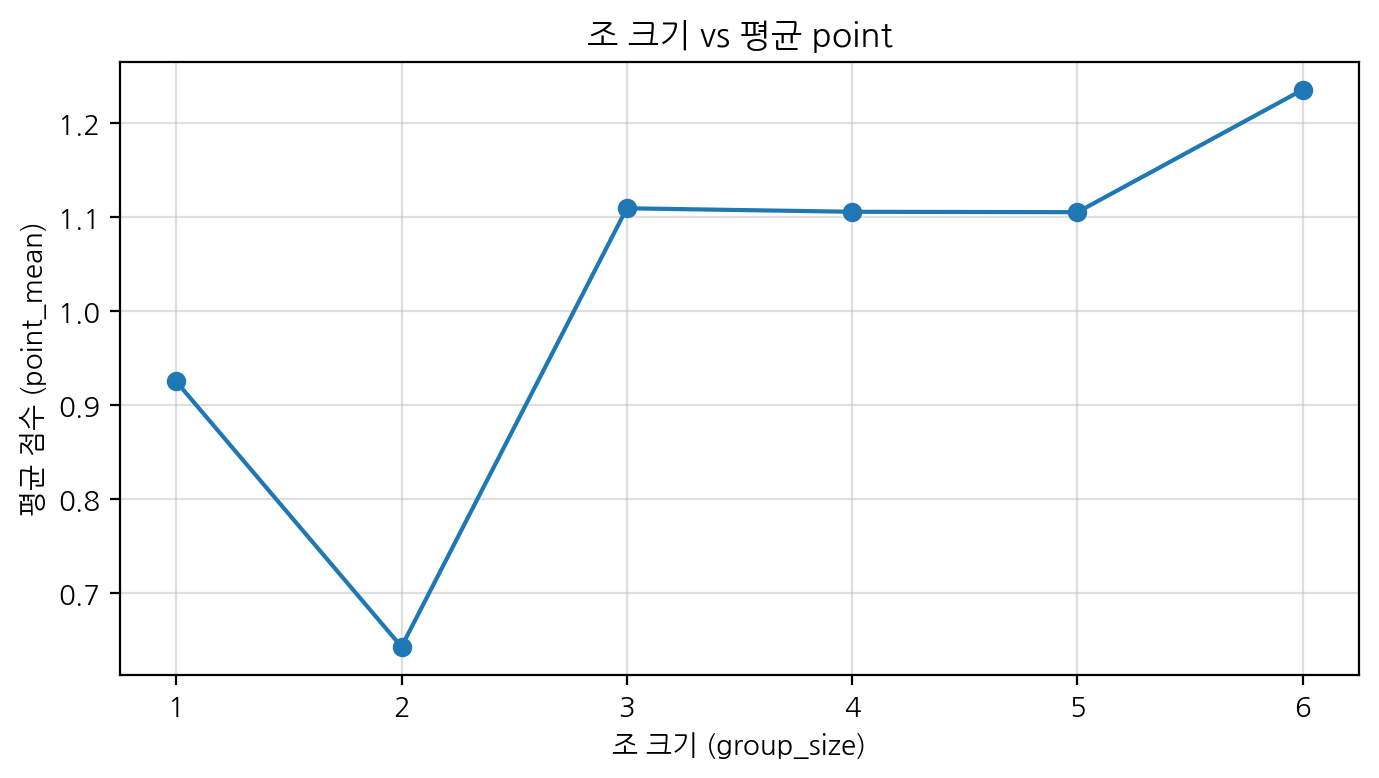


 조 크기(group_size)와 평균 점수(point_mean)의 상관계수: 0.123


In [ ]:
# 1) 기본 설정
GROUP_COLS_DEFAULT = ["generation", "class_code", "group_number"]
CAT_COLS_DEFAULT = [
    "school1", "school2",
    "major1_1", "major1_2", "major1_3", "major2",
    "job", "job_domain",
    "major_group_all",
    "on_offline",
]

# 2) 다양성 지수 함수
def shannon_index(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    if len(s) == 0:
        return np.nan
    p = s.value_counts(normalize=True)
    return float(-(p * np.log(p)).sum())

def shannon_normalized(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    K = s.nunique()
    if K <= 1:
        return 0.0
    H = shannon_index(s)
    return float(H / np.log(K))

def blau_index(series: pd.Series) -> float:
    s = series.dropna().astype(str)
    if len(s) == 0:
        return np.nan
    p = s.value_counts(normalize=True)
    return float(1.0 - np.sum(p**2))

# 3) 다양성 지수 계산
def compute_diversity_by_group(df: pd.DataFrame, group_cols, cat_cols):
    from functools import reduce

    missing_keys = [c for c in group_cols if c not in df.columns]
    if missing_keys:
        raise KeyError(f"[group_cols] 데이터에 없는 컬럼: {missing_keys}")

    use_cols = [c for c in cat_cols if c in df.columns]
    if not use_cols:
        return df[group_cols].drop_duplicates().reset_index(drop=True)

    out_frames = []
    g = df.groupby(group_cols, dropna=False)

    for col in use_cols:
        div = (
            g[col]
            .agg(
                **{
                    f"Hnorm_{col}": shannon_normalized,
                    f"Blau_{col}": blau_index,
                }
            )
            .reset_index()
        )
        out_frames.append(div)

    div_all = reduce(lambda l, r: pd.merge(l, r, on=group_cols, how="outer"), out_frames)
    return div_all

# 4) 메인 분석 함수
def analyze_group_yes_point(
    group_yes_point: pd.DataFrame,
    group_cols=GROUP_COLS_DEFAULT,
    cat_cols=CAT_COLS_DEFAULT,
    point_col: str = "point",
    leave_col: str = "group_leave",
):
    # 1) 필수 컬럼 점검
    must_cols = set(group_cols + [point_col, leave_col])
    missing = [c for c in must_cols if c not in group_yes_point.columns]
    if missing:
        raise KeyError(f"[필수 컬럼 없음] {missing}")

    # 2) 잔류자만 유지
    df = group_yes_point[group_yes_point[leave_col] != 1].copy()
    if df.empty:
        raise ValueError("필터링 후 데이터가 비었습니다. group_leave 값을 확인하세요.")

    # 3) 다양성 지수 및 그룹 크기
    div_group = compute_diversity_by_group(df, group_cols, cat_cols)
    group_sizes = (
        df.drop_duplicates(subset=["member_id"] + group_cols)
          .groupby(group_cols, dropna=False)["member_id"]
          .nunique()
          .reset_index(name="group_size")
    )

    # 4) 병합
    df = df.merge(div_group, on=group_cols, how="left")
    df = df.merge(group_sizes, on=group_cols, how="left")

    # 5) 피처 구성
    div_cols = [c for c in df.columns if c.startswith("Hnorm_") or c.startswith("Blau_")]
    feature_cols = div_cols + ["group_size"]
    if not feature_cols:
        raise ValueError("생성된 다양성 지수/그룹 크기 피처가 없습니다.")

    X = df[feature_cols].fillna(0.0)
    y = df[point_col].astype(float)

    # 6) Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    # 7) 선형 회귀
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_s, y_train)
    y_pred_lr = linreg.predict(X_test_s)

    print("=== 선형 회귀 성능 ===")
    print(f"R²        : {r2_score(y_test, y_pred_lr):.3f}")
    print(f"MAE       : {mean_absolute_error(y_test, y_pred_lr):.2f}")
    rmse_lr = float(np.sqrt(mean_squared_error(y_test, y_pred_lr)))
    print(f"RMSE      : {rmse_lr:.2f}")

    coef_series = pd.Series(linreg.coef_, index=feature_cols).sort_values()
    plt.figure(figsize=(9, 10))
    coef_series.plot(kind="barh")
    plt.title("선형 회귀 계수 (point에 대한 영향)")
    plt.xlabel("계수")
    plt.tight_layout()
    plt.show()

    # 8) 랜덤포레스트 회귀
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("\n=== 랜덤포레스트 회귀 성능 ===")
    print(f"R²        : {r2_score(y_test, y_pred_rf):.3f}")
    print(f"MAE       : {mean_absolute_error(y_test, y_pred_rf):.2f}")
    rmse_rf = float(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
    print(f"RMSE      : {rmse_rf:.2f}")

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
    plt.figure(figsize=(9, 10))
    importances.plot(kind="barh")
    plt.title("랜덤포레스트 특성 중요도 (다양성 지수 + group_size)")
    plt.xlabel("중요도")
    plt.tight_layout()
    plt.show()

    # 9) 그룹 레벨 상관분석
    group_point = df.groupby(group_cols, dropna=False)[point_col].mean().reset_index(name="point_mean")
    grp_anal = (
        group_point
        .merge(div_group, on=group_cols, how="left")
        .merge(group_sizes, on=group_cols, how="left")
    )

    corr_cols = [c for c in grp_anal.columns if c.startswith("Hnorm_") or c.startswith("Blau_")] + ["group_size"]
    corr = pd.concat([grp_anal["point_mean"], grp_anal[corr_cols]], axis=1).corr(numeric_only=True)["point_mean"].sort_values(ascending=False)

    print("\n=== 그룹 레벨: point 평균과 (다양성 지수 + group_size) 상관계수 ===")
    print(corr)

    # 10) 시각화: 조 크기 vs 평균 점수
    size_trend = grp_anal.groupby("group_size", dropna=False)["point_mean"].mean().reset_index()
    plt.figure(figsize=(7, 4))
    plt.plot(size_trend["group_size"], size_trend["point_mean"], marker="o")
    plt.title("조 크기 vs 평균 point")
    plt.xlabel("조 크기 (group_size)")
    plt.ylabel("평균 점수 (point_mean)")
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

    group_size_corr = grp_anal[["group_size", "point_mean"]].corr(numeric_only=True).iloc[0, 1]
    print(f"\n 조 크기(group_size)와 평균 점수(point_mean)의 상관계수: {group_size_corr:.3f}")

# 실행
analyze_group_yes_point(group_yes_point)

## 점수 추세 분석

### 기수별 점수 추세 및 변화량 분석

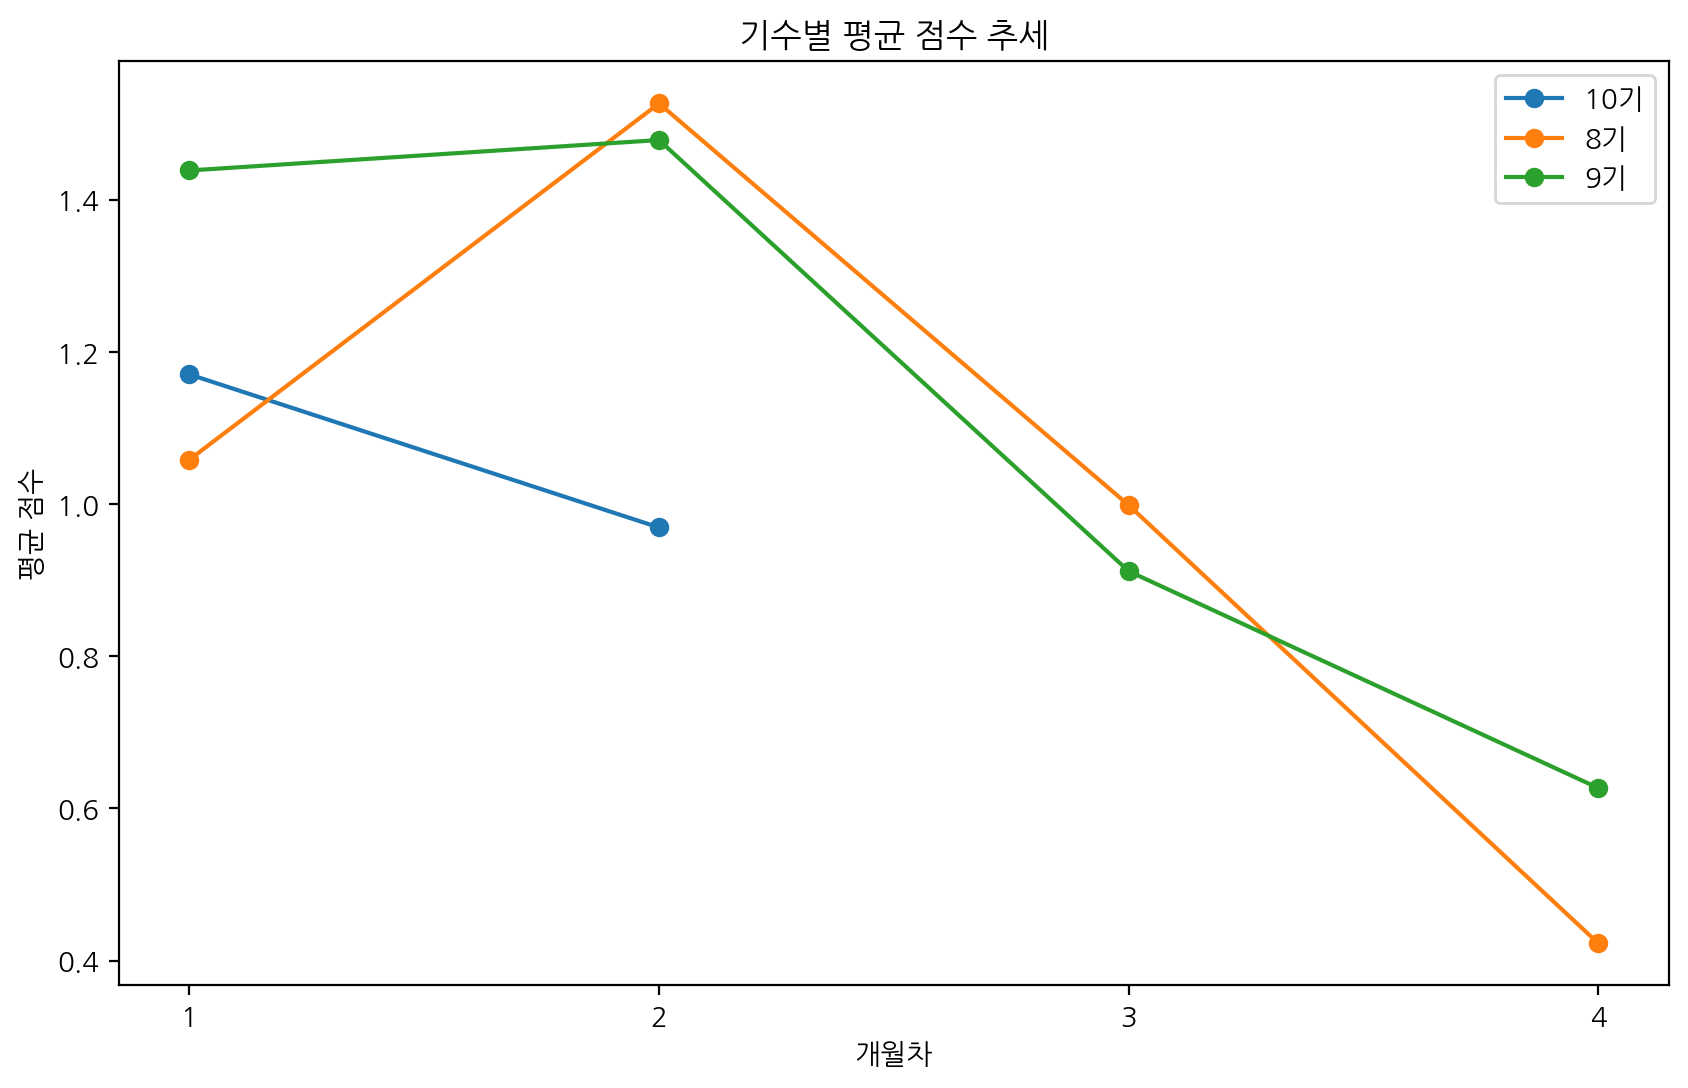

In [ ]:
avg_trend = point_ok.groupby(['generation','nth_month'], as_index=False)['point'].mean()

plt.figure(figsize=(10,6))
for gen, sub in avg_trend.groupby('generation'):
    plt.plot(sub['nth_month'], sub['point'], marker='o', label=f"{gen}기")
plt.title("기수별 평균 점수 추세")
plt.xlabel("개월차")
plt.ylabel("평균 점수")
plt.legend()
plt.show()

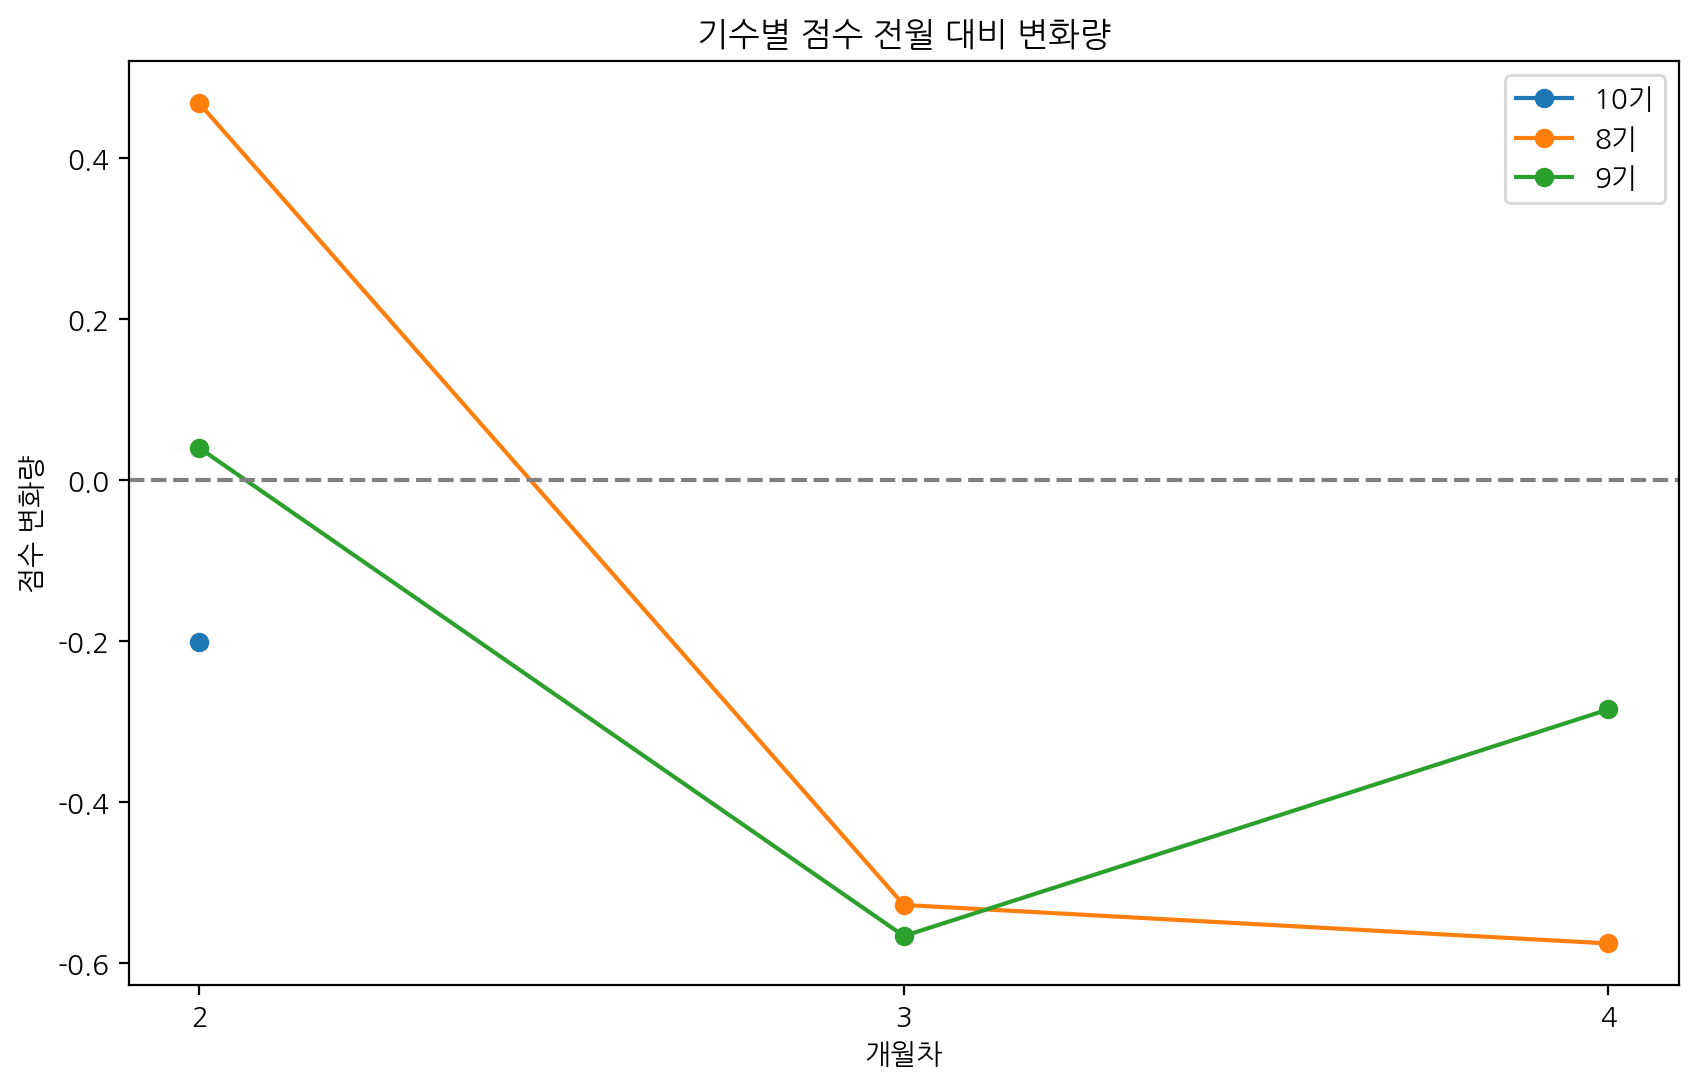

In [ ]:
avg_trend = avg_trend.sort_values(['generation','nth_month'])
avg_trend['전월대비변화'] = avg_trend.groupby('generation')['point'].diff()

plt.figure(figsize=(10,6))
for gen, sub in avg_trend.groupby('generation'):
    plt.plot(sub['nth_month'], sub['전월대비변화'], marker='o', label=f"{gen}기")
plt.axhline(0, color='gray', linestyle='--')
plt.title("기수별 점수 전월 대비 변화량")
plt.xlabel("개월차")
plt.ylabel("점수 변화량")
plt.legend()
plt.show()

### 9기 평가 체계

9기가 4개월치 데이터가 다 있고 점수 부여 기준이 일관됨  
=> 8기는 달마다 달라지는 기준이 있음 (ex 가산점 등) + 미 제출 점수가 9기, 10기랑 다름  
=> 10기는 2개월치 밖에 없어서 분석하기 용이하지 않음

[9기 평가 기준]
- 정해진 기간 만족 : 1점
- 가산점 : 만남 당 +1점
- 제출 필수 항목 미 제출 시 : 미 제출한 필수 항목 1개당 -0.1점
- 자율 활동 : 자율 활동 1개당 + 0.2점
- 필수 활동 안 했을 경우 : 하지 않은 필수 활동 1개당 -0.1점
- 캠을 키지 않은 경우 (온라인) : 캠을 키지 않은 온라인 만남 1회마다 -0.1점
- 컴퓨터 화면이 보이지 않은 경우 (온라인) :활동 중인 컴퓨터 화면이 보이지 않는 온라인 만남 1회마다 -0.1점
- 지각 제출 시 : 기존 점수에서 -0.2점
- 미 제출 시 : 미 제출 시 -0.5점


In [ ]:
def classify_status_9th(score):
    if score == -0.5:
        return "미제출(-0.5)"         # 제출 자체를 안 한 경우
    elif score < 1:
        return "규칙위반/감점"        # 제출은 했지만 규칙 위반 등으로 감점
    elif score == 1:
        return "필수만 제출"          # 필수 활동만 한 경우
    elif score > 1:
        return "자율참여/가산점"      # 자율 활동/가산점 포함
    else:
        return "기타"                 # 혹시 모를 edge case

# 9기 데이터만 필터 후 적용
point_9 = point_ok[point_ok['generation'] == '9'].copy()
point_9['status'] = point_9['point'].apply(classify_status_9th)

### 9기 활동 분포 추세

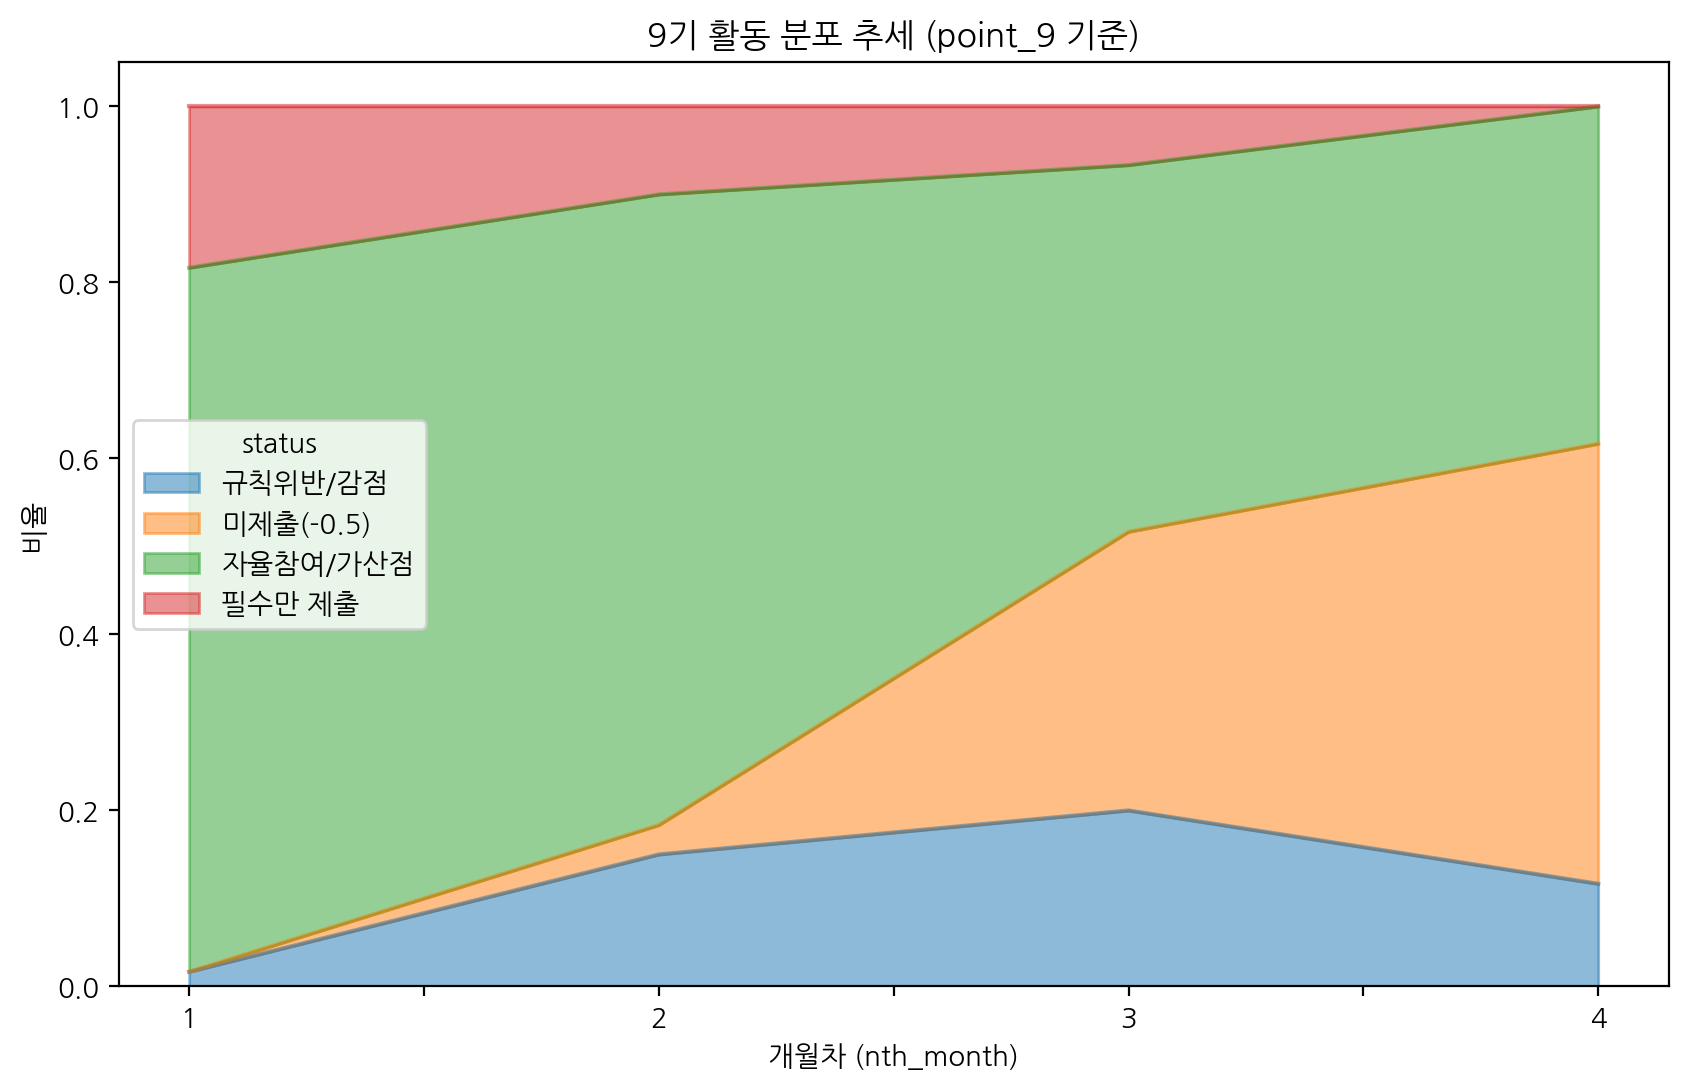

In [ ]:
# 상태별 count (9기 전용)
status_counts = (
    point_9.groupby(['nth_month','status'])
           .size()
           .reset_index(name='count')
)

# 전체 대비 비율
status_counts['total'] = status_counts.groupby('nth_month')['count'].transform('sum')
status_counts['ratio'] = status_counts['count'] / status_counts['total']

# pivot 변환
pivoted = (status_counts.pivot_table(index='nth_month',
                                     columns='status',
                                     values='ratio',
                                     fill_value=0)
                          .reset_index()
                          .sort_values('nth_month'))

# stacked area chart
pivoted.plot(x='nth_month', kind='area', stacked=True, alpha=0.5, figsize=(10,6))
plt.title("9기 활동 분포 추세 (point_9 기준)")
plt.xlabel("개월차 (nth_month)")
plt.ylabel("비율")
plt.ylim(0,1.05)
plt.legend(title="status")
plt.show()